In [1]:
#%matplotlib inline
import os
import numpy as np
import math
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import clear_output
from PIL import Image
import torch.optim as optim
import optuna

import torch
import torch.nn as nn
from torch import autograd
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision.datasets import ImageFolder

from pytorch_model_summary import summary

from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid

from sklearn.preprocessing import normalize

import os
import glob

from matplotlib.colors import Normalize

from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import time

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, src_file, num_rows=None):
        self.src_file = src_file
        
    def __len__(self):
        main_path = self.src_file
        data_folder_X = os.path.join(main_path, 'X') 
        data_filepaths_X = sorted(glob.glob(data_folder_X+"/*"))
        return len(data_filepaths_X)

    def __getitem__(self, idx):    
 
        x_data = X[idx].to(device)
        y_data = y[idx].to(device)
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return x_data, y_data

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, neurons_1, neurons_2, neurons_3, neurons_4):
        super().__init__()
        self.fc1 = nn.Linear(4, neurons_1)
        self.fc2 = nn.Linear(neurons_1, neurons_2)
        self.fc3 = nn.Linear(neurons_2, neurons_3)
        self.fc4 = nn.Linear(neurons_3, neurons_4)
        self.fc5 = nn.Linear(neurons_4, 200)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x

In [6]:
def train(num_epochs, model, criterion, optimizer, train_loader, test_loader):
    loss_history = []
    l = []
    val_loss_history = []
    val_l = []
    model.train()
    for epoch in range(0, num_epochs):
        
        for i, batch in enumerate(train_loader, start=0):
            real_param, real_sp = batch
            pred_sp = model(real_param)
            loss = criterion(real_sp, pred_sp)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            l.append(loss.item())
        last_epoch_loss =  torch.tensor(l[-len(train_loader):-1]).mean()
        if epoch%100 == 0: print("Epoch {} with {:.8f} loss".format(epoch,last_epoch_loss))
        loss_history.append(last_epoch_loss)
        
        for j, val_batch in enumerate(test_loader, start=0):
            val_real_param, val_real_sp = val_batch
            val_pred_sp = model(val_real_param)
            val_loss = criterion(val_real_sp, val_pred_sp)
            val_l.append(val_loss.item())
        val_last_epoch_loss =  torch.tensor(l[-len(test_loader):-1]).mean()
        val_loss_history.append(val_last_epoch_loss)
        
    return l, last_epoch_loss, loss_history, val_loss_history

In [8]:
main_path = './dataset_final_train'
data_folder_X = os.path.join(main_path, 'X') 
data_folder_Y = os.path.join(main_path, 'Y') 
data_filepaths_X = sorted(glob.glob(data_folder_X+"/*"))
data_filepaths_Y = sorted(glob.glob(data_folder_Y+"/*"))

X = np.array(pd.read_csv(data_filepaths_X[0], sep=": ", names = ['parameter', 'value'])['value'])
Y = np.array(pd.read_csv(data_filepaths_Y[0], sep="\t", names = ['wavelength', 'LCP', 'RCP', 'CD'])['CD'])
for path in data_filepaths_X[1:2]:
    x_tmp = np.array(pd.read_csv(path, sep=": ", names = ['parameter', 'value'])['value'])
    X = np.stack((X, x_tmp), axis=0)
for path in data_filepaths_Y[1:2]:
    y_tmp = np.array(pd.read_csv(path, sep="\t", names = ['wavelength', 'LCP', 'RCP', 'CD'])['CD'])
    Y = np.stack((Y, y_tmp), axis=0)    
for path in data_filepaths_X[2:]:
    x_tmp = np.array(pd.read_csv(path, sep=": ", names = ['parameter', 'value'])['value'])
    X = np.append(arr=X, values=np.array([x_tmp]), axis=0)
for path in data_filepaths_Y[2:]:
    y_tmp = np.array(pd.read_csv(path, sep="\t", names = ['wavelength', 'LCP', 'RCP', 'CD'])['CD'])
    Y = np.append(arr=Y, values=np.array([y_tmp]), axis=0) 

X = np.delete(X, (1,2,3,4), 1)

X = torch.from_numpy(X).float()
y = torch.from_numpy(Y).float()

mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

dataset = MyDataset(src_file=main_path)
training_data, test_data = torch.utils.data.random_split(dataset, [768, 192])

y_tmp = pd.read_csv(data_filepaths_Y[0], sep="\t", names = ['wavelength', 'LCP', 'RCP', 'CD'])
wavelengths = y_tmp['wavelength']

/Users/an.romashkina/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [9]:
training_data[10]

(tensor([ 0.7067, -1.5267,  0.6543,  1.2241]),
 tensor([-9.6767e-03, -1.0886e-02, -1.0290e-02, -1.0654e-02, -1.0179e-02,
         -1.0999e-02, -1.1127e-02, -1.1153e-02, -1.3476e-02, -1.5333e-02,
         -1.9695e-02, -2.3967e-02, -2.8945e-02, -2.7735e-02, -2.1043e-02,
         -1.9171e-02, -1.8693e-02, -2.3585e-02, -2.7712e-02, -2.5240e-02,
         -1.7876e-02, -7.0629e-03,  1.8661e-03,  1.4366e-02,  3.0717e-02,
          6.4710e-02,  9.7484e-02,  7.7982e-02,  2.4202e-02,  2.4572e-03,
         -1.2335e-02, -1.6174e-02, -1.4041e-02, -1.4924e-02, -2.1003e-02,
         -2.0494e-02, -2.3522e-02, -2.4093e-02, -2.1703e-02, -2.0618e-02,
         -1.6098e-02, -1.2981e-02, -9.1449e-03, -7.4827e-03, -6.5666e-03,
         -4.0967e-03, -3.6405e-03, -2.4124e-03, -6.3929e-04,  4.3014e-03,
          3.6584e-03,  1.7212e-03,  8.2782e-04, -4.7081e-04,  6.2383e-04,
          1.1074e-03,  1.0437e-03,  1.4303e-03,  1.6583e-03,  2.9084e-03,
          2.7138e-03,  2.3903e-03,  2.0588e-03,  1.6655e-03,  1.4

In [11]:
###### OPTUNA OPTIMIZATION ##########

def objective(trial):
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    batch_size = trial.suggest_int("batch_size", 16, 336, step=32)
    
    neurons_1 =  trial.suggest_int("neurons_1", 16, 512)
    neurons_2 =  trial.suggest_int("neurons_2", 16, 512)
    neurons_3 =  trial.suggest_int("neurons_3", 16, 512)
    neurons_4 =  trial.suggest_int("neurons_4", 16, 512)

    model = SimpleNN(neurons_1, neurons_2, neurons_3, neurons_4).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(), lr=lr
    ) 

    train_loader = DataLoader(training_data, num_workers=0, batch_size=batch_size, shuffle=True)
    _, last_epoch_loss, loss_history = train(1000, model, criterion, optimizer, train_loader)
    return last_epoch_loss

study = optuna.create_study(direction="minimize", study_name="Optima")

study.optimize(
    objective, n_trials=100) 



[I 2022-06-24 22:59:50,714] A new study created in memory with name: Optima
[W 2022-06-24 22:59:50,725] Trial 0 failed because of the following error: TypeError("train() missing 1 required positional argument: 'test_loader'")
Traceback (most recent call last):
  File "/Users/an.romashkina/opt/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-11-2ca84ac0519e>", line 19, in objective
    _, last_epoch_loss, loss_history = train(1000, model, criterion, optimizer, train_loader)
TypeError: train() missing 1 required positional argument: 'test_loader'


TypeError: train() missing 1 required positional argument: 'test_loader'

In [1]:
study.best_params

######################################

NameError: name 'study' is not defined

In [10]:
#### TRAINING THE MODEL ##############

start = time.time()
model = SimpleNN(32, 64, 128, 256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.0005)

epochs = 5000
train_loader = DataLoader(training_data, num_workers=0, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, num_workers=0, batch_size=32, shuffle=True) # take batch_size", which choosen Optuna
l_optim, _, loss_history, val_loss_history = train(epochs, model, criterion, optimizer, train_loader, test_loader)  # take latent_dim, which choosen Optuna
end = time.time()
#print(str(epochs)+' epohs - '+ str'seconds')

Epoch 0 with 0.00197254 loss
Epoch 100 with 0.00003889 loss


KeyboardInterrupt: 

In [10]:
print ("Model training time: "+ str(end-start) + " seconds")

Model training time: 260.39604115486145seconds


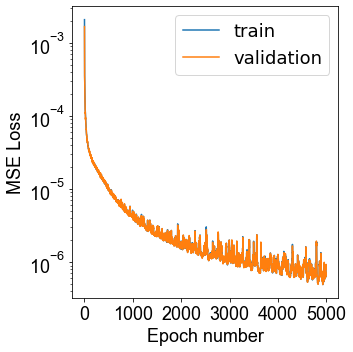

In [76]:
fig = plt.figure(figsize=(5,5)) 
font = {'fontname':'Arial', 'size' : 22}
plt.rcParams.update({'font.serif':'Times'})
plt.plot(loss_history, label="train")
plt.plot(val_loss_history, label="validation")
#plt.plot(val_loss, label="val")
plt.xlabel('Epoch number')
plt.ylabel('MSE Loss')
plt.yscale('log')
font = {'fontname':'Arial', 'size' : 18}
plt.xlabel('Epoch number', **font)
plt.ylabel('MSE Loss', **font)
plt.xticks(**font)
plt.yticks(**font)
plt.legend(fontsize=18)
axes=plt.gca()
#axes.set_aspect(200)
plt.tight_layout()
plt.savefig('Ppol'+ 'mc.png',format='png', bbox_inches='tight')

plt.show()

In [12]:
test_loader = DataLoader(test_data, num_workers=0, batch_size=1, shuffle=True)

In [79]:
main_path = '/Users/an.romashkina/Разные документы/SHG Lab/Chiral/Design/dataset_final_train'
data_folder_Y = os.path.join(main_path, 'Y') 
data_filepaths_Y = sorted(glob.glob(data_folder_Y+"/*"))
y_tmp = pd.read_csv(data_filepaths_Y[0], sep="\t", names = ['wavelength', 'LCP', 'RCP', 'CD'])
wavelengths = y_tmp['wavelength']

In [94]:
def plot_predictions(model, test_loader):
    predictions = []
    losses = []

    model.eval()
    for i, batch in enumerate(test_loader, 0):
        
        real_param, real_sp = batch
        pred_sp = model(real_param)
        loss = criterion(real_sp, pred_sp)
        predictions.append(pred_sp)
        losses.append(loss)
        if max(max(abs(pred_sp)))>0.2:
            fig = plt.figure(figsize=(5,5)) 
            font = {'fontname':'Helvetica', 'size' : 22}
            plt.rcParams.update({'font.serif':'Times'})

            plt.plot(wavelengths*1e9, pred_sp.detach().numpy()[0], label='ANN', color = 'green')
            plt.plot(wavelengths*1e9, real_sp.detach().numpy()[0], label='FDTD', linestyle='dotted', color = 'darkblue', linewidth=2)
            font = {'fontname':'Helvetica', 'size' : 18}
            plt.xlabel('Wavelength, nm', **font)
            plt.ylabel('CD', **font)
            plt.xticks(**font)
            plt.yticks(**font)
            plt.xlim([500, 1000])
            #plt.ylim([-0.44, 0.05])
            plt.legend(fontsize=18)
            axes=plt.gca()
           # axes.set_aspect(5000)
            plt.tight_layout()
            plt.show()
            print((real_param*std+mean)*1e9)

    return predictions, losses

In [82]:
test_loader = DataLoader(test_data, num_workers=0, batch_size=1, shuffle=True)

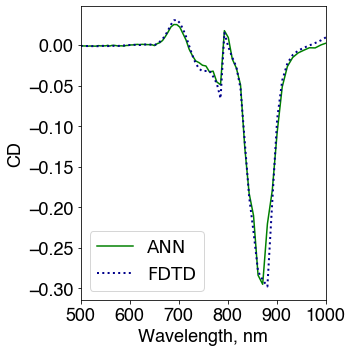

tensor([[440., 440., 290.,  70.,  40.]])


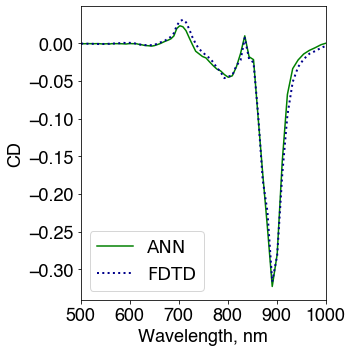

tensor([[470., 470., 300.,  70.,  40.]])


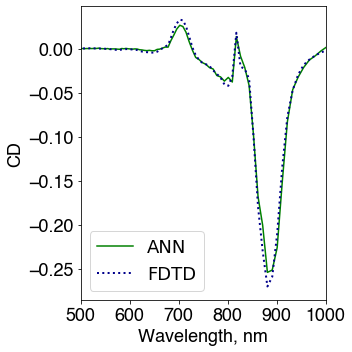

tensor([[460.0000, 460.0000, 290.0000,  70.0000,  30.0000]])


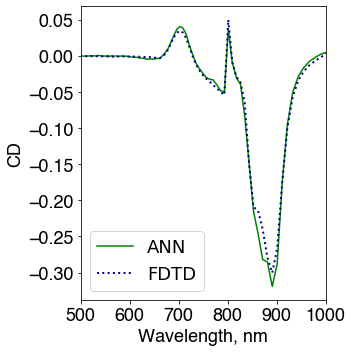

tensor([[450.0000, 450.0000, 280.0000,  70.0000,  30.0000]])


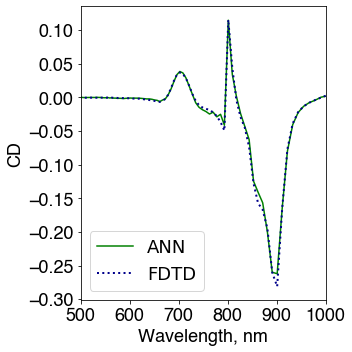

tensor([[450., 450., 300.,  70.,  40.]])


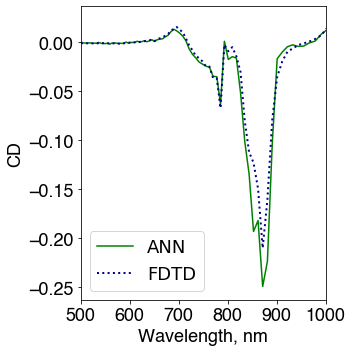

tensor([[440.0000, 440.0000, 280.0000,  60.0000,  50.0000]])


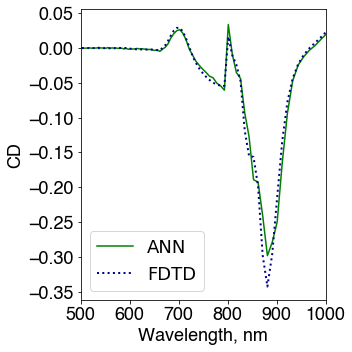

tensor([[450.0000, 450.0000, 270.0000,  60.0000,  30.0000]])


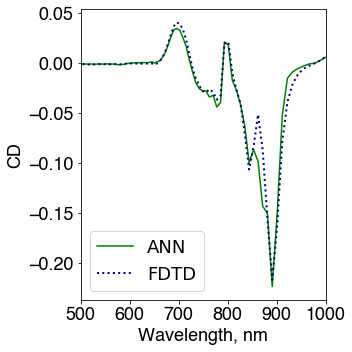

tensor([[440., 440., 300.,  70.,  40.]])


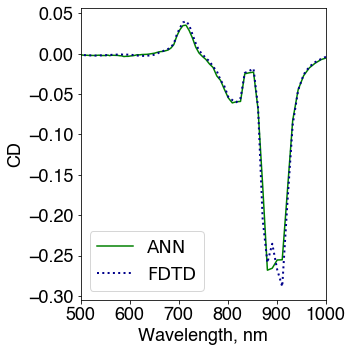

tensor([[470.0000, 470.0000, 300.0000,  90.0000,  30.0000]])


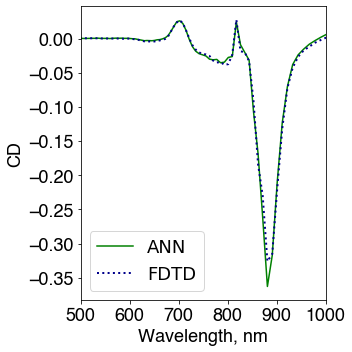

tensor([[460.0000, 460.0000, 290.0000,  60.0000,  40.0000]])


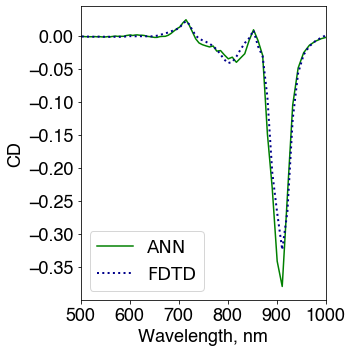

tensor([[480.0000, 480.0000, 310.0000,  60.0000,  50.0000]])


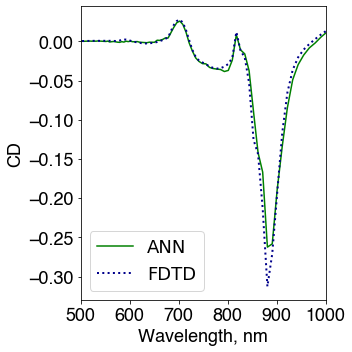

tensor([[460.0000, 460.0000, 280.0000,  60.0000,  30.0000]])


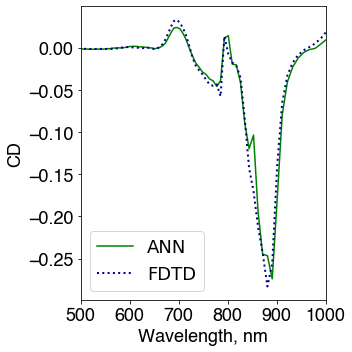

tensor([[440.0000, 440.0000, 290.0000,  60.0000,  40.0000]])


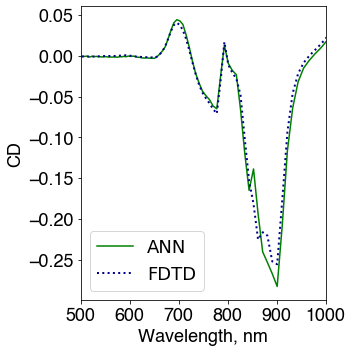

tensor([[440.0000, 440.0000, 290.0000,  60.0000,  30.0000]])


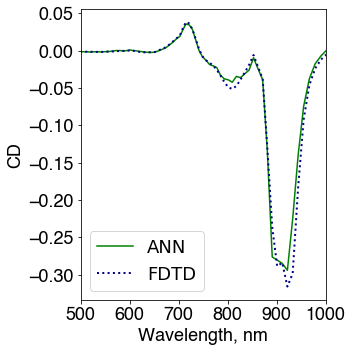

tensor([[480.0000, 480.0000, 310.0000,  70.0000,  30.0000]])


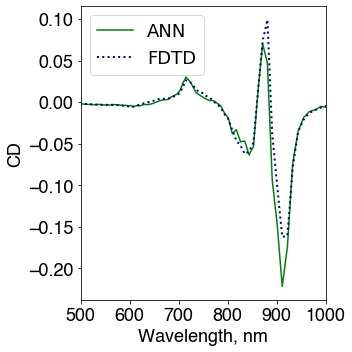

tensor([[480.0000, 480.0000, 310.0000, 110.0000,  30.0000]])


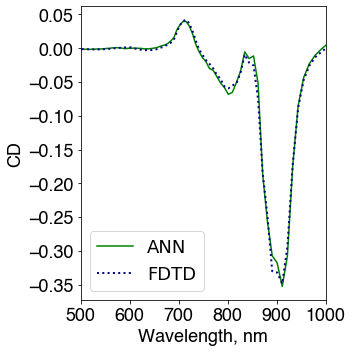

tensor([[470.0000, 470.0000, 300.0000,  70.0000,  30.0000]])


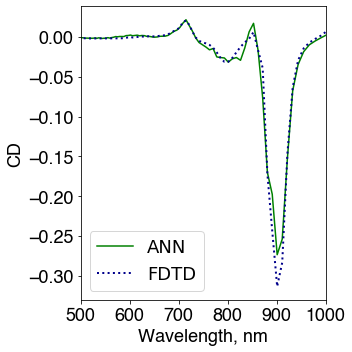

tensor([[480.0000, 480.0000, 300.0000,  60.0000,  50.0000]])


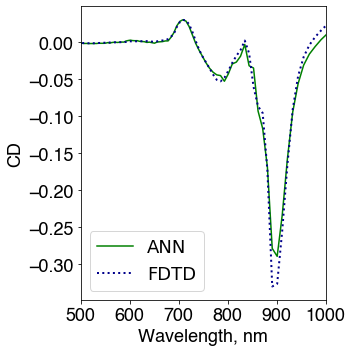

tensor([[470.0000, 470.0000, 280.0000,  60.0000,  30.0000]])


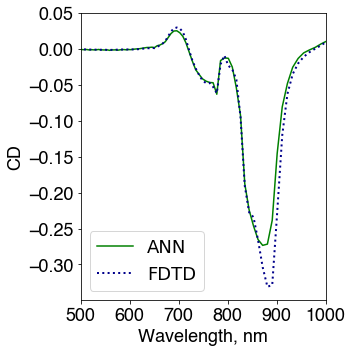

tensor([[440.0000, 440.0000, 280.0000,  70.0000,  30.0000]])


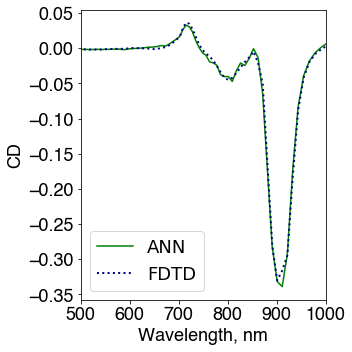

tensor([[480.0000, 480.0000, 300.0000,  70.0000,  30.0000]])


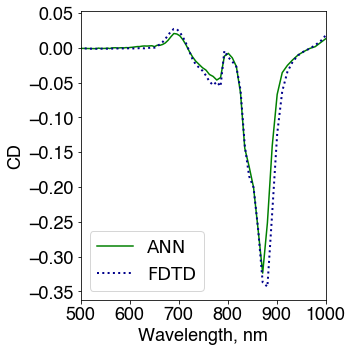

tensor([[440.0000, 440.0000, 280.0000,  60.0000,  40.0000]])


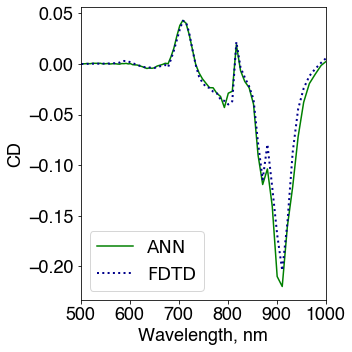

tensor([[460.0000, 460.0000, 310.0000,  60.0000,  30.0000]])


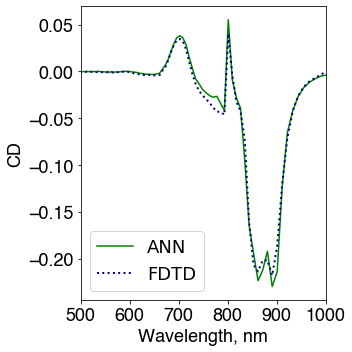

tensor([[450.0000, 450.0000, 280.0000,  80.0000,  30.0000]])


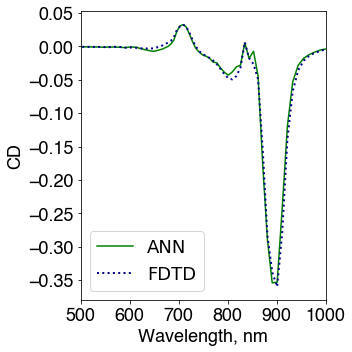

tensor([[470., 470., 310.,  70.,  40.]])


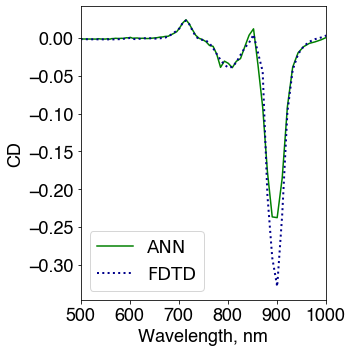

tensor([[480.0000, 480.0000, 300.0000,  70.0000,  50.0000]])


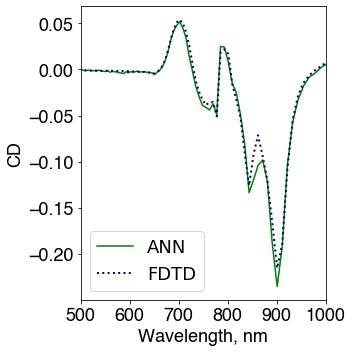

tensor([[440.0000, 440.0000, 300.0000,  70.0000,  30.0000]])


In [95]:
predictions, losses = plot_predictions(model, test_loader)

Text(0.76, 0.91, 'СD')

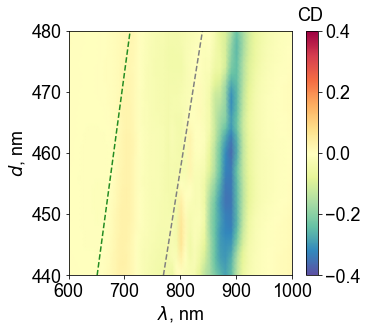

In [40]:
period = 0.46e-6
b = 0.29e-6
bias = 0.06e-6
gap = 0.04e-6

period_range = np.arange(0.44e-6, 0.481e-6, step = 0.001e-6)

column_names = wavelengths.tolist()
df = pd.DataFrame(columns = column_names)
for period in period_range:
    x = np.array([period, b, bias, gap])
    x = torch.from_numpy(x).float()
    x = (x - mean) / std
    x = torch.unsqueeze(x, dim=0)
    cd_sp = model(x.to(device))
    df.loc[period] = cd_sp[0, :].detach().numpy()
font = {'fontname':'Arial', 'size' : 18}
fig = plt.figure(figsize=(5,4.5)) 
y = period_range*1e9
x = wavelengths *1e9
plt.pcolormesh(x,y,df.astype(float), cmap='Spectral_r', norm = Normalize(vmin = -0.4, vmax = 0.4, clip = False),
           shading ='gouraud')
plt.plot(y*1.75,y, linestyle = 'dashed', color='grey')
plt.plot(y*1.48,y, linestyle = 'dashed', color='forestgreen')
#plt.title('circular dicroism', **font)
plt.xticks(**font)
plt.yticks(ticks=[440, 450, 460, 470, 480],**font)
plt.xlim([600, 1000])
plt.ylim([440, 480])
cbar = plt.colorbar()
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_family("Arial")
cbar.ax.tick_params(labelsize=18)
plt.ylabel(r'$d$, nm', **font)
plt.xlabel(r'$\lambda$, nm', **font)

fig.text(0.76, 0.91, 'СD', **font)

In [22]:
def best_cd(cd_sp):
    pos_sp = max(max(cd_sp))
    neg_sp = min(min(cd_sp))
    if abs(pos_sp)>abs(neg_sp): 
        return pos_sp
    else: 
        return neg_sp

Text(0.76, 0.91, 'СD')

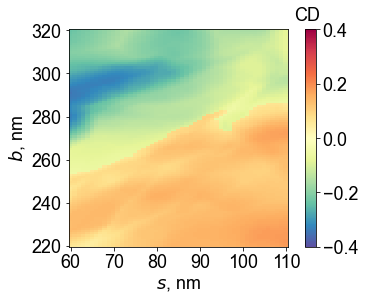

In [32]:
period = 0.455e-6
b = 0.29e-6
bias = 0.06e-6
gap = 0.04e-6

bias_range = np.arange(0.06e-6, 0.111e-6, step = 0.001e-6)
b_range = np.arange(0.22e-6, 0.321e-6, step = 0.001e-6)

column_names = bias_range.tolist()
column_names.append(0.)
df = pd.DataFrame(columns = column_names)
df[0.] = pd.Series(data=b_range)
for bias in bias_range:
    for b in b_range:
        x = np.array([period, b, bias, gap])
        x = torch.from_numpy(x).float()
        x = (x - mean) / std
        x = torch.unsqueeze(x, dim=0)
        cd_sp = model(x.to(device))
        df.loc[df[0.]==b, bias] = best_cd(cd_sp).item()
        
font = {'fontname':'Arial', 'size' : 18}
fig, axes = plt.subplots() 
x = bias_range*1e9
y = b_range *1e9
plt.pcolormesh(x,y,df.iloc[:,0:-1].astype(float), cmap='Spectral_r', norm = Normalize(vmin = -0.4, vmax = 0.4, clip = False),
           shading ='auto')
plt.xticks(**font)
plt.yticks(**font)
cbar = plt.colorbar()
plt.ylabel(r'$b$, nm', **font)
plt.xlabel(r'$s$, nm', **font)
axes.set_aspect(0.5)
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_family("Arial")
cbar.ax.tick_params(labelsize=18)
fig.text(0.76, 0.91, 'СD', **font)

Text(0.76, 0.91, 'СD')

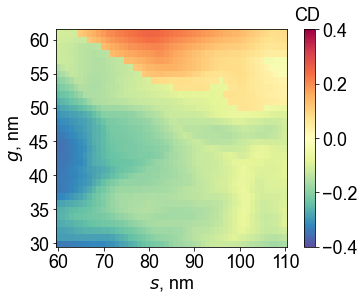

In [33]:
period = 0.455e-6
b = 0.29e-6
bias = 0.06e-6
gap = 0.04e-6

bias_range = np.arange(0.06e-6, 0.111e-6, step = 0.001e-6)
gap_range = np.arange(0.03e-6, 0.061e-6, step = 0.001e-6)

column_names = bias_range.tolist()
column_names.append(0.)
df = pd.DataFrame(columns = column_names)
df[0.] = pd.Series(data=gap_range)
for bias in bias_range:
    for gap in gap_range:
        x = np.array([period, b, bias, gap])
        x = torch.from_numpy(x).float()
        x = (x - mean) / std
        x = torch.unsqueeze(x, dim=0)
        cd_sp = model(x.to(device))
        df.loc[df[0.]==gap, bias] = best_cd(cd_sp).item()
font = {'fontname':'Arial', 'size' : 18}
fig, axes = plt.subplots() 
x = bias_range*1e9
y = gap_range *1e9
plt.pcolormesh(x,y,df.iloc[:,0:-1].astype(float), cmap='Spectral_r', norm = Normalize(vmin = -0.4, vmax = 0.4, clip = False),
           shading ='auto')
cbar = plt.colorbar()
plt.ylabel(r'$g$, nm', **font)
plt.xlabel(r'$s$, nm', **font)
plt.xticks(**font)
plt.yticks(**font)
axes.set_aspect(1.5)
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_family("Arial")
cbar.ax.tick_params(labelsize=18)
fig.text(0.76, 0.91, 'СD', **font)

Text(0.76, 0.91, 'СD')

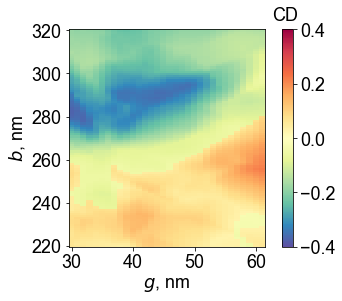

In [35]:
period = 0.455e-6
b = 0.29e-6
bias = 0.06e-6
gap = 0.04e-6

gap_range = np.arange(0.03e-6, 0.061e-6, step = 0.001e-6)
b_range = np.arange(0.22e-6, 0.321e-6, step = 0.001e-6)

column_names = gap_range.tolist()
column_names.append(0.)
df = pd.DataFrame(columns = column_names)
df[0.] = pd.Series(data=b_range)
for gap in gap_range:
    for b in b_range:
        x = np.array([period, b, bias, gap])
        x = torch.from_numpy(x).float()
        x = (x - mean) / std
        x = torch.unsqueeze(x, dim=0)
        cd_sp = model(x.to(device))
        df.loc[df[0.]==b, gap] = best_cd(cd_sp).item()
font = {'fontname':'Arial', 'size' : 18}
fig, axes = plt.subplots() 
x = gap_range*1e9
y = b_range *1e9
plt.pcolormesh(x,y,df.iloc[:,0:-1].astype(float), cmap='Spectral_r', norm = Normalize(vmin = -0.4, vmax = 0.4, clip = False),
           shading ='auto')
#plt.title('circular dicroism (max abs value)', **font)
plt.xticks(**font)
plt.yticks(**font)
cbar = plt.colorbar()
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_family("Arial")
axes.set_aspect(0.35)
cbar.ax.tick_params(labelsize=18)
plt.ylabel(r'$b$, nm', **font)
plt.xlabel(r'$g$, nm', **font)
fig.text(0.76, 0.91, 'СD', **font)

In [39]:
period = 0.46e-6
b = 0.22e-6
bias = 0.14e-6
gap = 0.12e-6

period_range = np.arange(0.44e-6, 0.48e-6, step = 0.001e-6)
b_range = np.arange(0.25e-6, 0.315e-6, step = 0.001e-6)
bias_range = np.arange(0.06e-6, 0.11e-6, step = 0.001e-6)
gap_range = np.arange(0.025e-6, 0.06e-6, step = 0.001e-6)

max_cd = 0
params_max = [period, b, bias, gap]


for period_x, period_y in zip(period_range, period_range):
    print(period_x)
    for b in b_range:
        
        for gap in gap_range:
            for bias in bias_range:
                x = np.array([period_x, period_y, b, bias, gap])
                x = torch.from_numpy(x).float()
                x = (x - mean) / std
                x = torch.unsqueeze(x, dim=0)
                cd_sp = model(x.to(device))
                if max(max(abs(cd_sp))) > 0.37:
                    print(max(max(abs(cd_sp))), [1e9*period_x, 1e9*period_y, 1e9*b, 1e9*bias, 1e9*gap])
                    if max(max(abs(cd_sp))) > max_cd: 
                        max_cd = max(max(abs(cd_sp)))
                        params_max = [period_x, period_y, b, bias, gap]
                #df.loc[df[0.]==b, period_x] = max(max(abs(cd_sp))).item()


4.4e-07
tensor(0.3731, grad_fn=<UnbindBackward>) [440.0, 440.0, 273.0000000000005, 59.99999999999999, 25.0]
tensor(0.3743, grad_fn=<UnbindBackward>) [440.0, 440.0, 273.0000000000005, 59.99999999999999, 25.999999999999996]
tensor(0.3749, grad_fn=<UnbindBackward>) [440.0, 440.0, 273.0000000000005, 59.99999999999999, 26.999999999999996]
tensor(0.3732, grad_fn=<UnbindBackward>) [440.0, 440.0, 273.0000000000005, 59.99999999999999, 27.999999999999996]
tensor(0.3803, grad_fn=<UnbindBackward>) [440.0, 440.0, 274.0000000000005, 59.99999999999999, 25.0]
tensor(0.3817, grad_fn=<UnbindBackward>) [440.0, 440.0, 274.0000000000005, 59.99999999999999, 25.999999999999996]
tensor(0.3824, grad_fn=<UnbindBackward>) [440.0, 440.0, 274.0000000000005, 59.99999999999999, 26.999999999999996]
tensor(0.3772, grad_fn=<UnbindBackward>) [440.0, 440.0, 274.0000000000005, 59.99999999999999, 27.999999999999996]
tensor(0.3902, grad_fn=<UnbindBackward>) [440.0, 440.0, 275.00000000000057, 59.99999999999999, 25.0]
tensor(

tensor(0.3975, grad_fn=<UnbindBackward>) [440.0, 440.0, 279.0000000000006, 60.99999999999999, 25.999999999999996]
tensor(0.3943, grad_fn=<UnbindBackward>) [440.0, 440.0, 279.0000000000006, 61.999999999999986, 25.999999999999996]
tensor(0.3890, grad_fn=<UnbindBackward>) [440.0, 440.0, 279.0000000000006, 62.99999999999998, 25.999999999999996]
tensor(0.3874, grad_fn=<UnbindBackward>) [440.0, 440.0, 279.0000000000006, 63.99999999999998, 25.999999999999996]
tensor(0.3880, grad_fn=<UnbindBackward>) [440.0, 440.0, 279.0000000000006, 64.99999999999997, 25.999999999999996]
tensor(0.3879, grad_fn=<UnbindBackward>) [440.0, 440.0, 279.0000000000006, 65.99999999999997, 25.999999999999996]
tensor(0.3875, grad_fn=<UnbindBackward>) [440.0, 440.0, 279.0000000000006, 66.99999999999997, 25.999999999999996]
tensor(0.3842, grad_fn=<UnbindBackward>) [440.0, 440.0, 279.0000000000006, 67.99999999999996, 25.999999999999996]
tensor(0.3793, grad_fn=<UnbindBackward>) [440.0, 440.0, 279.0000000000006, 68.999999999

tensor(0.3751, grad_fn=<UnbindBackward>) [440.0, 440.0, 280.0000000000007, 59.99999999999999, 27.999999999999996]
tensor(0.3823, grad_fn=<UnbindBackward>) [440.0, 440.0, 280.0000000000007, 60.99999999999999, 27.999999999999996]
tensor(0.3879, grad_fn=<UnbindBackward>) [440.0, 440.0, 280.0000000000007, 61.999999999999986, 27.999999999999996]
tensor(0.3874, grad_fn=<UnbindBackward>) [440.0, 440.0, 280.0000000000007, 62.99999999999998, 27.999999999999996]
tensor(0.3861, grad_fn=<UnbindBackward>) [440.0, 440.0, 280.0000000000007, 63.99999999999998, 27.999999999999996]
tensor(0.3866, grad_fn=<UnbindBackward>) [440.0, 440.0, 280.0000000000007, 64.99999999999997, 27.999999999999996]
tensor(0.3847, grad_fn=<UnbindBackward>) [440.0, 440.0, 280.0000000000007, 65.99999999999997, 27.999999999999996]
tensor(0.3809, grad_fn=<UnbindBackward>) [440.0, 440.0, 280.0000000000007, 66.99999999999997, 27.999999999999996]
tensor(0.3771, grad_fn=<UnbindBackward>) [440.0, 440.0, 280.0000000000007, 67.999999999

tensor(0.3851, grad_fn=<UnbindBackward>) [440.0, 440.0, 281.0000000000007, 65.99999999999997, 28.999999999999996]
tensor(0.3820, grad_fn=<UnbindBackward>) [440.0, 440.0, 281.0000000000007, 66.99999999999997, 28.999999999999996]
tensor(0.3782, grad_fn=<UnbindBackward>) [440.0, 440.0, 281.0000000000007, 67.99999999999996, 28.999999999999996]
tensor(0.3732, grad_fn=<UnbindBackward>) [440.0, 440.0, 281.0000000000007, 68.99999999999996, 28.999999999999996]
tensor(0.3713, grad_fn=<UnbindBackward>) [440.0, 440.0, 281.0000000000007, 60.99999999999999, 29.99999999999999]
tensor(0.3759, grad_fn=<UnbindBackward>) [440.0, 440.0, 281.0000000000007, 61.999999999999986, 29.99999999999999]
tensor(0.3791, grad_fn=<UnbindBackward>) [440.0, 440.0, 281.0000000000007, 62.99999999999998, 29.99999999999999]
tensor(0.3757, grad_fn=<UnbindBackward>) [440.0, 440.0, 281.0000000000007, 63.99999999999998, 29.99999999999999]
tensor(0.3729, grad_fn=<UnbindBackward>) [440.0, 440.0, 281.0000000000007, 64.9999999999999

tensor(0.3799, grad_fn=<UnbindBackward>) [440.0, 440.0, 282.0000000000007, 68.99999999999996, 28.999999999999996]
tensor(0.3727, grad_fn=<UnbindBackward>) [440.0, 440.0, 282.0000000000007, 69.99999999999996, 28.999999999999996]
tensor(0.3701, grad_fn=<UnbindBackward>) [440.0, 440.0, 282.0000000000007, 61.999999999999986, 29.99999999999999]
tensor(0.3768, grad_fn=<UnbindBackward>) [440.0, 440.0, 282.0000000000007, 62.99999999999998, 29.99999999999999]
tensor(0.3815, grad_fn=<UnbindBackward>) [440.0, 440.0, 282.0000000000007, 63.99999999999998, 29.99999999999999]
tensor(0.3823, grad_fn=<UnbindBackward>) [440.0, 440.0, 282.0000000000007, 64.99999999999997, 29.99999999999999]
tensor(0.3798, grad_fn=<UnbindBackward>) [440.0, 440.0, 282.0000000000007, 65.99999999999997, 29.99999999999999]
tensor(0.3745, grad_fn=<UnbindBackward>) [440.0, 440.0, 282.0000000000007, 66.99999999999997, 29.99999999999999]
tensor(0.3745, grad_fn=<UnbindBackward>) [440.0, 440.0, 282.0000000000007, 59.99999999999999,

tensor(0.3900, grad_fn=<UnbindBackward>) [440.0, 440.0, 283.00000000000074, 67.99999999999996, 27.999999999999996]
tensor(0.3908, grad_fn=<UnbindBackward>) [440.0, 440.0, 283.00000000000074, 68.99999999999996, 27.999999999999996]
tensor(0.3887, grad_fn=<UnbindBackward>) [440.0, 440.0, 283.00000000000074, 69.99999999999996, 27.999999999999996]
tensor(0.3869, grad_fn=<UnbindBackward>) [440.0, 440.0, 283.00000000000074, 70.99999999999994, 27.999999999999996]
tensor(0.3829, grad_fn=<UnbindBackward>) [440.0, 440.0, 283.00000000000074, 71.99999999999994, 27.999999999999996]
tensor(0.3763, grad_fn=<UnbindBackward>) [440.0, 440.0, 283.00000000000074, 72.99999999999994, 27.999999999999996]
tensor(0.3706, grad_fn=<UnbindBackward>) [440.0, 440.0, 283.00000000000074, 61.999999999999986, 28.999999999999996]
tensor(0.3741, grad_fn=<UnbindBackward>) [440.0, 440.0, 283.00000000000074, 62.99999999999998, 28.999999999999996]
tensor(0.3749, grad_fn=<UnbindBackward>) [440.0, 440.0, 283.00000000000074, 63.

tensor(0.3835, grad_fn=<UnbindBackward>) [440.0, 440.0, 284.00000000000074, 70.99999999999994, 26.999999999999996]
tensor(0.3831, grad_fn=<UnbindBackward>) [440.0, 440.0, 284.00000000000074, 71.99999999999994, 26.999999999999996]
tensor(0.3839, grad_fn=<UnbindBackward>) [440.0, 440.0, 284.00000000000074, 72.99999999999994, 26.999999999999996]
tensor(0.3807, grad_fn=<UnbindBackward>) [440.0, 440.0, 284.00000000000074, 73.99999999999993, 26.999999999999996]
tensor(0.3769, grad_fn=<UnbindBackward>) [440.0, 440.0, 284.00000000000074, 74.99999999999993, 26.999999999999996]
tensor(0.3723, grad_fn=<UnbindBackward>) [440.0, 440.0, 284.00000000000074, 75.99999999999993, 26.999999999999996]
tensor(0.3723, grad_fn=<UnbindBackward>) [440.0, 440.0, 284.00000000000074, 65.99999999999997, 27.999999999999996]
tensor(0.3772, grad_fn=<UnbindBackward>) [440.0, 440.0, 284.00000000000074, 66.99999999999997, 27.999999999999996]
tensor(0.3821, grad_fn=<UnbindBackward>) [440.0, 440.0, 284.00000000000074, 67.9

tensor(0.3718, grad_fn=<UnbindBackward>) [440.0, 440.0, 285.00000000000074, 68.99999999999996, 27.999999999999996]
tensor(0.3758, grad_fn=<UnbindBackward>) [440.0, 440.0, 285.00000000000074, 69.99999999999996, 27.999999999999996]
tensor(0.3755, grad_fn=<UnbindBackward>) [440.0, 440.0, 285.00000000000074, 70.99999999999994, 27.999999999999996]
tensor(0.3753, grad_fn=<UnbindBackward>) [440.0, 440.0, 285.00000000000074, 71.99999999999994, 27.999999999999996]
tensor(0.3767, grad_fn=<UnbindBackward>) [440.0, 440.0, 285.00000000000074, 72.99999999999994, 27.999999999999996]
tensor(0.3756, grad_fn=<UnbindBackward>) [440.0, 440.0, 285.00000000000074, 73.99999999999993, 27.999999999999996]
tensor(0.3730, grad_fn=<UnbindBackward>) [440.0, 440.0, 285.00000000000074, 74.99999999999993, 27.999999999999996]
tensor(0.3719, grad_fn=<UnbindBackward>) [440.0, 440.0, 285.00000000000074, 68.99999999999996, 28.999999999999996]
tensor(0.3743, grad_fn=<UnbindBackward>) [440.0, 440.0, 285.00000000000074, 69.9

tensor(0.4033, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 274.0000000000005, 59.99999999999999, 25.0]
tensor(0.3858, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 274.0000000000005, 60.99999999999999, 25.0]
tensor(0.3731, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 274.0000000000005, 61.999999999999986, 25.0]
tensor(0.3996, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 274.0000000000005, 59.99999999999999, 25.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 274.0000000000005, 60.99999999999999, 25.999999999999996]
tensor(0.3967, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 274.0000000000005, 59.99999999999999, 26.999999999999996]
tensor(0.3823, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 274.0000000000005, 60.99999999999999, 26.999999999999996]
tensor(0.3963, grad_fn=<UnbindBackward>) [441.00000000000006,

tensor(0.4018, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 277.00000000000057, 59.99999999999999, 28.999999999999996]
tensor(0.3882, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 277.00000000000057, 60.99999999999999, 28.999999999999996]
tensor(0.3707, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 277.00000000000057, 61.999999999999986, 28.999999999999996]
tensor(0.3917, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 277.00000000000057, 59.99999999999999, 29.99999999999999]
tensor(0.3745, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 277.00000000000057, 60.99999999999999, 29.99999999999999]
tensor(0.3755, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 277.00000000000057, 59.99999999999999, 30.999999999999993]
tensor(0.3998, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 278.0000000000006, 59.99999999999999, 25.0]
tensor(0.4041, grad_fn=<Unbin

tensor(0.3976, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 279.0000000000006, 60.99999999999999, 25.999999999999996]
tensor(0.3991, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 279.0000000000006, 61.999999999999986, 25.999999999999996]
tensor(0.3961, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 279.0000000000006, 62.99999999999998, 25.999999999999996]
tensor(0.3949, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 279.0000000000006, 63.99999999999998, 25.999999999999996]
tensor(0.3960, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 279.0000000000006, 64.99999999999997, 25.999999999999996]
tensor(0.3977, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 279.0000000000006, 65.99999999999997, 25.999999999999996]
tensor(0.3978, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 279.0000000000006, 66.99999999999997, 25.999999999999996]
tensor(0.3957, grad

tensor(0.3757, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 59.99999999999999, 25.999999999999996]
tensor(0.3823, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 60.99999999999999, 25.999999999999996]
tensor(0.3867, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 61.999999999999986, 25.999999999999996]
tensor(0.3892, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 62.99999999999998, 25.999999999999996]
tensor(0.3930, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 63.99999999999998, 25.999999999999996]
tensor(0.3940, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 64.99999999999997, 25.999999999999996]
tensor(0.3968, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 65.99999999999997, 25.999999999999996]
tensor(0.4004, grad

tensor(0.3748, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 64.99999999999997, 29.99999999999999]
tensor(0.3717, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 65.99999999999997, 29.99999999999999]
tensor(0.3828, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 59.99999999999999, 30.999999999999993]
tensor(0.3778, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 60.99999999999999, 30.999999999999993]
tensor(0.3892, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 59.99999999999999, 31.999999999999996]
tensor(0.3788, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 60.99999999999999, 31.999999999999996]
tensor(0.3712, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 280.0000000000007, 61.999999999999986, 31.999999999999996]
tensor(0.3923, grad_f

tensor(0.3809, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 61.999999999999986, 27.999999999999996]
tensor(0.3878, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 62.99999999999998, 27.999999999999996]
tensor(0.3946, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 63.99999999999998, 27.999999999999996]
tensor(0.3968, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 64.99999999999997, 27.999999999999996]
tensor(0.3971, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 65.99999999999997, 27.999999999999996]
tensor(0.3982, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 66.99999999999997, 27.999999999999996]
tensor(0.3998, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 67.99999999999996, 27.999999999999996]
tensor(0.4006, grad

tensor(0.3940, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 59.99999999999999, 41.99999999999998]
tensor(0.3863, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 60.99999999999999, 41.99999999999998]
tensor(0.3870, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 59.99999999999999, 42.99999999999998]
tensor(0.3756, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 281.0000000000007, 60.99999999999999, 42.99999999999998]
tensor(0.3732, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 63.99999999999998, 25.0]
tensor(0.3788, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 64.99999999999997, 25.0]
tensor(0.3849, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 65.99999999999997, 25.0]
tensor(0.3910, grad_fn=<UnbindBackward>) [441.00000000000006, 441.

tensor(0.3717, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 61.999999999999986, 28.999999999999996]
tensor(0.3791, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 62.99999999999998, 28.999999999999996]
tensor(0.3858, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 63.99999999999998, 28.999999999999996]
tensor(0.3932, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 64.99999999999997, 28.999999999999996]
tensor(0.3968, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 65.99999999999997, 28.999999999999996]
tensor(0.3989, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 66.99999999999997, 28.999999999999996]
tensor(0.3981, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 67.99999999999996, 28.999999999999996]
tensor(0.3956, grad

tensor(0.3997, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 59.99999999999999, 40.999999999999986]
tensor(0.3901, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 60.99999999999999, 40.999999999999986]
tensor(0.3843, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 61.999999999999986, 40.999999999999986]
tensor(0.3719, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 62.99999999999998, 40.999999999999986]
tensor(0.3939, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 59.99999999999999, 41.99999999999998]
tensor(0.3872, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 60.99999999999999, 41.99999999999998]
tensor(0.3859, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 282.0000000000007, 61.999999999999986, 41.99999999999998]
tensor(0.3754, grad_f

tensor(0.3919, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 68.99999999999996, 28.999999999999996]
tensor(0.3893, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 69.99999999999996, 28.999999999999996]
tensor(0.3877, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 70.99999999999994, 28.999999999999996]
tensor(0.3849, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 71.99999999999994, 28.999999999999996]
tensor(0.3815, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 72.99999999999994, 28.999999999999996]
tensor(0.3739, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 73.99999999999993, 28.999999999999996]
tensor(0.3756, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 63.99999999999998, 29.99999999999999]
tensor(0.3828,

tensor(0.3867, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 59.99999999999999, 42.99999999999998]
tensor(0.3821, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 60.99999999999999, 42.99999999999998]
tensor(0.3835, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 61.999999999999986, 42.99999999999998]
tensor(0.3816, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 283.00000000000074, 62.99999999999998, 42.99999999999998]
tensor(0.3713, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 284.00000000000074, 67.99999999999996, 25.0]
tensor(0.3754, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 284.00000000000074, 68.99999999999996, 25.0]
tensor(0.3797, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 284.00000000000074, 69.99999999999996, 25.0]
tensor(0.3833, grad_fn=<UnbindBackward>) [441.000000000000

tensor(0.3822, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 284.00000000000074, 71.99999999999994, 28.999999999999996]
tensor(0.3813, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 284.00000000000074, 72.99999999999994, 28.999999999999996]
tensor(0.3778, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 284.00000000000074, 73.99999999999993, 28.999999999999996]
tensor(0.3730, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 284.00000000000074, 74.99999999999993, 28.999999999999996]
tensor(0.3727, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 284.00000000000074, 65.99999999999997, 29.99999999999999]
tensor(0.3784, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 284.00000000000074, 66.99999999999997, 29.99999999999999]
tensor(0.3833, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 284.00000000000074, 67.99999999999996, 29.99999999999999]
tensor(0.3816, g

tensor(0.3702, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 70.99999999999994, 25.0]
tensor(0.3752, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 71.99999999999994, 25.0]
tensor(0.3798, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 72.99999999999994, 25.0]
tensor(0.3839, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 73.99999999999993, 25.0]
tensor(0.3878, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 74.99999999999993, 25.0]
tensor(0.3901, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 75.99999999999993, 25.0]
tensor(0.3876, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 76.99999999999993, 25.0]
tensor(0.3880, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 77.999999

tensor(0.3859, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 59.99999999999999, 41.99999999999998]
tensor(0.3897, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 60.99999999999999, 41.99999999999998]
tensor(0.3907, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 61.999999999999986, 41.99999999999998]
tensor(0.3904, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 62.99999999999998, 41.99999999999998]
tensor(0.3890, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 63.99999999999998, 41.99999999999998]
tensor(0.3842, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 64.99999999999997, 41.99999999999998]
tensor(0.3702, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 285.00000000000074, 65.99999999999997, 41.99999999999998]
tensor(0.3717, grad

tensor(0.3792, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 286.0000000000008, 65.99999999999997, 40.999999999999986]
tensor(0.3714, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 286.0000000000008, 59.99999999999999, 41.99999999999998]
tensor(0.3760, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 286.0000000000008, 60.99999999999999, 41.99999999999998]
tensor(0.3790, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 286.0000000000008, 61.999999999999986, 41.99999999999998]
tensor(0.3806, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 286.0000000000008, 62.99999999999998, 41.99999999999998]
tensor(0.3798, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 286.0000000000008, 63.99999999999998, 41.99999999999998]
tensor(0.3782, grad_fn=<UnbindBackward>) [441.00000000000006, 441.00000000000006, 286.0000000000008, 64.99999999999997, 41.99999999999998]
tensor(0.3737, grad_fn=<U

tensor(0.4091, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 273.0000000000005, 59.99999999999999, 26.999999999999996]
tensor(0.3917, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 273.0000000000005, 60.99999999999999, 26.999999999999996]
tensor(0.3762, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 273.0000000000005, 61.999999999999986, 26.999999999999996]
tensor(0.4051, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 273.0000000000005, 59.99999999999999, 27.999999999999996]
tensor(0.3871, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 273.0000000000005, 60.99999999999999, 27.999999999999996]
tensor(0.4029, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 273.0000000000005, 59.99999999999999, 28.999999999999996]
tensor(0.3843, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 273.0000000000005, 60.99999999999999, 28.999999999999996]
tensor(0.3979, grad

tensor(0.4110, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 276.00000000000057, 59.99999999999999, 25.0]
tensor(0.4102, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 276.00000000000057, 60.99999999999999, 25.0]
tensor(0.4079, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 276.00000000000057, 61.999999999999986, 25.0]
tensor(0.3964, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 276.00000000000057, 62.99999999999998, 25.0]
tensor(0.3839, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 276.00000000000057, 63.99999999999998, 25.0]
tensor(0.3741, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 276.00000000000057, 64.99999999999997, 25.0]
tensor(0.4158, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 276.00000000000057, 59.99999999999999, 25.999999999999996]
tensor(0.4134, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 276.0000000000

tensor(0.4035, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 277.00000000000057, 59.99999999999999, 30.999999999999993]
tensor(0.3894, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 277.00000000000057, 60.99999999999999, 30.999999999999993]
tensor(0.3938, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 277.00000000000057, 59.99999999999999, 31.999999999999996]
tensor(0.3770, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 277.00000000000057, 60.99999999999999, 31.999999999999996]
tensor(0.3911, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 277.00000000000057, 59.99999999999999, 32.99999999999999]
tensor(0.3774, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 277.00000000000057, 60.99999999999999, 32.99999999999999]
tensor(0.3862, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 277.00000000000057, 59.99999999999999, 33.999999999999986]
tensor(0.3710, 

tensor(0.4100, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 278.0000000000006, 59.99999999999999, 29.99999999999999]
tensor(0.4037, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 278.0000000000006, 60.99999999999999, 29.99999999999999]
tensor(0.3940, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 278.0000000000006, 61.999999999999986, 29.99999999999999]
tensor(0.3778, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 278.0000000000006, 62.99999999999998, 29.99999999999999]
tensor(0.4003, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 278.0000000000006, 59.99999999999999, 30.999999999999993]
tensor(0.3934, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 278.0000000000006, 60.99999999999999, 30.999999999999993]
tensor(0.3764, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 278.0000000000006, 61.999999999999986, 30.999999999999993]
tensor(0.3968, grad_fn

tensor(0.4040, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 279.0000000000006, 60.99999999999999, 27.999999999999996]
tensor(0.4038, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 279.0000000000006, 61.999999999999986, 27.999999999999996]
tensor(0.3989, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 279.0000000000006, 62.99999999999998, 27.999999999999996]
tensor(0.3944, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 279.0000000000006, 63.99999999999998, 27.999999999999996]
tensor(0.3887, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 279.0000000000006, 64.99999999999997, 27.999999999999996]
tensor(0.3836, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 279.0000000000006, 65.99999999999997, 27.999999999999996]
tensor(0.3835, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 279.0000000000006, 66.99999999999997, 27.999999999999996]
tensor(0.3819, grad

tensor(0.3777, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 59.99999999999999, 25.999999999999996]
tensor(0.3821, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 60.99999999999999, 25.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 61.999999999999986, 25.999999999999996]
tensor(0.3876, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 62.99999999999998, 25.999999999999996]
tensor(0.3923, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 63.99999999999998, 25.999999999999996]
tensor(0.3936, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 64.99999999999997, 25.999999999999996]
tensor(0.3945, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 65.99999999999997, 25.999999999999996]
tensor(0.3964, grad

tensor(0.3862, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 61.999999999999986, 29.99999999999999]
tensor(0.3829, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 62.99999999999998, 29.99999999999999]
tensor(0.3804, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 63.99999999999998, 29.99999999999999]
tensor(0.3804, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 64.99999999999997, 29.99999999999999]
tensor(0.3797, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 65.99999999999997, 29.99999999999999]
tensor(0.3756, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 66.99999999999997, 29.99999999999999]
tensor(0.3882, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 280.0000000000007, 59.99999999999999, 30.999999999999993]
tensor(0.3813, grad_fn=<U

tensor(0.3725, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 60.99999999999999, 26.999999999999996]
tensor(0.3765, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 61.999999999999986, 26.999999999999996]
tensor(0.3828, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 62.99999999999998, 26.999999999999996]
tensor(0.3901, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 63.99999999999998, 26.999999999999996]
tensor(0.3955, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 64.99999999999997, 26.999999999999996]
tensor(0.3964, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 65.99999999999997, 26.999999999999996]
tensor(0.3965, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 66.99999999999997, 26.999999999999996]
tensor(0.3972, grad

tensor(0.3765, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 63.99999999999998, 30.999999999999993]
tensor(0.3765, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 64.99999999999997, 30.999999999999993]
tensor(0.3770, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 65.99999999999997, 30.999999999999993]
tensor(0.3759, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 66.99999999999997, 30.999999999999993]
tensor(0.3717, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 67.99999999999996, 30.999999999999993]
tensor(0.3910, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 59.99999999999999, 31.999999999999996]
tensor(0.3872, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 281.0000000000007, 60.99999999999999, 31.999999999999996]
tensor(0.3821, grad_

tensor(0.3887, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 65.99999999999997, 25.999999999999996]
tensor(0.3942, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 66.99999999999997, 25.999999999999996]
tensor(0.3958, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 67.99999999999996, 25.999999999999996]
tensor(0.3984, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 68.99999999999996, 25.999999999999996]
tensor(0.4011, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 69.99999999999996, 25.999999999999996]
tensor(0.4035, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 70.99999999999994, 25.999999999999996]
tensor(0.4062, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 71.99999999999994, 25.999999999999996]
tensor(0.4098, grad_

tensor(0.3858, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 64.99999999999997, 29.99999999999999]
tensor(0.3878, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 65.99999999999997, 29.99999999999999]
tensor(0.3887, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 66.99999999999997, 29.99999999999999]
tensor(0.3885, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 67.99999999999996, 29.99999999999999]
tensor(0.3880, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 68.99999999999996, 29.99999999999999]
tensor(0.3857, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 69.99999999999996, 29.99999999999999]
tensor(0.3819, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 70.99999999999994, 29.99999999999999]
tensor(0.3783, grad_fn=<Unb

tensor(0.3830, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 59.99999999999999, 42.99999999999998]
tensor(0.3749, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 282.0000000000007, 60.99999999999999, 42.99999999999998]
tensor(0.3716, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 65.99999999999997, 25.0]
tensor(0.3784, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 66.99999999999997, 25.0]
tensor(0.3855, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 67.99999999999996, 25.0]
tensor(0.3910, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 68.99999999999996, 25.0]
tensor(0.3936, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 69.99999999999996, 25.0]
tensor(0.3941, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.0

tensor(0.3958, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 66.99999999999997, 28.999999999999996]
tensor(0.3948, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 67.99999999999996, 28.999999999999996]
tensor(0.3916, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 68.99999999999996, 28.999999999999996]
tensor(0.3889, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 69.99999999999996, 28.999999999999996]
tensor(0.3876, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 70.99999999999994, 28.999999999999996]
tensor(0.3862, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 71.99999999999994, 28.999999999999996]
tensor(0.3851, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 72.99999999999994, 28.999999999999996]
tensor(0.3849

tensor(0.3778, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 59.99999999999999, 36.999999999999986]
tensor(0.3723, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 60.99999999999999, 36.999999999999986]
tensor(0.3832, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 59.99999999999999, 37.999999999999986]
tensor(0.3783, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 60.99999999999999, 37.999999999999986]
tensor(0.3762, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 61.999999999999986, 37.999999999999986]
tensor(0.3733, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 62.99999999999998, 37.999999999999986]
tensor(0.3941, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 283.00000000000074, 59.99999999999999, 38.999999999999986]
tensor(0.388

tensor(0.3899, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 69.99999999999996, 26.999999999999996]
tensor(0.3892, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 70.99999999999994, 26.999999999999996]
tensor(0.3887, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 71.99999999999994, 26.999999999999996]
tensor(0.3907, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 72.99999999999994, 26.999999999999996]
tensor(0.3945, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 73.99999999999993, 26.999999999999996]
tensor(0.3961, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 74.99999999999993, 26.999999999999996]
tensor(0.3968, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 75.99999999999993, 26.999999999999996]
tensor(0.3913

tensor(0.3785, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 59.99999999999999, 34.999999999999986]
tensor(0.3743, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 60.99999999999999, 34.999999999999986]
tensor(0.3708, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 61.999999999999986, 34.999999999999986]
tensor(0.3745, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 59.99999999999999, 35.99999999999999]
tensor(0.3722, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 60.99999999999999, 35.99999999999999]
tensor(0.3702, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 61.999999999999986, 35.99999999999999]
tensor(0.3757, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 284.00000000000074, 59.99999999999999, 36.999999999999986]
tensor(0.3745,

tensor(0.3834, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 73.99999999999993, 25.999999999999996]
tensor(0.3875, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 74.99999999999993, 25.999999999999996]
tensor(0.3909, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 75.99999999999993, 25.999999999999996]
tensor(0.3925, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 76.99999999999993, 25.999999999999996]
tensor(0.3896, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 77.99999999999991, 25.999999999999996]
tensor(0.3850, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 78.99999999999991, 25.999999999999996]
tensor(0.3756, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 79.99999999999991, 25.999999999999996]
tensor(0.3700

tensor(0.3761, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 66.99999999999997, 39.999999999999986]
tensor(0.3921, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 59.99999999999999, 40.999999999999986]
tensor(0.3955, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 60.99999999999999, 40.999999999999986]
tensor(0.3985, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 61.999999999999986, 40.999999999999986]
tensor(0.3972, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 62.99999999999998, 40.999999999999986]
tensor(0.3948, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 63.99999999999998, 40.999999999999986]
tensor(0.3924, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 285.00000000000074, 64.99999999999997, 40.999999999999986]
tensor(0.388

tensor(0.3705, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 286.0000000000008, 70.99999999999994, 29.99999999999999]
tensor(0.3704, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 286.0000000000008, 59.99999999999999, 36.999999999999986]
tensor(0.3805, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 286.0000000000008, 59.99999999999999, 37.999999999999986]
tensor(0.3783, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 286.0000000000008, 60.99999999999999, 37.999999999999986]
tensor(0.3759, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 286.0000000000008, 61.999999999999986, 37.999999999999986]
tensor(0.3731, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 286.0000000000008, 62.99999999999998, 37.999999999999986]
tensor(0.3705, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 286.0000000000008, 63.99999999999998, 37.999999999999986]
tensor(0.3889, grad_

tensor(0.3741, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 287.0000000000008, 59.99999999999999, 38.999999999999986]
tensor(0.3758, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 287.0000000000008, 60.99999999999999, 38.999999999999986]
tensor(0.3773, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 287.0000000000008, 61.999999999999986, 38.999999999999986]
tensor(0.3766, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 287.0000000000008, 62.99999999999998, 38.999999999999986]
tensor(0.3752, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 287.0000000000008, 63.99999999999998, 38.999999999999986]
tensor(0.3742, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 287.0000000000008, 64.99999999999997, 38.999999999999986]
tensor(0.3732, grad_fn=<UnbindBackward>) [442.00000000000006, 442.00000000000006, 287.0000000000008, 65.99999999999997, 38.999999999999986]
tensor(0.3720, grad

tensor(0.4142, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 271.00000000000045, 59.99999999999999, 26.999999999999996]
tensor(0.3904, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 271.00000000000045, 60.99999999999999, 26.999999999999996]
tensor(0.3734, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 271.00000000000045, 61.999999999999986, 26.999999999999996]
tensor(0.4090, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 271.00000000000045, 59.99999999999999, 27.999999999999996]
tensor(0.3839, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 271.00000000000045, 60.99999999999999, 27.999999999999996]
tensor(0.4026, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 271.00000000000045, 59.99999999999999, 28.999999999999996]
tensor(0.3769, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 271.00000000000045, 60.99999999999999, 28.999999999999996]
tensor(0.3971, grad_fn=<Un

tensor(0.3923, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 273.0000000000005, 59.99999999999999, 32.99999999999999]
tensor(0.3831, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 273.0000000000005, 59.99999999999999, 33.999999999999986]
tensor(0.3726, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 273.0000000000005, 59.99999999999999, 34.999999999999986]
tensor(0.4237, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 274.0000000000005, 59.99999999999999, 25.0]
tensor(0.4208, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 274.0000000000005, 60.99999999999999, 25.0]
tensor(0.4127, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 274.0000000000005, 61.999999999999986, 25.0]
tensor(0.4023, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 274.0000000000005, 62.99999999999998, 25.0]
tensor(0.3916, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 274.000000

tensor(0.4279, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 275.00000000000057, 59.99999999999999, 30.999999999999993]
tensor(0.4065, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 275.00000000000057, 60.99999999999999, 30.999999999999993]
tensor(0.3777, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 275.00000000000057, 61.999999999999986, 30.999999999999993]
tensor(0.4156, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 275.00000000000057, 59.99999999999999, 31.999999999999996]
tensor(0.3915, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 275.00000000000057, 60.99999999999999, 31.999999999999996]
tensor(0.4091, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 275.00000000000057, 59.99999999999999, 32.99999999999999]
tensor(0.3809, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 275.00000000000057, 60.99999999999999, 32.99999999999999]
tensor(0.3987, grad_fn=<Unbi

tensor(0.3952, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 277.00000000000057, 62.99999999999998, 25.999999999999996]
tensor(0.3850, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 277.00000000000057, 63.99999999999998, 25.999999999999996]
tensor(0.3800, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 277.00000000000057, 64.99999999999997, 25.999999999999996]
tensor(0.3754, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 277.00000000000057, 65.99999999999997, 25.999999999999996]
tensor(0.4066, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 277.00000000000057, 59.99999999999999, 26.999999999999996]
tensor(0.4101, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 277.00000000000057, 60.99999999999999, 26.999999999999996]
tensor(0.4040, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 277.00000000000057, 61.999999999999986, 26.999999999999996]
tensor(0.3945, grad_fn=<Un

tensor(0.3962, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 278.0000000000006, 59.99999999999999, 26.999999999999996]
tensor(0.4031, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 278.0000000000006, 60.99999999999999, 26.999999999999996]
tensor(0.4057, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 278.0000000000006, 61.999999999999986, 26.999999999999996]
tensor(0.3967, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 278.0000000000006, 62.99999999999998, 26.999999999999996]
tensor(0.3879, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 278.0000000000006, 63.99999999999998, 26.999999999999996]
tensor(0.3788, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 278.0000000000006, 64.99999999999997, 26.999999999999996]
tensor(0.3735, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 278.0000000000006, 65.99999999999997, 26.999999999999996]
tensor(0.4012, grad_fn=<UnbindBac

tensor(0.3890, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 59.99999999999999, 25.999999999999996]
tensor(0.3927, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 60.99999999999999, 25.999999999999996]
tensor(0.3976, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 61.999999999999986, 25.999999999999996]
tensor(0.3988, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 62.99999999999998, 25.999999999999996]
tensor(0.3936, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 63.99999999999998, 25.999999999999996]
tensor(0.3864, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 64.99999999999997, 25.999999999999996]
tensor(0.3850, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 65.99999999999997, 25.999999999999996]
tensor(0.3853, grad_fn=<UnbindBac

tensor(0.3706, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 64.99999999999997, 29.99999999999999]
tensor(0.3944, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 59.99999999999999, 30.999999999999993]
tensor(0.4026, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 60.99999999999999, 30.999999999999993]
tensor(0.3933, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 61.999999999999986, 30.999999999999993]
tensor(0.3809, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 62.99999999999998, 30.999999999999993]
tensor(0.3726, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 63.99999999999998, 30.999999999999993]
tensor(0.3998, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 279.0000000000006, 59.99999999999999, 31.999999999999996]
tensor(0.3970, grad_fn=<UnbindBack

tensor(0.3813, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 59.99999999999999, 26.999999999999996]
tensor(0.3879, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 60.99999999999999, 26.999999999999996]
tensor(0.3914, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 61.999999999999986, 26.999999999999996]
tensor(0.3941, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 62.99999999999998, 26.999999999999996]
tensor(0.3957, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 63.99999999999998, 26.999999999999996]
tensor(0.3902, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 64.99999999999997, 26.999999999999996]
tensor(0.3867, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 65.99999999999997, 26.999999999999996]
tensor(0.3843, grad_fn=<UnbindBac

tensor(0.3905, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 59.99999999999999, 31.999999999999996]
tensor(0.3898, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 60.99999999999999, 31.999999999999996]
tensor(0.3850, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 61.999999999999986, 31.999999999999996]
tensor(0.3755, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 62.99999999999998, 31.999999999999996]
tensor(0.3936, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 59.99999999999999, 32.99999999999999]
tensor(0.3874, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 60.99999999999999, 32.99999999999999]
tensor(0.3796, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 280.0000000000007, 61.999999999999986, 32.99999999999999]
tensor(0.3705, grad_fn=<UnbindBackw

tensor(0.3716, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 59.99999999999999, 26.999999999999996]
tensor(0.3793, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 60.99999999999999, 26.999999999999996]
tensor(0.3805, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 61.999999999999986, 26.999999999999996]
tensor(0.3827, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 62.99999999999998, 26.999999999999996]
tensor(0.3847, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 63.99999999999998, 26.999999999999996]
tensor(0.3911, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 64.99999999999997, 26.999999999999996]
tensor(0.3940, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 65.99999999999997, 26.999999999999996]
tensor(0.3915, grad_fn=<UnbindBac

tensor(0.3728, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 64.99999999999997, 30.999999999999993]
tensor(0.3850, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 59.99999999999999, 31.999999999999996]
tensor(0.3815, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 60.99999999999999, 31.999999999999996]
tensor(0.3815, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 61.999999999999986, 31.999999999999996]
tensor(0.3803, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 62.99999999999998, 31.999999999999996]
tensor(0.3719, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 63.99999999999998, 31.999999999999996]
tensor(0.3916, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 281.0000000000007, 59.99999999999999, 32.99999999999999]
tensor(0.3866, grad_fn=<UnbindBack

tensor(0.3719, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 62.99999999999998, 26.999999999999996]
tensor(0.3749, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 63.99999999999998, 26.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 64.99999999999997, 26.999999999999996]
tensor(0.3903, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 65.99999999999997, 26.999999999999996]
tensor(0.3964, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 66.99999999999997, 26.999999999999996]
tensor(0.3953, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 67.99999999999996, 26.999999999999996]
tensor(0.3948, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 68.99999999999996, 26.999999999999996]
tensor(0.3952, grad_fn=<UnbindBack

tensor(0.3741, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 64.99999999999997, 30.999999999999993]
tensor(0.3750, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 65.99999999999997, 30.999999999999993]
tensor(0.3747, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 66.99999999999997, 30.999999999999993]
tensor(0.3743, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 67.99999999999996, 30.999999999999993]
tensor(0.3707, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 68.99999999999996, 30.999999999999993]
tensor(0.3802, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 59.99999999999999, 31.999999999999996]
tensor(0.3758, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 282.0000000000007, 60.99999999999999, 31.999999999999996]
tensor(0.3773, grad_fn=<UnbindBack

tensor(0.3895, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 67.99999999999996, 25.999999999999996]
tensor(0.3959, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 68.99999999999996, 25.999999999999996]
tensor(0.3976, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 69.99999999999996, 25.999999999999996]
tensor(0.3975, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 70.99999999999994, 25.999999999999996]
tensor(0.3971, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 71.99999999999994, 25.999999999999996]
tensor(0.3980, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 72.99999999999994, 25.999999999999996]
tensor(0.4013, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 73.99999999999993, 25.999999999999996]
tensor(0.4040, grad_fn=<Unb

tensor(0.3852, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 66.99999999999997, 29.99999999999999]
tensor(0.3861, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 67.99999999999996, 29.99999999999999]
tensor(0.3851, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 68.99999999999996, 29.99999999999999]
tensor(0.3807, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 69.99999999999996, 29.99999999999999]
tensor(0.3769, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 70.99999999999994, 29.99999999999999]
tensor(0.3732, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 71.99999999999994, 29.99999999999999]
tensor(0.3703, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 59.99999999999999, 30.999999999999993]
tensor(0.3703, grad_fn=<UnbindBac

tensor(0.3784, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 65.99999999999997, 39.999999999999986]
tensor(0.3753, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 66.99999999999997, 39.999999999999986]
tensor(0.3960, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 59.99999999999999, 40.999999999999986]
tensor(0.3895, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 60.99999999999999, 40.999999999999986]
tensor(0.3841, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 61.999999999999986, 40.999999999999986]
tensor(0.3834, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 62.99999999999998, 40.999999999999986]
tensor(0.3819, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 283.00000000000074, 63.99999999999998, 40.999999999999986]
tensor(0.3797, grad_fn=<Un

tensor(0.3858, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 67.99999999999996, 27.999999999999996]
tensor(0.3892, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 68.99999999999996, 27.999999999999996]
tensor(0.3896, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 69.99999999999996, 27.999999999999996]
tensor(0.3877, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 70.99999999999994, 27.999999999999996]
tensor(0.3863, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 71.99999999999994, 27.999999999999996]
tensor(0.3847, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 72.99999999999994, 27.999999999999996]
tensor(0.3865, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 73.99999999999993, 27.999999999999996]
tensor(0.3889, grad_fn=<Unb

tensor(0.3908, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 59.99999999999999, 38.999999999999986]
tensor(0.3852, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 60.99999999999999, 38.999999999999986]
tensor(0.3841, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 61.999999999999986, 38.999999999999986]
tensor(0.3835, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 62.99999999999998, 38.999999999999986]
tensor(0.3828, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 63.99999999999998, 38.999999999999986]
tensor(0.3821, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 64.99999999999997, 38.999999999999986]
tensor(0.3813, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 284.00000000000074, 65.99999999999997, 38.999999999999986]
tensor(0.3734, grad_fn=<Un

tensor(0.3877, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 75.99999999999993, 26.999999999999996]
tensor(0.3894, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 76.99999999999993, 26.999999999999996]
tensor(0.3891, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 77.99999999999991, 26.999999999999996]
tensor(0.3833, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 78.99999999999991, 26.999999999999996]
tensor(0.3769, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 79.99999999999991, 26.999999999999996]
tensor(0.3717, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 67.99999999999996, 27.999999999999996]
tensor(0.3772, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 68.99999999999996, 27.999999999999996]
tensor(0.3811, grad_fn=<Unb

tensor(0.3920, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 64.99999999999997, 40.999999999999986]
tensor(0.3907, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 65.99999999999997, 40.999999999999986]
tensor(0.3863, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 66.99999999999997, 40.999999999999986]
tensor(0.3782, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 67.99999999999996, 40.999999999999986]
tensor(0.3766, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 68.99999999999996, 40.999999999999986]
tensor(0.3710, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 69.99999999999996, 40.999999999999986]
tensor(0.3789, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 285.00000000000074, 59.99999999999999, 41.99999999999998]
tensor(0.3757, grad_fn=<Unbi

tensor(0.3877, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 286.0000000000008, 59.99999999999999, 38.999999999999986]
tensor(0.3869, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 286.0000000000008, 60.99999999999999, 38.999999999999986]
tensor(0.3863, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 286.0000000000008, 61.999999999999986, 38.999999999999986]
tensor(0.3850, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 286.0000000000008, 62.99999999999998, 38.999999999999986]
tensor(0.3835, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 286.0000000000008, 63.99999999999998, 38.999999999999986]
tensor(0.3824, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 286.0000000000008, 64.99999999999997, 38.999999999999986]
tensor(0.3812, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 286.0000000000008, 65.99999999999997, 38.999999999999986]
tensor(0.3799, grad_fn=<UnbindBac

tensor(0.3728, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 287.0000000000008, 67.99999999999996, 38.999999999999986]
tensor(0.3709, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 287.0000000000008, 68.99999999999996, 38.999999999999986]
tensor(0.3718, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 287.0000000000008, 59.99999999999999, 39.999999999999986]
tensor(0.3764, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 287.0000000000008, 60.99999999999999, 39.999999999999986]
tensor(0.3783, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 287.0000000000008, 61.999999999999986, 39.999999999999986]
tensor(0.3788, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 287.0000000000008, 62.99999999999998, 39.999999999999986]
tensor(0.3781, grad_fn=<UnbindBackward>) [443.0000000000001, 443.0000000000001, 287.0000000000008, 63.99999999999998, 39.999999999999986]
tensor(0.3776, grad_fn=<UnbindBac

tensor(0.4087, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 270.00000000000045, 59.99999999999999, 28.999999999999996]
tensor(0.3829, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 270.00000000000045, 60.99999999999999, 28.999999999999996]
tensor(0.4023, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 270.00000000000045, 59.99999999999999, 29.99999999999999]
tensor(0.3750, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 270.00000000000045, 60.99999999999999, 29.99999999999999]
tensor(0.3929, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 270.00000000000045, 59.99999999999999, 30.999999999999993]
tensor(0.3778, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 270.00000000000045, 59.99999999999999, 31.999999999999996]
tensor(0.4234, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 271.00000000000045, 59.99999999999999, 25.0]
tensor(0.4157, grad_fn=<UnbindBackward>) [4

tensor(0.3940, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 272.00000000000045, 59.99999999999999, 32.99999999999999]
tensor(0.3749, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 272.00000000000045, 60.99999999999999, 32.99999999999999]
tensor(0.3836, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 272.00000000000045, 59.99999999999999, 33.999999999999986]
tensor(0.3725, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 272.00000000000045, 59.99999999999999, 34.999999999999986]
tensor(0.4193, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 273.0000000000005, 59.99999999999999, 25.0]
tensor(0.4158, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 273.0000000000005, 60.99999999999999, 25.0]
tensor(0.4096, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 273.0000000000005, 61.999999999999986, 25.0]
tensor(0.3997, grad_fn=<UnbindBackward>) [444.0000000000001, 444.00000000

tensor(0.4300, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 274.0000000000005, 59.99999999999999, 28.999999999999996]
tensor(0.4206, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 274.0000000000005, 60.99999999999999, 28.999999999999996]
tensor(0.4066, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 274.0000000000005, 61.999999999999986, 28.999999999999996]
tensor(0.3856, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 274.0000000000005, 62.99999999999998, 28.999999999999996]
tensor(0.4339, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 274.0000000000005, 59.99999999999999, 29.99999999999999]
tensor(0.4241, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 274.0000000000005, 60.99999999999999, 29.99999999999999]
tensor(0.4057, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 274.0000000000005, 61.999999999999986, 29.99999999999999]
tensor(0.3753, grad_fn=<UnbindBackw

tensor(0.4055, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 276.00000000000057, 59.99999999999999, 25.0]
tensor(0.4055, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 276.00000000000057, 60.99999999999999, 25.0]
tensor(0.4008, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 276.00000000000057, 61.999999999999986, 25.0]
tensor(0.3930, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 276.00000000000057, 62.99999999999998, 25.0]
tensor(0.3862, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 276.00000000000057, 63.99999999999998, 25.0]
tensor(0.3794, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 276.00000000000057, 64.99999999999997, 25.0]
tensor(0.3710, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 276.00000000000057, 65.99999999999997, 25.0]
tensor(0.4089, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 276.00000000000057, 59.99999999999999, 25.99

tensor(0.4096, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 277.00000000000057, 59.99999999999999, 27.999999999999996]
tensor(0.4095, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 277.00000000000057, 60.99999999999999, 27.999999999999996]
tensor(0.3971, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 277.00000000000057, 61.999999999999986, 27.999999999999996]
tensor(0.3879, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 277.00000000000057, 62.99999999999998, 27.999999999999996]
tensor(0.3729, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 277.00000000000057, 63.99999999999998, 27.999999999999996]
tensor(0.4116, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 277.00000000000057, 59.99999999999999, 28.999999999999996]
tensor(0.4088, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 277.00000000000057, 60.99999999999999, 28.999999999999996]
tensor(0.3992, grad_fn=<Un

tensor(0.3893, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 278.0000000000006, 62.99999999999998, 26.999999999999996]
tensor(0.3820, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 278.0000000000006, 63.99999999999998, 26.999999999999996]
tensor(0.3736, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 278.0000000000006, 64.99999999999997, 26.999999999999996]
tensor(0.3702, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 278.0000000000006, 74.99999999999993, 26.999999999999996]
tensor(0.3991, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 278.0000000000006, 59.99999999999999, 27.999999999999996]
tensor(0.4007, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 278.0000000000006, 60.99999999999999, 27.999999999999996]
tensor(0.3991, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 278.0000000000006, 61.999999999999986, 27.999999999999996]
tensor(0.3914, grad_fn=<UnbindBac

tensor(0.3894, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 59.99999999999999, 25.999999999999996]
tensor(0.3956, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 60.99999999999999, 25.999999999999996]
tensor(0.3940, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 61.999999999999986, 25.999999999999996]
tensor(0.3904, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 62.99999999999998, 25.999999999999996]
tensor(0.3873, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 63.99999999999998, 25.999999999999996]
tensor(0.3819, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 64.99999999999997, 25.999999999999996]
tensor(0.3739, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 65.99999999999997, 25.999999999999996]
tensor(0.3731, grad_fn=<UnbindBac

tensor(0.3982, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 59.99999999999999, 33.999999999999986]
tensor(0.3887, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 60.99999999999999, 33.999999999999986]
tensor(0.3783, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 61.999999999999986, 33.999999999999986]
tensor(0.3944, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 59.99999999999999, 34.999999999999986]
tensor(0.3825, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 60.99999999999999, 34.999999999999986]
tensor(0.3876, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 59.99999999999999, 35.99999999999999]
tensor(0.3778, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 279.0000000000006, 60.99999999999999, 35.99999999999999]
tensor(0.3768, grad_fn=<UnbindBackw

tensor(0.3870, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 280.0000000000007, 59.99999999999999, 27.999999999999996]
tensor(0.3906, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 280.0000000000007, 60.99999999999999, 27.999999999999996]
tensor(0.3898, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 280.0000000000007, 61.999999999999986, 27.999999999999996]
tensor(0.3905, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 280.0000000000007, 62.99999999999998, 27.999999999999996]
tensor(0.3894, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 280.0000000000007, 63.99999999999998, 27.999999999999996]
tensor(0.3826, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 280.0000000000007, 64.99999999999997, 27.999999999999996]
tensor(0.3748, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 280.0000000000007, 65.99999999999997, 27.999999999999996]
tensor(0.3737, grad_fn=<UnbindBac

tensor(0.3780, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 59.99999999999999, 25.999999999999996]
tensor(0.3831, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 60.99999999999999, 25.999999999999996]
tensor(0.3835, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 61.999999999999986, 25.999999999999996]
tensor(0.3830, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 62.99999999999998, 25.999999999999996]
tensor(0.3817, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 63.99999999999998, 25.999999999999996]
tensor(0.3817, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 64.99999999999997, 25.999999999999996]
tensor(0.3794, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 65.99999999999997, 25.999999999999996]
tensor(0.3824, grad_fn=<UnbindBac

tensor(0.3762, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 59.99999999999999, 28.999999999999996]
tensor(0.3805, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 60.99999999999999, 28.999999999999996]
tensor(0.3836, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 61.999999999999986, 28.999999999999996]
tensor(0.3868, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 62.99999999999998, 28.999999999999996]
tensor(0.3867, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 63.99999999999998, 28.999999999999996]
tensor(0.3840, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 64.99999999999997, 28.999999999999996]
tensor(0.3790, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 281.0000000000007, 65.99999999999997, 28.999999999999996]
tensor(0.3718, grad_fn=<UnbindBac

tensor(0.3733, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 60.99999999999999, 25.999999999999996]
tensor(0.3738, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 61.999999999999986, 25.999999999999996]
tensor(0.3745, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 62.99999999999998, 25.999999999999996]
tensor(0.3748, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 63.99999999999998, 25.999999999999996]
tensor(0.3765, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 64.99999999999997, 25.999999999999996]
tensor(0.3755, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 65.99999999999997, 25.999999999999996]
tensor(0.3797, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 66.99999999999997, 25.999999999999996]
tensor(0.3867, grad_fn=<UnbindBac

tensor(0.3775, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 62.99999999999998, 29.99999999999999]
tensor(0.3815, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 63.99999999999998, 29.99999999999999]
tensor(0.3804, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 64.99999999999997, 29.99999999999999]
tensor(0.3789, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 65.99999999999997, 29.99999999999999]
tensor(0.3734, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 66.99999999999997, 29.99999999999999]
tensor(0.3742, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 59.99999999999999, 30.999999999999993]
tensor(0.3711, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 282.0000000000007, 60.99999999999999, 30.999999999999993]
tensor(0.3728, grad_fn=<UnbindBackward>

tensor(0.3730, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 65.99999999999997, 26.999999999999996]
tensor(0.3760, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 66.99999999999997, 26.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 67.99999999999996, 26.999999999999996]
tensor(0.3886, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 68.99999999999996, 26.999999999999996]
tensor(0.3905, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 69.99999999999996, 26.999999999999996]
tensor(0.3918, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 70.99999999999994, 26.999999999999996]
tensor(0.3923, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 71.99999999999994, 26.999999999999996]
tensor(0.3909, grad_fn=<Unb

tensor(0.3840, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 59.99999999999999, 33.999999999999986]
tensor(0.3781, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 60.99999999999999, 33.999999999999986]
tensor(0.3764, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 61.999999999999986, 33.999999999999986]
tensor(0.3751, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 62.99999999999998, 33.999999999999986]
tensor(0.3738, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 63.99999999999998, 33.999999999999986]
tensor(0.3720, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 64.99999999999997, 33.999999999999986]
tensor(0.3806, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 283.00000000000074, 59.99999999999999, 34.999999999999986]
tensor(0.3712, grad_fn=<Un

tensor(0.3835, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 284.00000000000074, 71.99999999999994, 27.999999999999996]
tensor(0.3817, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 284.00000000000074, 72.99999999999994, 27.999999999999996]
tensor(0.3811, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 284.00000000000074, 73.99999999999993, 27.999999999999996]
tensor(0.3829, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 284.00000000000074, 74.99999999999993, 27.999999999999996]
tensor(0.3837, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 284.00000000000074, 75.99999999999993, 27.999999999999996]
tensor(0.3835, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 284.00000000000074, 76.99999999999993, 27.999999999999996]
tensor(0.3804, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 284.00000000000074, 77.99999999999991, 27.999999999999996]
tensor(0.3765, grad_fn=<Unb

tensor(0.3710, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 70.99999999999994, 25.0]
tensor(0.3745, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 71.99999999999994, 25.0]
tensor(0.3782, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 72.99999999999994, 25.0]
tensor(0.3820, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 73.99999999999993, 25.0]
tensor(0.3850, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 74.99999999999993, 25.0]
tensor(0.3889, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 75.99999999999993, 25.0]
tensor(0.3923, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 76.99999999999993, 25.0]
tensor(0.3943, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 77.99999999999991, 25.0]


tensor(0.3766, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 65.99999999999997, 38.999999999999986]
tensor(0.3751, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 66.99999999999997, 38.999999999999986]
tensor(0.3720, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 67.99999999999996, 38.999999999999986]
tensor(0.3719, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 68.99999999999996, 38.999999999999986]
tensor(0.3830, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 59.99999999999999, 39.999999999999986]
tensor(0.3757, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 60.99999999999999, 39.999999999999986]
tensor(0.3767, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 285.00000000000074, 61.999999999999986, 39.999999999999986]
tensor(0.3773, grad_fn=<Un

tensor(0.3731, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 286.0000000000008, 59.99999999999999, 36.999999999999986]
tensor(0.3726, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 286.0000000000008, 60.99999999999999, 36.999999999999986]
tensor(0.3709, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 286.0000000000008, 61.999999999999986, 36.999999999999986]
tensor(0.3781, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 286.0000000000008, 59.99999999999999, 37.999999999999986]
tensor(0.3771, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 286.0000000000008, 60.99999999999999, 37.999999999999986]
tensor(0.3763, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 286.0000000000008, 61.999999999999986, 37.999999999999986]
tensor(0.3752, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 286.0000000000008, 62.99999999999998, 37.999999999999986]
tensor(0.3744, grad_fn=<UnbindBa

tensor(0.3718, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 287.0000000000008, 77.99999999999991, 26.999999999999996]
tensor(0.3728, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 287.0000000000008, 78.99999999999991, 26.999999999999996]
tensor(0.3733, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 287.0000000000008, 79.99999999999991, 26.999999999999996]
tensor(0.3701, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 287.0000000000008, 80.9999999999999, 26.999999999999996]
tensor(0.3700, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 287.0000000000008, 60.99999999999999, 37.999999999999986]
tensor(0.3711, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 287.0000000000008, 60.99999999999999, 38.999999999999986]
tensor(0.3708, grad_fn=<UnbindBackward>) [444.0000000000001, 444.0000000000001, 287.0000000000008, 61.999999999999986, 38.999999999999986]
tensor(0.3703, grad_fn=<UnbindBack

tensor(0.4081, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 269.0000000000004, 59.99999999999999, 27.999999999999996]
tensor(0.3886, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 269.0000000000004, 60.99999999999999, 27.999999999999996]
tensor(0.4053, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 269.0000000000004, 59.99999999999999, 28.999999999999996]
tensor(0.3835, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 269.0000000000004, 60.99999999999999, 28.999999999999996]
tensor(0.3961, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 269.0000000000004, 59.99999999999999, 29.99999999999999]
tensor(0.3776, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 269.0000000000004, 60.99999999999999, 29.99999999999999]
tensor(0.3842, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 269.0000000000004, 59.99999999999999, 30.999999999999993]
tensor(0.3719, grad_fn=<UnbindBackwa

tensor(0.4060, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 271.00000000000045, 59.99999999999999, 31.999999999999996]
tensor(0.3837, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 271.00000000000045, 60.99999999999999, 31.999999999999996]
tensor(0.3874, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 271.00000000000045, 59.99999999999999, 32.99999999999999]
tensor(0.3769, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 271.00000000000045, 59.99999999999999, 33.999999999999986]
tensor(0.4107, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 272.00000000000045, 59.99999999999999, 25.0]
tensor(0.4028, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 272.00000000000045, 60.99999999999999, 25.0]
tensor(0.3958, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 272.00000000000045, 61.999999999999986, 25.0]
tensor(0.3862, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000

tensor(0.4270, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 273.0000000000005, 59.99999999999999, 28.999999999999996]
tensor(0.4106, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 273.0000000000005, 60.99999999999999, 28.999999999999996]
tensor(0.3930, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 273.0000000000005, 61.999999999999986, 28.999999999999996]
tensor(0.3778, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 273.0000000000005, 62.99999999999998, 28.999999999999996]
tensor(0.4259, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 273.0000000000005, 59.99999999999999, 29.99999999999999]
tensor(0.4091, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 273.0000000000005, 60.99999999999999, 29.99999999999999]
tensor(0.3917, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 273.0000000000005, 61.999999999999986, 29.99999999999999]
tensor(0.3748, grad_fn=<UnbindBackw

tensor(0.3766, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 274.0000000000005, 59.99999999999999, 35.99999999999999]
tensor(0.4081, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 275.00000000000057, 59.99999999999999, 25.0]
tensor(0.4051, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 275.00000000000057, 60.99999999999999, 25.0]
tensor(0.3949, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 275.00000000000057, 61.999999999999986, 25.0]
tensor(0.3887, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 275.00000000000057, 62.99999999999998, 25.0]
tensor(0.3830, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 275.00000000000057, 63.99999999999998, 25.0]
tensor(0.3725, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 275.00000000000057, 64.99999999999997, 25.0]
tensor(0.4153, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 275.00000000000057, 59.999999999

tensor(0.3772, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 276.00000000000057, 62.99999999999998, 28.999999999999996]
tensor(0.4232, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 276.00000000000057, 59.99999999999999, 29.99999999999999]
tensor(0.4109, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 276.00000000000057, 60.99999999999999, 29.99999999999999]
tensor(0.3933, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 276.00000000000057, 61.999999999999986, 29.99999999999999]
tensor(0.3740, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 276.00000000000057, 62.99999999999998, 29.99999999999999]
tensor(0.4217, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 276.00000000000057, 59.99999999999999, 30.999999999999993]
tensor(0.4057, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 276.00000000000057, 60.99999999999999, 30.999999999999993]
tensor(0.3890, grad_fn=<Unbind

tensor(0.3968, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 277.00000000000057, 59.99999999999999, 33.999999999999986]
tensor(0.3824, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 277.00000000000057, 60.99999999999999, 33.999999999999986]
tensor(0.3706, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 277.00000000000057, 61.999999999999986, 33.999999999999986]
tensor(0.3870, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 277.00000000000057, 59.99999999999999, 34.999999999999986]
tensor(0.3711, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 277.00000000000057, 60.99999999999999, 34.999999999999986]
tensor(0.3847, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 278.0000000000006, 59.99999999999999, 25.0]
tensor(0.3845, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 278.0000000000006, 60.99999999999999, 25.0]
tensor(0.3849, grad_fn=<UnbindBackward>) [445.0000000000

tensor(0.3746, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 278.0000000000006, 59.99999999999999, 35.99999999999999]
tensor(0.3770, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 59.99999999999999, 25.0]
tensor(0.3819, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 60.99999999999999, 25.0]
tensor(0.3853, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 61.999999999999986, 25.0]
tensor(0.3838, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 62.99999999999998, 25.0]
tensor(0.3820, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 63.99999999999998, 25.0]
tensor(0.3777, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 64.99999999999997, 25.0]
tensor(0.3737, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 65.99999999999997, 

tensor(0.3915, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 60.99999999999999, 31.999999999999996]
tensor(0.3917, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 61.999999999999986, 31.999999999999996]
tensor(0.3825, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 62.99999999999998, 31.999999999999996]
tensor(0.3982, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 59.99999999999999, 32.99999999999999]
tensor(0.3932, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 60.99999999999999, 32.99999999999999]
tensor(0.3880, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 61.999999999999986, 32.99999999999999]
tensor(0.3739, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 279.0000000000006, 62.99999999999998, 32.99999999999999]
tensor(0.3957, grad_fn=<UnbindBackwa

tensor(0.3925, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 280.0000000000007, 59.99999999999999, 27.999999999999996]
tensor(0.3867, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 280.0000000000007, 60.99999999999999, 27.999999999999996]
tensor(0.3860, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 280.0000000000007, 61.999999999999986, 27.999999999999996]
tensor(0.3842, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 280.0000000000007, 62.99999999999998, 27.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 280.0000000000007, 63.99999999999998, 27.999999999999996]
tensor(0.3801, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 280.0000000000007, 64.99999999999997, 27.999999999999996]
tensor(0.3714, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 280.0000000000007, 65.99999999999997, 27.999999999999996]
tensor(0.3924, grad_fn=<UnbindBac

tensor(0.3778, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 59.99999999999999, 25.999999999999996]
tensor(0.3799, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 60.99999999999999, 25.999999999999996]
tensor(0.3779, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 61.999999999999986, 25.999999999999996]
tensor(0.3774, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 62.99999999999998, 25.999999999999996]
tensor(0.3766, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 63.99999999999998, 25.999999999999996]
tensor(0.3754, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 64.99999999999997, 25.999999999999996]
tensor(0.3746, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 65.99999999999997, 25.999999999999996]
tensor(0.3718, grad_fn=<UnbindBac

tensor(0.3747, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 61.999999999999986, 30.999999999999993]
tensor(0.3764, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 62.99999999999998, 30.999999999999993]
tensor(0.3803, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 63.99999999999998, 30.999999999999993]
tensor(0.3789, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 64.99999999999997, 30.999999999999993]
tensor(0.3723, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 65.99999999999997, 30.999999999999993]
tensor(0.3846, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 59.99999999999999, 31.999999999999996]
tensor(0.3802, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 281.0000000000007, 60.99999999999999, 31.999999999999996]
tensor(0.3803, grad_fn=<UnbindBac

tensor(0.3764, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 282.0000000000007, 59.99999999999999, 27.999999999999996]
tensor(0.3785, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 282.0000000000007, 60.99999999999999, 27.999999999999996]
tensor(0.3782, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 282.0000000000007, 61.999999999999986, 27.999999999999996]
tensor(0.3775, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 282.0000000000007, 62.99999999999998, 27.999999999999996]
tensor(0.3758, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 282.0000000000007, 63.99999999999998, 27.999999999999996]
tensor(0.3762, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 282.0000000000007, 64.99999999999997, 27.999999999999996]
tensor(0.3753, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 282.0000000000007, 65.99999999999997, 27.999999999999996]
tensor(0.3708, grad_fn=<UnbindBac

tensor(0.3759, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 69.99999999999996, 25.999999999999996]
tensor(0.3812, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 70.99999999999994, 25.999999999999996]
tensor(0.3842, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 71.99999999999994, 25.999999999999996]
tensor(0.3858, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 72.99999999999994, 25.999999999999996]
tensor(0.3900, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 73.99999999999993, 25.999999999999996]
tensor(0.3933, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 74.99999999999993, 25.999999999999996]
tensor(0.3955, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 75.99999999999993, 25.999999999999996]
tensor(0.3966, grad_fn=<Unb

tensor(0.3726, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 59.99999999999999, 31.999999999999996]
tensor(0.3704, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 60.99999999999999, 31.999999999999996]
tensor(0.3729, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 61.999999999999986, 31.999999999999996]
tensor(0.3742, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 62.99999999999998, 31.999999999999996]
tensor(0.3737, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 63.99999999999998, 31.999999999999996]
tensor(0.3737, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 64.99999999999997, 31.999999999999996]
tensor(0.3727, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 283.00000000000074, 65.99999999999997, 31.999999999999996]
tensor(0.3718, grad_fn=<Un

tensor(0.3705, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 284.00000000000074, 65.99999999999997, 27.999999999999996]
tensor(0.3710, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 284.00000000000074, 69.99999999999996, 27.999999999999996]
tensor(0.3740, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 284.00000000000074, 70.99999999999994, 27.999999999999996]
tensor(0.3745, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 284.00000000000074, 71.99999999999994, 27.999999999999996]
tensor(0.3752, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 284.00000000000074, 72.99999999999994, 27.999999999999996]
tensor(0.3735, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 284.00000000000074, 73.99999999999993, 27.999999999999996]
tensor(0.3754, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 284.00000000000074, 74.99999999999993, 27.999999999999996]
tensor(0.3756, grad_fn=<Unb

tensor(0.3719, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 285.00000000000074, 72.99999999999994, 27.999999999999996]
tensor(0.3727, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 285.00000000000074, 73.99999999999993, 27.999999999999996]
tensor(0.3704, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 285.00000000000074, 74.99999999999993, 27.999999999999996]
tensor(0.3717, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 285.00000000000074, 75.99999999999993, 27.999999999999996]
tensor(0.3720, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 285.00000000000074, 76.99999999999993, 27.999999999999996]
tensor(0.3726, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 285.00000000000074, 77.99999999999991, 27.999999999999996]
tensor(0.3715, grad_fn=<UnbindBackward>) [445.0000000000001, 445.0000000000001, 285.00000000000074, 78.99999999999991, 27.999999999999996]
tensor(0.3711, grad_fn=<Unb

tensor(0.3813, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 266.00000000000034, 59.99999999999999, 25.0]
tensor(0.3805, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 266.00000000000034, 59.99999999999999, 25.999999999999996]
tensor(0.3777, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 266.00000000000034, 59.99999999999999, 26.999999999999996]
tensor(0.3893, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 267.00000000000034, 59.99999999999999, 25.0]
tensor(0.3745, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 267.00000000000034, 60.99999999999999, 25.0]
tensor(0.3872, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 267.00000000000034, 59.99999999999999, 25.999999999999996]
tensor(0.3746, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 267.00000000000034, 60.99999999999999, 25.999999999999996]
tensor(0.3817, grad_fn=<UnbindBackward>) [446.000000000

tensor(0.3707, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 271.00000000000045, 62.99999999999998, 25.999999999999996]
tensor(0.4094, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 271.00000000000045, 59.99999999999999, 26.999999999999996]
tensor(0.3915, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 271.00000000000045, 60.99999999999999, 26.999999999999996]
tensor(0.3813, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 271.00000000000045, 61.999999999999986, 26.999999999999996]
tensor(0.4112, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 271.00000000000045, 59.99999999999999, 27.999999999999996]
tensor(0.3935, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 271.00000000000045, 60.99999999999999, 27.999999999999996]
tensor(0.3773, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 271.00000000000045, 61.999999999999986, 27.999999999999996]
tensor(0.41

tensor(0.4165, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 273.0000000000005, 59.99999999999999, 25.999999999999996]
tensor(0.4029, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 273.0000000000005, 60.99999999999999, 25.999999999999996]
tensor(0.3896, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 273.0000000000005, 61.999999999999986, 25.999999999999996]
tensor(0.3771, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 273.0000000000005, 62.99999999999998, 25.999999999999996]
tensor(0.4226, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 273.0000000000005, 59.99999999999999, 26.999999999999996]
tensor(0.4077, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 273.0000000000005, 60.99999999999999, 26.999999999999996]
tensor(0.3897, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 273.0000000000005, 61.999999999999986, 26.999999999999996]
tensor(0.3768, gra

tensor(0.4078, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 274.0000000000005, 59.99999999999999, 32.99999999999999]
tensor(0.3917, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 274.0000000000005, 60.99999999999999, 32.99999999999999]
tensor(0.3715, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 274.0000000000005, 61.999999999999986, 32.99999999999999]
tensor(0.3988, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 274.0000000000005, 59.99999999999999, 33.999999999999986]
tensor(0.3819, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 274.0000000000005, 60.99999999999999, 33.999999999999986]
tensor(0.3862, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 274.0000000000005, 59.99999999999999, 34.999999999999986]
tensor(0.4064, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 275.00000000000057, 59.99999999999999, 25.0]
tensor(0.3999, grad_fn=<UnbindBackw

tensor(0.4191, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 276.00000000000057, 59.99999999999999, 29.99999999999999]
tensor(0.4079, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 276.00000000000057, 60.99999999999999, 29.99999999999999]
tensor(0.3917, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 276.00000000000057, 61.999999999999986, 29.99999999999999]
tensor(0.3703, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 276.00000000000057, 62.99999999999998, 29.99999999999999]
tensor(0.4180, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 276.00000000000057, 59.99999999999999, 30.999999999999993]
tensor(0.4040, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 276.00000000000057, 60.99999999999999, 30.999999999999993]
tensor(0.3857, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 276.00000000000057, 61.999999999999986, 30.999999999999993]
tensor(0.4126, 

tensor(0.4051, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 278.0000000000006, 59.99999999999999, 27.999999999999996]
tensor(0.3971, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 278.0000000000006, 60.99999999999999, 27.999999999999996]
tensor(0.3913, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 278.0000000000006, 61.999999999999986, 27.999999999999996]
tensor(0.3820, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 278.0000000000006, 62.99999999999998, 27.999999999999996]
tensor(0.3710, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 278.0000000000006, 63.99999999999998, 27.999999999999996]
tensor(0.4091, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 278.0000000000006, 59.99999999999999, 28.999999999999996]
tensor(0.3995, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 278.0000000000006, 60.99999999999999, 28.999999999999996]
tensor(0.3912, grad

tensor(0.3954, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 279.0000000000006, 59.99999999999999, 31.999999999999996]
tensor(0.3860, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 279.0000000000006, 60.99999999999999, 31.999999999999996]
tensor(0.3748, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 279.0000000000006, 61.999999999999986, 31.999999999999996]
tensor(0.3936, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 279.0000000000006, 59.99999999999999, 32.99999999999999]
tensor(0.3827, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 279.0000000000006, 60.99999999999999, 32.99999999999999]
tensor(0.3733, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 279.0000000000006, 61.999999999999986, 32.99999999999999]
tensor(0.3880, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 279.0000000000006, 59.99999999999999, 33.999999999999986]
tensor(0.3787, grad_f

tensor(0.3937, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 280.0000000000007, 59.99999999999999, 30.999999999999993]
tensor(0.3848, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 280.0000000000007, 60.99999999999999, 30.999999999999993]
tensor(0.3752, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 280.0000000000007, 61.999999999999986, 30.999999999999993]
tensor(0.3718, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 280.0000000000007, 62.99999999999998, 30.999999999999993]
tensor(0.3920, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 280.0000000000007, 59.99999999999999, 31.999999999999996]
tensor(0.3828, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 280.0000000000007, 60.99999999999999, 31.999999999999996]
tensor(0.3726, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 280.0000000000007, 61.999999999999986, 31.999999999999996]
tensor(0.3907, gra

tensor(0.3728, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 281.0000000000007, 64.99999999999997, 29.99999999999999]
tensor(0.3723, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 281.0000000000007, 65.99999999999997, 29.99999999999999]
tensor(0.3886, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 281.0000000000007, 59.99999999999999, 30.999999999999993]
tensor(0.3815, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 281.0000000000007, 60.99999999999999, 30.999999999999993]
tensor(0.3716, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 281.0000000000007, 61.999999999999986, 30.999999999999993]
tensor(0.3887, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 281.0000000000007, 59.99999999999999, 31.999999999999996]
tensor(0.3796, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 281.0000000000007, 60.99999999999999, 31.999999999999996]
tensor(0.3725, grad_f

tensor(0.3713, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 282.0000000000007, 64.99999999999997, 30.999999999999993]
tensor(0.3704, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 282.0000000000007, 65.99999999999997, 30.999999999999993]
tensor(0.3831, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 282.0000000000007, 59.99999999999999, 31.999999999999996]
tensor(0.3759, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 282.0000000000007, 60.99999999999999, 31.999999999999996]
tensor(0.3704, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 282.0000000000007, 61.999999999999986, 31.999999999999996]
tensor(0.3833, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 282.0000000000007, 59.99999999999999, 32.99999999999999]
tensor(0.3747, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 282.0000000000007, 60.99999999999999, 32.99999999999999]
tensor(0.3713, grad_f

tensor(0.3766, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 283.00000000000074, 59.99999999999999, 33.999999999999986]
tensor(0.3724, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 283.00000000000074, 60.99999999999999, 33.999999999999986]
tensor(0.3858, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 283.00000000000074, 59.99999999999999, 34.999999999999986]
tensor(0.3823, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 283.00000000000074, 60.99999999999999, 34.999999999999986]
tensor(0.3728, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 283.00000000000074, 61.999999999999986, 34.999999999999986]
tensor(0.3899, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 283.00000000000074, 59.99999999999999, 35.99999999999999]
tensor(0.3803, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 283.00000000000074, 60.99999999999999, 35.99999999999999]
tensor(0.3798,

tensor(0.3735, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 284.00000000000074, 59.99999999999999, 42.99999999999998]
tensor(0.3770, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 284.00000000000074, 59.99999999999999, 43.999999999999986]
tensor(0.3726, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 285.00000000000074, 75.99999999999993, 25.0]
tensor(0.3792, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 285.00000000000074, 76.99999999999993, 25.0]
tensor(0.3833, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 285.00000000000074, 77.99999999999991, 25.0]
tensor(0.3861, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 285.00000000000074, 78.99999999999991, 25.0]
tensor(0.3877, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 285.00000000000074, 79.99999999999991, 25.0]
tensor(0.3827, grad_fn=<UnbindBackward>) [446.00000000000017, 446.00000000000017, 28

tensor(0.3750, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 268.0000000000004, 59.99999999999999, 26.999999999999996]
tensor(0.3721, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 268.0000000000004, 59.99999999999999, 30.999999999999993]
tensor(0.3902, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 269.0000000000004, 59.99999999999999, 25.0]
tensor(0.3813, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 269.0000000000004, 60.99999999999999, 25.0]
tensor(0.3860, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 269.0000000000004, 59.99999999999999, 25.999999999999996]
tensor(0.3743, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 269.0000000000004, 60.99999999999999, 25.999999999999996]
tensor(0.3812, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 269.0000000000004, 59.99999999999999, 26.999999999999996]
tensor(0.3766, grad_fn=<UnbindBackward>) [447.00

tensor(0.4068, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 272.00000000000045, 59.99999999999999, 28.999999999999996]
tensor(0.3880, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 272.00000000000045, 60.99999999999999, 28.999999999999996]
tensor(0.4098, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 272.00000000000045, 59.99999999999999, 29.99999999999999]
tensor(0.3913, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 272.00000000000045, 60.99999999999999, 29.99999999999999]
tensor(0.3729, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 272.00000000000045, 61.999999999999986, 29.99999999999999]
tensor(0.4108, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 272.00000000000045, 59.99999999999999, 30.999999999999993]
tensor(0.3924, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 272.00000000000045, 60.99999999999999, 30.999999999999993]
tensor(0.3721, 

tensor(0.4189, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 274.0000000000005, 59.99999999999999, 29.99999999999999]
tensor(0.4000, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 274.0000000000005, 60.99999999999999, 29.99999999999999]
tensor(0.3810, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 274.0000000000005, 61.999999999999986, 29.99999999999999]
tensor(0.4164, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 274.0000000000005, 59.99999999999999, 30.999999999999993]
tensor(0.3969, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 274.0000000000005, 60.99999999999999, 30.999999999999993]
tensor(0.3779, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 274.0000000000005, 61.999999999999986, 30.999999999999993]
tensor(0.4124, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 274.0000000000005, 59.99999999999999, 31.999999999999996]
tensor(0.3921, grad_f

tensor(0.3706, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 276.00000000000057, 62.99999999999998, 28.999999999999996]
tensor(0.4138, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 276.00000000000057, 59.99999999999999, 29.99999999999999]
tensor(0.4013, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 276.00000000000057, 60.99999999999999, 29.99999999999999]
tensor(0.3844, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 276.00000000000057, 61.999999999999986, 29.99999999999999]
tensor(0.4106, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 276.00000000000057, 59.99999999999999, 30.999999999999993]
tensor(0.3975, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 276.00000000000057, 60.99999999999999, 30.999999999999993]
tensor(0.3800, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 276.00000000000057, 61.999999999999986, 30.999999999999993]
tensor(0.4055,

tensor(0.4067, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 278.0000000000006, 59.99999999999999, 28.999999999999996]
tensor(0.3953, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 278.0000000000006, 60.99999999999999, 28.999999999999996]
tensor(0.3886, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 278.0000000000006, 61.999999999999986, 28.999999999999996]
tensor(0.3766, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 278.0000000000006, 62.99999999999998, 28.999999999999996]
tensor(0.4042, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 278.0000000000006, 59.99999999999999, 29.99999999999999]
tensor(0.3958, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 278.0000000000006, 60.99999999999999, 29.99999999999999]
tensor(0.3858, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 278.0000000000006, 61.999999999999986, 29.99999999999999]
tensor(0.4007, grad_f

tensor(0.3967, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 280.0000000000007, 59.99999999999999, 27.999999999999996]
tensor(0.3948, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 280.0000000000007, 60.99999999999999, 27.999999999999996]
tensor(0.3849, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 280.0000000000007, 61.999999999999986, 27.999999999999996]
tensor(0.3726, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 280.0000000000007, 62.99999999999998, 27.999999999999996]
tensor(0.4000, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 280.0000000000007, 59.99999999999999, 28.999999999999996]
tensor(0.3955, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 280.0000000000007, 60.99999999999999, 28.999999999999996]
tensor(0.3827, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 280.0000000000007, 61.999999999999986, 28.999999999999996]
tensor(0.3969, gra

tensor(0.3790, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 281.0000000000007, 59.99999999999999, 35.99999999999999]
tensor(0.3704, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 281.0000000000007, 59.99999999999999, 36.999999999999986]
tensor(0.3732, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 281.0000000000007, 59.99999999999999, 42.99999999999998]
tensor(0.3861, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 281.0000000000007, 59.99999999999999, 43.999999999999986]
tensor(0.3745, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 282.0000000000007, 75.99999999999993, 25.0]
tensor(0.3810, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 282.0000000000007, 76.99999999999993, 25.0]
tensor(0.3850, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 282.0000000000007, 77.99999999999991, 25.0]
tensor(0.3908, grad_fn=<UnbindBackward>) [447.00000000000017, 44

tensor(0.3724, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 283.00000000000074, 77.99999999999991, 26.999999999999996]
tensor(0.3732, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 283.00000000000074, 78.99999999999991, 26.999999999999996]
tensor(0.3776, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 283.00000000000074, 59.99999999999999, 27.999999999999996]
tensor(0.3760, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 283.00000000000074, 60.99999999999999, 27.999999999999996]
tensor(0.3771, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 283.00000000000074, 59.99999999999999, 28.999999999999996]
tensor(0.3765, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 283.00000000000074, 60.99999999999999, 28.999999999999996]
tensor(0.3795, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 283.00000000000074, 59.99999999999999, 29.99999999999999]
tensor(0.3757,

tensor(0.3709, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 285.00000000000074, 77.99999999999991, 25.0]
tensor(0.3758, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 285.00000000000074, 78.99999999999991, 25.0]
tensor(0.3790, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 285.00000000000074, 79.99999999999991, 25.0]
tensor(0.3717, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 285.00000000000074, 80.9999999999999, 25.0]
tensor(0.3717, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 285.00000000000074, 78.99999999999991, 25.999999999999996]
tensor(0.3735, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 285.00000000000074, 79.99999999999991, 25.999999999999996]
tensor(0.3702, grad_fn=<UnbindBackward>) [447.00000000000017, 447.00000000000017, 285.00000000000074, 59.99999999999999, 30.999999999999993]
tensor(0.3757, grad_fn=<UnbindBackward>) [447.00000000000017, 447.0000

tensor(0.3713, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 270.00000000000045, 59.99999999999999, 26.999999999999996]
tensor(0.3722, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 270.00000000000045, 59.99999999999999, 27.999999999999996]
tensor(0.3739, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 270.00000000000045, 59.99999999999999, 28.999999999999996]
tensor(0.3775, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 270.00000000000045, 59.99999999999999, 29.99999999999999]
tensor(0.3796, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 270.00000000000045, 59.99999999999999, 30.999999999999993]
tensor(0.3747, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 270.00000000000045, 59.99999999999999, 31.999999999999996]
tensor(0.3847, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 271.00000000000045, 59.99999999999999, 25.0]
tensor(0.3765, grad_fn=<UnbindBackward>) [

tensor(0.3916, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 274.0000000000005, 59.99999999999999, 26.999999999999996]
tensor(0.3798, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 274.0000000000005, 60.99999999999999, 26.999999999999996]
tensor(0.3978, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 274.0000000000005, 59.99999999999999, 27.999999999999996]
tensor(0.3835, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 274.0000000000005, 60.99999999999999, 27.999999999999996]
tensor(0.4037, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 274.0000000000005, 59.99999999999999, 28.999999999999996]
tensor(0.3868, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 274.0000000000005, 60.99999999999999, 28.999999999999996]
tensor(0.4086, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 274.0000000000005, 59.99999999999999, 29.99999999999999]
tensor(0.3902, grad_fn=<UnbindBackw

tensor(0.3947, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 276.00000000000057, 59.99999999999999, 32.99999999999999]
tensor(0.3796, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 276.00000000000057, 60.99999999999999, 32.99999999999999]
tensor(0.3824, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 276.00000000000057, 59.99999999999999, 33.999999999999986]
tensor(0.3797, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 277.00000000000057, 59.99999999999999, 25.0]
tensor(0.3731, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 277.00000000000057, 60.99999999999999, 25.0]
tensor(0.3885, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 277.00000000000057, 59.99999999999999, 25.999999999999996]
tensor(0.3795, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 277.00000000000057, 60.99999999999999, 25.999999999999996]
tensor(0.3703, grad_fn=<UnbindBackward>) [448.00000000000

tensor(0.3917, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 279.0000000000006, 59.99999999999999, 26.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 279.0000000000006, 60.99999999999999, 26.999999999999996]
tensor(0.3775, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 279.0000000000006, 61.999999999999986, 26.999999999999996]
tensor(0.3716, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 279.0000000000006, 62.99999999999998, 26.999999999999996]
tensor(0.3939, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 279.0000000000006, 59.99999999999999, 27.999999999999996]
tensor(0.3873, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 279.0000000000006, 60.99999999999999, 27.999999999999996]
tensor(0.3801, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 279.0000000000006, 61.999999999999986, 27.999999999999996]
tensor(0.3741, grad_fn=<UnbindBa

tensor(0.3701, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 280.0000000000007, 59.99999999999999, 36.999999999999986]
tensor(0.3765, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 280.0000000000007, 59.99999999999999, 42.99999999999998]
tensor(0.3801, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 280.0000000000007, 59.99999999999999, 43.999999999999986]
tensor(0.3737, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 281.0000000000007, 59.99999999999999, 25.0]
tensor(0.3782, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 281.0000000000007, 59.99999999999999, 25.999999999999996]
tensor(0.3768, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 281.0000000000007, 60.99999999999999, 25.999999999999996]
tensor(0.3724, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 281.0000000000007, 61.999999999999986, 25.999999999999996]
tensor(0.3842, grad_fn=<UnbindBackward>) [448.00

tensor(0.3860, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 282.0000000000007, 59.99999999999999, 32.99999999999999]
tensor(0.3774, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 282.0000000000007, 60.99999999999999, 32.99999999999999]
tensor(0.3859, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 282.0000000000007, 59.99999999999999, 33.999999999999986]
tensor(0.3749, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 282.0000000000007, 60.99999999999999, 33.999999999999986]
tensor(0.3887, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 282.0000000000007, 59.99999999999999, 34.999999999999986]
tensor(0.3800, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 282.0000000000007, 60.99999999999999, 34.999999999999986]
tensor(0.3884, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 282.0000000000007, 59.99999999999999, 35.99999999999999]
tensor(0.3817, grad_fn=<UnbindBackwar

tensor(0.3817, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 284.00000000000074, 59.99999999999999, 35.99999999999999]
tensor(0.3776, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 284.00000000000074, 60.99999999999999, 35.99999999999999]
tensor(0.3768, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 284.00000000000074, 59.99999999999999, 36.999999999999986]
tensor(0.3720, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 284.00000000000074, 60.99999999999999, 36.999999999999986]
tensor(0.3766, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 284.00000000000074, 59.99999999999999, 41.99999999999998]
tensor(0.3863, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 284.00000000000074, 59.99999999999999, 42.99999999999998]
tensor(0.3755, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 284.00000000000074, 60.99999999999999, 42.99999999999998]
tensor(0.3874, grad_fn=<UnbindBa

tensor(0.3753, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 287.0000000000008, 59.99999999999999, 37.999999999999986]
tensor(0.3788, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 287.0000000000008, 59.99999999999999, 38.999999999999986]
tensor(0.3792, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 287.0000000000008, 59.99999999999999, 39.999999999999986]
tensor(0.3747, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 287.0000000000008, 59.99999999999999, 40.999999999999986]
tensor(0.3738, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 287.0000000000008, 59.99999999999999, 41.99999999999998]
tensor(0.3827, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 287.0000000000008, 59.99999999999999, 42.99999999999998]
tensor(0.3878, grad_fn=<UnbindBackward>) [448.0000000000002, 448.0000000000002, 287.0000000000008, 59.99999999999999, 43.999999999999986]
tensor(0.3744, grad_fn=<UnbindBackwa

tensor(0.3778, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 273.0000000000005, 59.99999999999999, 27.999999999999996]
tensor(0.3825, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 273.0000000000005, 59.99999999999999, 28.999999999999996]
tensor(0.3872, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 273.0000000000005, 59.99999999999999, 29.99999999999999]
tensor(0.3895, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 273.0000000000005, 59.99999999999999, 30.999999999999993]
tensor(0.3890, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 273.0000000000005, 59.99999999999999, 31.999999999999996]
tensor(0.3880, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 273.0000000000005, 59.99999999999999, 32.99999999999999]
tensor(0.3742, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 273.0000000000005, 59.99999999999999, 33.999999999999986]
tensor(0.3705, grad_fn=<UnbindBackwa

tensor(0.3836, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 277.00000000000057, 59.99999999999999, 32.99999999999999]
tensor(0.3720, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 277.00000000000057, 60.99999999999999, 32.99999999999999]
tensor(0.3755, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 277.00000000000057, 59.99999999999999, 33.999999999999986]
tensor(0.3712, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 278.0000000000006, 59.99999999999999, 25.0]
tensor(0.3741, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 278.0000000000006, 59.99999999999999, 25.999999999999996]
tensor(0.3785, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 278.0000000000006, 59.99999999999999, 26.999999999999996]
tensor(0.3836, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 278.0000000000006, 59.99999999999999, 27.999999999999996]
tensor(0.3739, grad_fn=<UnbindBackward>) [449.0

tensor(0.3801, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 280.0000000000007, 59.99999999999999, 32.99999999999999]
tensor(0.3734, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 280.0000000000007, 60.99999999999999, 32.99999999999999]
tensor(0.3789, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 280.0000000000007, 59.99999999999999, 33.999999999999986]
tensor(0.3712, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 280.0000000000007, 60.99999999999999, 33.999999999999986]
tensor(0.3861, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 280.0000000000007, 59.99999999999999, 34.999999999999986]
tensor(0.3765, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 280.0000000000007, 60.99999999999999, 34.999999999999986]
tensor(0.3873, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 280.0000000000007, 59.99999999999999, 35.99999999999999]
tensor(0.3750, grad_fn=<UnbindBackwar

tensor(0.3798, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 282.0000000000007, 59.99999999999999, 28.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 282.0000000000007, 60.99999999999999, 28.999999999999996]
tensor(0.3703, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 282.0000000000007, 61.999999999999986, 28.999999999999996]
tensor(0.3798, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 282.0000000000007, 59.99999999999999, 29.99999999999999]
tensor(0.3733, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 282.0000000000007, 60.99999999999999, 29.99999999999999]
tensor(0.3799, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 282.0000000000007, 59.99999999999999, 30.999999999999993]
tensor(0.3753, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 282.0000000000007, 60.99999999999999, 30.999999999999993]
tensor(0.3797, grad_fn=<UnbindBackw

tensor(0.3708, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 283.00000000000074, 59.99999999999999, 38.999999999999986]
tensor(0.3711, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 283.00000000000074, 59.99999999999999, 39.999999999999986]
tensor(0.3713, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 283.00000000000074, 59.99999999999999, 40.999999999999986]
tensor(0.3774, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 283.00000000000074, 59.99999999999999, 41.99999999999998]
tensor(0.3890, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 283.00000000000074, 59.99999999999999, 42.99999999999998]
tensor(0.3797, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 283.00000000000074, 60.99999999999999, 42.99999999999998]
tensor(0.3970, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 283.00000000000074, 59.99999999999999, 43.999999999999986]
tensor(0.3917, grad_fn=<Unbind

tensor(0.3712, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 285.00000000000074, 59.99999999999999, 27.999999999999996]
tensor(0.3716, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 285.00000000000074, 59.99999999999999, 28.999999999999996]
tensor(0.3733, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 285.00000000000074, 59.99999999999999, 29.99999999999999]
tensor(0.3755, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 285.00000000000074, 59.99999999999999, 30.999999999999993]
tensor(0.3708, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 285.00000000000074, 60.99999999999999, 30.999999999999993]
tensor(0.3731, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 285.00000000000074, 59.99999999999999, 31.999999999999996]
tensor(0.3795, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 285.00000000000074, 59.99999999999999, 32.99999999999999]
tensor(0.3741, grad_fn=<Unbin

tensor(0.3760, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 286.0000000000008, 59.99999999999999, 45.99999999999998]
tensor(0.3773, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 287.0000000000008, 59.99999999999999, 25.0]
tensor(0.3757, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 287.0000000000008, 60.99999999999999, 25.0]
tensor(0.3736, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 287.0000000000008, 61.999999999999986, 25.0]
tensor(0.3712, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 287.0000000000008, 62.99999999999998, 25.0]
tensor(0.3748, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 287.0000000000008, 59.99999999999999, 25.999999999999996]
tensor(0.3715, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 287.0000000000008, 60.99999999999999, 25.999999999999996]
tensor(0.3729, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 287.000000

tensor(0.3809, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 288.00000000000085, 59.99999999999999, 45.99999999999998]
tensor(0.3790, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 289.00000000000085, 59.99999999999999, 25.0]
tensor(0.3762, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 289.00000000000085, 60.99999999999999, 25.0]
tensor(0.3733, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 289.00000000000085, 61.999999999999986, 25.0]
tensor(0.3716, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 289.00000000000085, 62.99999999999998, 25.0]
tensor(0.3741, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 289.00000000000085, 59.99999999999999, 25.999999999999996]
tensor(0.3715, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 289.00000000000085, 60.99999999999999, 25.999999999999996]
tensor(0.3705, grad_fn=<UnbindBackward>) [449.0000000000002, 449.0000000000002, 289

tensor(0.3736, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 276.00000000000057, 59.99999999999999, 29.99999999999999]
tensor(0.3784, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 276.00000000000057, 59.99999999999999, 30.999999999999993]
tensor(0.3821, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 276.00000000000057, 59.99999999999999, 31.999999999999996]
tensor(0.3701, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 276.00000000000057, 60.99999999999999, 31.999999999999996]
tensor(0.3791, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 276.00000000000057, 59.99999999999999, 32.99999999999999]
tensor(0.3743, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 277.00000000000057, 59.99999999999999, 29.99999999999999]
tensor(0.3806, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 277.00000000000057, 59.99999999999999, 30.999999999999993]
tensor(0.3812, grad_fn=<Unbind

tensor(0.3906, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 281.0000000000007, 59.99999999999999, 34.999999999999986]
tensor(0.3855, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 281.0000000000007, 60.99999999999999, 34.999999999999986]
tensor(0.3741, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 281.0000000000007, 61.999999999999986, 34.999999999999986]
tensor(0.3924, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 281.0000000000007, 59.99999999999999, 35.99999999999999]
tensor(0.3878, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 281.0000000000007, 60.99999999999999, 35.99999999999999]
tensor(0.3725, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 281.0000000000007, 61.999999999999986, 35.99999999999999]
tensor(0.3859, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 281.0000000000007, 59.99999999999999, 36.999999999999986]
tensor(0.3812, grad_fn=<UnbindBackw

tensor(0.3717, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 283.00000000000074, 59.99999999999999, 26.999999999999996]
tensor(0.3727, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 283.00000000000074, 59.99999999999999, 27.999999999999996]
tensor(0.3741, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 283.00000000000074, 59.99999999999999, 28.999999999999996]
tensor(0.3749, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 283.00000000000074, 59.99999999999999, 29.99999999999999]
tensor(0.3766, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 283.00000000000074, 59.99999999999999, 30.999999999999993]
tensor(0.3722, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 283.00000000000074, 60.99999999999999, 30.999999999999993]
tensor(0.3777, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 283.00000000000074, 59.99999999999999, 31.999999999999996]
tensor(0.3735, grad_fn=<Unbi

tensor(0.3760, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 284.00000000000074, 59.99999999999999, 29.99999999999999]
tensor(0.3710, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 284.00000000000074, 60.99999999999999, 29.99999999999999]
tensor(0.3764, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 284.00000000000074, 59.99999999999999, 30.999999999999993]
tensor(0.3722, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 284.00000000000074, 60.99999999999999, 30.999999999999993]
tensor(0.3781, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 284.00000000000074, 59.99999999999999, 31.999999999999996]
tensor(0.3754, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 284.00000000000074, 60.99999999999999, 31.999999999999996]
tensor(0.3825, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 284.00000000000074, 59.99999999999999, 32.99999999999999]
tensor(0.3792, grad_fn=<Unbind

tensor(0.3762, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 285.00000000000074, 59.99999999999999, 27.999999999999996]
tensor(0.3715, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 285.00000000000074, 60.99999999999999, 27.999999999999996]
tensor(0.3751, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 285.00000000000074, 59.99999999999999, 28.999999999999996]
tensor(0.3704, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 285.00000000000074, 60.99999999999999, 28.999999999999996]
tensor(0.3714, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 285.00000000000074, 59.99999999999999, 29.99999999999999]
tensor(0.3720, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 285.00000000000074, 59.99999999999999, 31.999999999999996]
tensor(0.3773, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 285.00000000000074, 59.99999999999999, 32.99999999999999]
tensor(0.3740, grad_fn=<Unbin

tensor(0.3794, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 286.0000000000008, 59.99999999999999, 27.999999999999996]
tensor(0.3761, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 286.0000000000008, 60.99999999999999, 27.999999999999996]
tensor(0.3717, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 286.0000000000008, 61.999999999999986, 27.999999999999996]
tensor(0.3724, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 286.0000000000008, 59.99999999999999, 32.99999999999999]
tensor(0.3809, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 286.0000000000008, 59.99999999999999, 33.999999999999986]
tensor(0.3748, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 286.0000000000008, 60.99999999999999, 33.999999999999986]
tensor(0.3898, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 286.0000000000008, 59.99999999999999, 34.999999999999986]
tensor(0.3829, grad_fn=<UnbindBack

tensor(0.3784, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 287.0000000000008, 59.99999999999999, 33.999999999999986]
tensor(0.3730, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 287.0000000000008, 60.99999999999999, 33.999999999999986]
tensor(0.3881, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 287.0000000000008, 59.99999999999999, 34.999999999999986]
tensor(0.3821, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 287.0000000000008, 60.99999999999999, 34.999999999999986]
tensor(0.3712, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 287.0000000000008, 61.999999999999986, 34.999999999999986]
tensor(0.3916, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 287.0000000000008, 59.99999999999999, 35.99999999999999]
tensor(0.3822, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 287.0000000000008, 60.99999999999999, 35.99999999999999]
tensor(0.3870, grad_fn=<UnbindBackw

tensor(0.3857, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 288.00000000000085, 59.99999999999999, 35.99999999999999]
tensor(0.3774, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 288.00000000000085, 60.99999999999999, 35.99999999999999]
tensor(0.3853, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 288.00000000000085, 59.99999999999999, 36.999999999999986]
tensor(0.3716, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 288.00000000000085, 60.99999999999999, 36.999999999999986]
tensor(0.3887, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 288.00000000000085, 59.99999999999999, 37.999999999999986]
tensor(0.3749, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 288.00000000000085, 60.99999999999999, 37.999999999999986]
tensor(0.3898, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 288.00000000000085, 59.99999999999999, 38.999999999999986]
tensor(0.3763, grad_fn=<Unbin

tensor(0.4014, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 289.00000000000085, 59.99999999999999, 41.99999999999998]
tensor(0.3942, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 289.00000000000085, 60.99999999999999, 41.99999999999998]
tensor(0.3799, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 289.00000000000085, 61.999999999999986, 41.99999999999998]
tensor(0.3975, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 289.00000000000085, 59.99999999999999, 42.99999999999998]
tensor(0.3893, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 289.00000000000085, 60.99999999999999, 42.99999999999998]
tensor(0.3754, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 289.00000000000085, 61.999999999999986, 42.99999999999998]
tensor(0.3928, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 289.00000000000085, 59.99999999999999, 43.999999999999986]
tensor(0.3829, grad_fn=<UnbindB

tensor(0.3744, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 291.0000000000009, 59.99999999999999, 43.999999999999986]
tensor(0.3709, grad_fn=<UnbindBackward>) [450.0000000000002, 450.0000000000002, 292.0000000000009, 59.99999999999999, 41.99999999999998]
4.5100000000000027e-07
tensor(0.3703, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 278.0000000000006, 59.99999999999999, 34.999999999999986]
tensor(0.3715, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 278.0000000000006, 59.99999999999999, 35.99999999999999]
tensor(0.3714, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 278.0000000000006, 59.99999999999999, 36.999999999999986]
tensor(0.3726, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 279.0000000000006, 59.99999999999999, 33.999999999999986]
tensor(0.3814, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 279.0000000000006, 59.99999999999999, 34.999999999999986]
tensor(0.3820

tensor(0.3880, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 282.0000000000007, 59.99999999999999, 33.999999999999986]
tensor(0.3826, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 282.0000000000007, 60.99999999999999, 33.999999999999986]
tensor(0.3757, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 282.0000000000007, 61.999999999999986, 33.999999999999986]
tensor(0.3896, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 282.0000000000007, 59.99999999999999, 34.999999999999986]
tensor(0.3857, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 282.0000000000007, 60.99999999999999, 34.999999999999986]
tensor(0.3801, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 282.0000000000007, 61.999999999999986, 34.999999999999986]
tensor(0.3931, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 282.0000000000007, 59.99999999999999, 35.99999999999999]
tensor(0.3887, grad_fn=<UnbindBac

tensor(0.3895, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 283.00000000000074, 59.99999999999999, 41.99999999999998]
tensor(0.3750, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 283.00000000000074, 60.99999999999999, 41.99999999999998]
tensor(0.3934, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 283.00000000000074, 59.99999999999999, 42.99999999999998]
tensor(0.3780, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 283.00000000000074, 60.99999999999999, 42.99999999999998]
tensor(0.3844, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 283.00000000000074, 59.99999999999999, 43.999999999999986]
tensor(0.3701, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 283.00000000000074, 60.99999999999999, 43.999999999999986]
tensor(0.3716, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 283.00000000000074, 59.99999999999999, 44.99999999999998]
tensor(0.3883, grad_fn=<UnbindBa

tensor(0.3810, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 285.00000000000074, 59.99999999999999, 26.999999999999996]
tensor(0.3772, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 285.00000000000074, 60.99999999999999, 26.999999999999996]
tensor(0.3738, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 285.00000000000074, 61.999999999999986, 26.999999999999996]
tensor(0.3720, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 285.00000000000074, 62.99999999999998, 26.999999999999996]
tensor(0.3748, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 285.00000000000074, 59.99999999999999, 27.999999999999996]
tensor(0.3737, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 285.00000000000074, 59.99999999999999, 28.999999999999996]
tensor(0.3719, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 285.00000000000074, 59.99999999999999, 31.999999999999996]
tensor(0.3774, grad_fn=<Un

tensor(0.3726, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 286.0000000000008, 66.99999999999997, 25.999999999999996]
tensor(0.3847, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 286.0000000000008, 59.99999999999999, 26.999999999999996]
tensor(0.3805, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 286.0000000000008, 60.99999999999999, 26.999999999999996]
tensor(0.3773, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 286.0000000000008, 61.999999999999986, 26.999999999999996]
tensor(0.3760, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 286.0000000000008, 62.99999999999998, 26.999999999999996]
tensor(0.3743, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 286.0000000000008, 63.99999999999998, 26.999999999999996]
tensor(0.3715, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 286.0000000000008, 64.99999999999997, 26.999999999999996]
tensor(0.3737, grad_fn=<UnbindBac

tensor(0.3836, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 287.0000000000008, 64.99999999999997, 25.999999999999996]
tensor(0.3809, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 287.0000000000008, 65.99999999999997, 25.999999999999996]
tensor(0.3777, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 287.0000000000008, 66.99999999999997, 25.999999999999996]
tensor(0.3734, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 287.0000000000008, 67.99999999999996, 25.999999999999996]
tensor(0.3833, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 287.0000000000008, 59.99999999999999, 26.999999999999996]
tensor(0.3794, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 287.0000000000008, 60.99999999999999, 26.999999999999996]
tensor(0.3781, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 287.0000000000008, 61.999999999999986, 26.999999999999996]
tensor(0.3787, grad_fn=<UnbindBac

tensor(0.3856, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 288.00000000000085, 63.99999999999998, 25.999999999999996]
tensor(0.3865, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 288.00000000000085, 64.99999999999997, 25.999999999999996]
tensor(0.3860, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 288.00000000000085, 65.99999999999997, 25.999999999999996]
tensor(0.3841, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 288.00000000000085, 66.99999999999997, 25.999999999999996]
tensor(0.3804, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 288.00000000000085, 67.99999999999996, 25.999999999999996]
tensor(0.3766, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 288.00000000000085, 68.99999999999996, 25.999999999999996]
tensor(0.3727, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 288.00000000000085, 69.99999999999996, 25.999999999999996]
tensor(0.3762, grad_fn=<Unb

tensor(0.3819, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 289.00000000000085, 63.99999999999998, 25.999999999999996]
tensor(0.3833, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 289.00000000000085, 64.99999999999997, 25.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 289.00000000000085, 65.99999999999997, 25.999999999999996]
tensor(0.3829, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 289.00000000000085, 66.99999999999997, 25.999999999999996]
tensor(0.3822, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 289.00000000000085, 67.99999999999996, 25.999999999999996]
tensor(0.3810, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 289.00000000000085, 68.99999999999996, 25.999999999999996]
tensor(0.3792, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 289.00000000000085, 69.99999999999996, 25.999999999999996]
tensor(0.3765, grad_fn=<Unb

tensor(0.3764, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 290.00000000000085, 62.99999999999998, 25.999999999999996]
tensor(0.3781, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 290.00000000000085, 63.99999999999998, 25.999999999999996]
tensor(0.3796, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 290.00000000000085, 64.99999999999997, 25.999999999999996]
tensor(0.3801, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 290.00000000000085, 65.99999999999997, 25.999999999999996]
tensor(0.3792, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 290.00000000000085, 66.99999999999997, 25.999999999999996]
tensor(0.3781, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 290.00000000000085, 67.99999999999996, 25.999999999999996]
tensor(0.3771, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 290.00000000000085, 68.99999999999996, 25.999999999999996]
tensor(0.3756, grad_fn=<Unb

tensor(0.3806, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 291.0000000000009, 59.99999999999999, 42.99999999999998]
tensor(0.3759, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 291.0000000000009, 60.99999999999999, 42.99999999999998]
tensor(0.3724, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 291.0000000000009, 59.99999999999999, 43.999999999999986]
tensor(0.3712, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 292.0000000000009, 67.99999999999996, 25.0]
tensor(0.3719, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 292.0000000000009, 68.99999999999996, 25.0]
tensor(0.3720, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 292.0000000000009, 69.99999999999996, 25.0]
tensor(0.3719, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 292.0000000000009, 70.99999999999994, 25.0]
tensor(0.3713, grad_fn=<UnbindBackward>) [451.0000000000003, 451.0000000000003, 292.00000000

tensor(0.3783, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 281.0000000000007, 59.99999999999999, 40.999999999999986]
tensor(0.3725, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 281.0000000000007, 60.99999999999999, 40.999999999999986]
tensor(0.3771, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 282.0000000000007, 59.99999999999999, 32.99999999999999]
tensor(0.3724, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 282.0000000000007, 60.99999999999999, 32.99999999999999]
tensor(0.3844, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 282.0000000000007, 59.99999999999999, 33.999999999999986]
tensor(0.3798, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 282.0000000000007, 60.99999999999999, 33.999999999999986]
tensor(0.3733, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 282.0000000000007, 61.999999999999986, 33.999999999999986]
tensor(0.3884, grad_fn=<UnbindBackw

tensor(0.3793, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 283.00000000000074, 59.99999999999999, 42.99999999999998]
tensor(0.3710, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 283.00000000000074, 59.99999999999999, 43.999999999999986]
tensor(0.3720, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 284.00000000000074, 59.99999999999999, 25.0]
tensor(0.3703, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 284.00000000000074, 60.99999999999999, 25.0]
tensor(0.3700, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 284.00000000000074, 61.999999999999986, 25.0]
tensor(0.3702, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 284.00000000000074, 62.99999999999998, 25.0]
tensor(0.3727, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 284.00000000000074, 59.99999999999999, 28.999999999999996]
tensor(0.3717, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 284

tensor(0.3944, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 285.00000000000074, 59.99999999999999, 36.999999999999986]
tensor(0.3903, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 285.00000000000074, 60.99999999999999, 36.999999999999986]
tensor(0.3861, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 285.00000000000074, 61.999999999999986, 36.999999999999986]
tensor(0.3741, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 285.00000000000074, 62.99999999999998, 36.999999999999986]
tensor(0.3985, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 285.00000000000074, 59.99999999999999, 37.999999999999986]
tensor(0.3930, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 285.00000000000074, 60.99999999999999, 37.999999999999986]
tensor(0.3853, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 285.00000000000074, 61.999999999999986, 37.999999999999986]
tensor(0.3718, grad_fn=<U

tensor(0.4102, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 286.0000000000008, 59.99999999999999, 41.99999999999998]
tensor(0.3985, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 286.0000000000008, 60.99999999999999, 41.99999999999998]
tensor(0.3842, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 286.0000000000008, 61.999999999999986, 41.99999999999998]
tensor(0.4028, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 286.0000000000008, 59.99999999999999, 42.99999999999998]
tensor(0.3904, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 286.0000000000008, 60.99999999999999, 42.99999999999998]
tensor(0.3741, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 286.0000000000008, 61.999999999999986, 42.99999999999998]
tensor(0.3932, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 286.0000000000008, 59.99999999999999, 43.999999999999986]
tensor(0.3785, grad_fn=<UnbindBackward

tensor(0.4017, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 287.0000000000008, 59.99999999999999, 43.999999999999986]
tensor(0.3887, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 287.0000000000008, 60.99999999999999, 43.999999999999986]
tensor(0.3721, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 287.0000000000008, 61.999999999999986, 43.999999999999986]
tensor(0.3948, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 287.0000000000008, 59.99999999999999, 44.99999999999998]
tensor(0.3832, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 287.0000000000008, 60.99999999999999, 44.99999999999998]
tensor(0.3843, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 287.0000000000008, 59.99999999999999, 45.99999999999998]
tensor(0.3748, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 287.0000000000008, 60.99999999999999, 45.99999999999998]
tensor(0.3813, grad_fn=<UnbindBackwar

tensor(0.3908, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 288.00000000000085, 59.99999999999999, 44.99999999999998]
tensor(0.3795, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 288.00000000000085, 60.99999999999999, 44.99999999999998]
tensor(0.3809, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 288.00000000000085, 59.99999999999999, 45.99999999999998]
tensor(0.3740, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 288.00000000000085, 60.99999999999999, 45.99999999999998]
tensor(0.3811, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 289.00000000000085, 59.99999999999999, 25.0]
tensor(0.3814, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 289.00000000000085, 60.99999999999999, 25.0]
tensor(0.3819, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 289.00000000000085, 61.999999999999986, 25.0]
tensor(0.3816, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000

tensor(0.3846, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 289.00000000000085, 59.99999999999999, 44.99999999999998]
tensor(0.3754, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 289.00000000000085, 60.99999999999999, 44.99999999999998]
tensor(0.3777, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 289.00000000000085, 59.99999999999999, 45.99999999999998]
tensor(0.3707, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 289.00000000000085, 60.99999999999999, 45.99999999999998]
tensor(0.3757, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 290.00000000000085, 59.99999999999999, 25.0]
tensor(0.3769, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 290.00000000000085, 60.99999999999999, 25.0]
tensor(0.3785, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 290.00000000000085, 61.999999999999986, 25.0]
tensor(0.3801, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000

tensor(0.3935, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 290.00000000000085, 59.99999999999999, 40.999999999999986]
tensor(0.3886, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 290.00000000000085, 60.99999999999999, 40.999999999999986]
tensor(0.3812, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 290.00000000000085, 61.999999999999986, 40.999999999999986]
tensor(0.3713, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 290.00000000000085, 62.99999999999998, 40.999999999999986]
tensor(0.3957, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 290.00000000000085, 59.99999999999999, 41.99999999999998]
tensor(0.3915, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 290.00000000000085, 60.99999999999999, 41.99999999999998]
tensor(0.3829, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 290.00000000000085, 61.999999999999986, 41.99999999999998]
tensor(0.3730, grad_fn=<Unbi

tensor(0.3702, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 291.0000000000009, 59.99999999999999, 36.999999999999986]
tensor(0.3727, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 291.0000000000009, 59.99999999999999, 37.999999999999986]
tensor(0.3722, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 291.0000000000009, 59.99999999999999, 38.999999999999986]
tensor(0.3725, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 291.0000000000009, 60.99999999999999, 38.999999999999986]
tensor(0.3751, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 291.0000000000009, 59.99999999999999, 39.999999999999986]
tensor(0.3761, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 291.0000000000009, 60.99999999999999, 39.999999999999986]
tensor(0.3704, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 291.0000000000009, 61.999999999999986, 39.999999999999986]
tensor(0.3805, grad_fn=<UnbindBac

tensor(0.3743, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 292.0000000000009, 59.99999999999999, 41.99999999999998]
tensor(0.3734, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 292.0000000000009, 60.99999999999999, 41.99999999999998]
tensor(0.3727, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 292.0000000000009, 59.99999999999999, 42.99999999999998]
tensor(0.3728, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 293.00000000000097, 68.99999999999996, 25.0]
tensor(0.3748, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 293.00000000000097, 69.99999999999996, 25.0]
tensor(0.3766, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 293.00000000000097, 70.99999999999994, 25.0]
tensor(0.3760, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 293.00000000000097, 71.99999999999994, 25.0]
tensor(0.3749, grad_fn=<UnbindBackward>) [452.0000000000003, 452.0000000000003, 293.00000

tensor(0.4058, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 282.0000000000007, 59.99999999999999, 36.999999999999986]
tensor(0.3961, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 282.0000000000007, 60.99999999999999, 36.999999999999986]
tensor(0.3865, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 282.0000000000007, 61.999999999999986, 36.999999999999986]
tensor(0.3766, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 282.0000000000007, 62.99999999999998, 36.999999999999986]
tensor(0.4057, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 282.0000000000007, 59.99999999999999, 37.999999999999986]
tensor(0.3969, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 282.0000000000007, 60.99999999999999, 37.999999999999986]
tensor(0.3862, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 282.0000000000007, 61.999999999999986, 37.999999999999986]
tensor(0.3755, grad_fn=<UnbindBa

tensor(0.4010, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 284.00000000000074, 59.99999999999999, 38.999999999999986]
tensor(0.3962, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 284.00000000000074, 60.99999999999999, 38.999999999999986]
tensor(0.3884, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 284.00000000000074, 61.999999999999986, 38.999999999999986]
tensor(0.3705, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 284.00000000000074, 62.99999999999998, 38.999999999999986]
tensor(0.3895, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 284.00000000000074, 59.99999999999999, 39.999999999999986]
tensor(0.3878, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 284.00000000000074, 60.99999999999999, 39.999999999999986]
tensor(0.3813, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 284.00000000000074, 61.999999999999986, 39.999999999999986]
tensor(0.3910, grad_fn=<U

tensor(0.4012, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 286.0000000000008, 59.99999999999999, 39.999999999999986]
tensor(0.3933, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 286.0000000000008, 60.99999999999999, 39.999999999999986]
tensor(0.3820, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 286.0000000000008, 61.999999999999986, 39.999999999999986]
tensor(0.4026, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 286.0000000000008, 59.99999999999999, 40.999999999999986]
tensor(0.3939, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 286.0000000000008, 60.99999999999999, 40.999999999999986]
tensor(0.3805, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 286.0000000000008, 61.999999999999986, 40.999999999999986]
tensor(0.4066, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 286.0000000000008, 59.99999999999999, 41.99999999999998]
tensor(0.3927, grad_fn=<UnbindBac

tensor(0.4070, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 288.00000000000085, 59.99999999999999, 40.999999999999986]
tensor(0.4046, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 288.00000000000085, 60.99999999999999, 40.999999999999986]
tensor(0.3967, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 288.00000000000085, 61.999999999999986, 40.999999999999986]
tensor(0.3832, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 288.00000000000085, 62.99999999999998, 40.999999999999986]
tensor(0.4117, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 288.00000000000085, 59.99999999999999, 41.99999999999998]
tensor(0.4038, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 288.00000000000085, 60.99999999999999, 41.99999999999998]
tensor(0.3918, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 288.00000000000085, 61.999999999999986, 41.99999999999998]
tensor(0.3763, grad_fn=<Unbi

tensor(0.3839, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 290.00000000000085, 59.99999999999999, 38.999999999999986]
tensor(0.3818, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 290.00000000000085, 60.99999999999999, 38.999999999999986]
tensor(0.3801, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 290.00000000000085, 61.999999999999986, 38.999999999999986]
tensor(0.3703, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 290.00000000000085, 62.99999999999998, 38.999999999999986]
tensor(0.3888, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 290.00000000000085, 59.99999999999999, 39.999999999999986]
tensor(0.3864, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 290.00000000000085, 60.99999999999999, 39.999999999999986]
tensor(0.3833, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 290.00000000000085, 61.999999999999986, 39.999999999999986]
tensor(0.3741, grad_fn=<U

tensor(0.3722, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 291.0000000000009, 59.99999999999999, 36.999999999999986]
tensor(0.3727, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 291.0000000000009, 59.99999999999999, 37.999999999999986]
tensor(0.3736, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 291.0000000000009, 59.99999999999999, 38.999999999999986]
tensor(0.3719, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 291.0000000000009, 60.99999999999999, 38.999999999999986]
tensor(0.3701, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 291.0000000000009, 61.999999999999986, 38.999999999999986]
tensor(0.3783, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 291.0000000000009, 59.99999999999999, 39.999999999999986]
tensor(0.3771, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 291.0000000000009, 60.99999999999999, 39.999999999999986]
tensor(0.3756, grad_fn=<UnbindBac

tensor(0.3700, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 292.0000000000009, 65.99999999999997, 29.99999999999999]
tensor(0.3726, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 292.0000000000009, 66.99999999999997, 29.99999999999999]
tensor(0.3749, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 292.0000000000009, 67.99999999999996, 29.99999999999999]
tensor(0.3775, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 292.0000000000009, 68.99999999999996, 29.99999999999999]
tensor(0.3794, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 292.0000000000009, 69.99999999999996, 29.99999999999999]
tensor(0.3803, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 292.0000000000009, 70.99999999999994, 29.99999999999999]
tensor(0.3785, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 292.0000000000009, 71.99999999999994, 29.99999999999999]
tensor(0.3750, grad_fn=<UnbindBackward>) 

tensor(0.3702, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 293.00000000000097, 66.99999999999997, 29.99999999999999]
tensor(0.3728, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 293.00000000000097, 67.99999999999996, 29.99999999999999]
tensor(0.3748, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 293.00000000000097, 68.99999999999996, 29.99999999999999]
tensor(0.3775, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 293.00000000000097, 69.99999999999996, 29.99999999999999]
tensor(0.3788, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 293.00000000000097, 70.99999999999994, 29.99999999999999]
tensor(0.3797, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 293.00000000000097, 71.99999999999994, 29.99999999999999]
tensor(0.3791, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 293.00000000000097, 72.99999999999994, 29.99999999999999]
tensor(0.3772, grad_fn=<UnbindBack

tensor(0.3710, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 295.00000000000097, 71.99999999999994, 28.999999999999996]
tensor(0.3741, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 295.00000000000097, 72.99999999999994, 28.999999999999996]
tensor(0.3770, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 295.00000000000097, 73.99999999999993, 28.999999999999996]
tensor(0.3786, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 295.00000000000097, 74.99999999999993, 28.999999999999996]
tensor(0.3785, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 295.00000000000097, 75.99999999999993, 28.999999999999996]
tensor(0.3772, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 295.00000000000097, 76.99999999999993, 28.999999999999996]
tensor(0.3751, grad_fn=<UnbindBackward>) [453.0000000000003, 453.0000000000003, 295.00000000000097, 77.99999999999991, 28.999999999999996]
tensor(0.3700, grad_fn=<Unb

tensor(0.3743, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 282.0000000000007, 59.99999999999999, 39.999999999999986]
tensor(0.3797, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 283.00000000000074, 59.99999999999999, 33.999999999999986]
tensor(0.3716, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 283.00000000000074, 60.99999999999999, 33.999999999999986]
tensor(0.3913, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 283.00000000000074, 59.99999999999999, 34.999999999999986]
tensor(0.3830, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 283.00000000000074, 60.99999999999999, 34.999999999999986]
tensor(0.3744, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 283.00000000000074, 61.999999999999986, 34.999999999999986]
tensor(0.4014, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 283.00000000000074, 59.99999999999999, 35.99999999999999]
tensor(0.3932,

tensor(0.3857, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 285.00000000000074, 59.99999999999999, 38.999999999999986]
tensor(0.3827, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 285.00000000000074, 60.99999999999999, 38.999999999999986]
tensor(0.3781, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 285.00000000000074, 61.999999999999986, 38.999999999999986]
tensor(0.3828, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 285.00000000000074, 59.99999999999999, 39.999999999999986]
tensor(0.3759, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 285.00000000000074, 60.99999999999999, 39.999999999999986]
tensor(0.3724, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 285.00000000000074, 61.999999999999986, 39.999999999999986]
tensor(0.3800, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 285.00000000000074, 59.99999999999999, 40.999999999999986]
tensor(0.37

tensor(0.3709, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 287.0000000000008, 59.99999999999999, 43.999999999999986]
tensor(0.3714, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 288.00000000000085, 59.99999999999999, 33.999999999999986]
tensor(0.3814, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 288.00000000000085, 59.99999999999999, 34.999999999999986]
tensor(0.3735, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 288.00000000000085, 60.99999999999999, 34.999999999999986]
tensor(0.3850, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 288.00000000000085, 59.99999999999999, 35.99999999999999]
tensor(0.3772, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 288.00000000000085, 60.99999999999999, 35.99999999999999]
tensor(0.3870, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 288.00000000000085, 59.99999999999999, 36.999999999999986]
tensor(0.3809, g

tensor(0.3855, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 290.00000000000085, 59.99999999999999, 38.999999999999986]
tensor(0.3822, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 290.00000000000085, 60.99999999999999, 38.999999999999986]
tensor(0.3793, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 290.00000000000085, 61.999999999999986, 38.999999999999986]
tensor(0.3747, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 290.00000000000085, 62.99999999999998, 38.999999999999986]
tensor(0.3901, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 290.00000000000085, 59.99999999999999, 39.999999999999986]
tensor(0.3878, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 290.00000000000085, 60.99999999999999, 39.999999999999986]
tensor(0.3855, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 290.00000000000085, 61.999999999999986, 39.999999999999986]
tensor(0.38

tensor(0.3785, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 292.0000000000009, 59.99999999999999, 40.999999999999986]
tensor(0.3778, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 292.0000000000009, 60.99999999999999, 40.999999999999986]
tensor(0.3750, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 292.0000000000009, 61.999999999999986, 40.999999999999986]
tensor(0.3709, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 292.0000000000009, 62.99999999999998, 40.999999999999986]
tensor(0.3702, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 292.0000000000009, 63.99999999999998, 40.999999999999986]
tensor(0.3775, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 292.0000000000009, 59.99999999999999, 41.99999999999998]
tensor(0.3782, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 292.0000000000009, 60.99999999999999, 41.99999999999998]
tensor(0.3760, grad_f

tensor(0.3809, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 294.00000000000097, 71.99999999999994, 27.999999999999996]
tensor(0.3795, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 294.00000000000097, 72.99999999999994, 27.999999999999996]
tensor(0.3770, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 294.00000000000097, 73.99999999999993, 27.999999999999996]
tensor(0.3745, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 294.00000000000097, 74.99999999999993, 27.999999999999996]
tensor(0.3718, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 294.00000000000097, 75.99999999999993, 27.999999999999996]
tensor(0.3710, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 294.00000000000097, 66.99999999999997, 28.999999999999996]
tensor(0.3748, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 294.00000000000097, 67.99999999999996, 28.999999999999996]
tensor(0.3780

tensor(0.3846, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 295.00000000000097, 74.99999999999993, 29.99999999999999]
tensor(0.3828, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 295.00000000000097, 75.99999999999993, 29.99999999999999]
tensor(0.3809, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 295.00000000000097, 76.99999999999993, 29.99999999999999]
tensor(0.3778, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 295.00000000000097, 77.99999999999991, 29.99999999999999]
tensor(0.3708, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 295.00000000000097, 78.99999999999991, 29.99999999999999]
tensor(0.3705, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 295.00000000000097, 74.99999999999993, 30.999999999999993]
tensor(0.3726, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 295.00000000000097, 75.99999999999993, 30.999999999999993]
tensor(0.3731, gra

tensor(0.3718, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 297.000000000001, 72.99999999999994, 28.999999999999996]
tensor(0.3747, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 297.000000000001, 73.99999999999993, 28.999999999999996]
tensor(0.3759, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 297.000000000001, 74.99999999999993, 28.999999999999996]
tensor(0.3763, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 297.000000000001, 75.99999999999993, 28.999999999999996]
tensor(0.3765, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 297.000000000001, 76.99999999999993, 28.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 297.000000000001, 77.99999999999991, 28.999999999999996]
tensor(0.3747, grad_fn=<UnbindBackward>) [454.00000000000034, 454.00000000000034, 297.000000000001, 78.99999999999991, 28.999999999999996]
tensor(0.3707, grad_fn=<Unb

tensor(0.3917, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 285.00000000000074, 59.99999999999999, 35.99999999999999]
tensor(0.3836, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 285.00000000000074, 60.99999999999999, 35.99999999999999]
tensor(0.3741, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 285.00000000000074, 61.999999999999986, 35.99999999999999]
tensor(0.3910, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 285.00000000000074, 59.99999999999999, 36.999999999999986]
tensor(0.3844, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 285.00000000000074, 60.99999999999999, 36.999999999999986]
tensor(0.3756, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 285.00000000000074, 61.999999999999986, 36.999999999999986]
tensor(0.3836, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 285.00000000000074, 59.99999999999999, 37.999999999999986]
tensor(0.3781,

tensor(0.3730, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 289.00000000000085, 59.99999999999999, 34.999999999999986]
tensor(0.3774, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 289.00000000000085, 59.99999999999999, 35.99999999999999]
tensor(0.3734, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 289.00000000000085, 59.99999999999999, 36.999999999999986]
tensor(0.3751, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 289.00000000000085, 59.99999999999999, 37.999999999999986]
tensor(0.3830, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 289.00000000000085, 59.99999999999999, 38.999999999999986]
tensor(0.3768, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 289.00000000000085, 60.99999999999999, 38.999999999999986]
tensor(0.3712, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 289.00000000000085, 61.999999999999986, 38.999999999999986]
tensor(0.3870

tensor(0.3776, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 291.0000000000009, 59.99999999999999, 43.999999999999986]
tensor(0.3742, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 291.0000000000009, 60.99999999999999, 43.999999999999986]
tensor(0.3702, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 292.0000000000009, 59.99999999999999, 37.999999999999986]
tensor(0.3738, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 292.0000000000009, 59.99999999999999, 38.999999999999986]
tensor(0.3708, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 292.0000000000009, 60.99999999999999, 38.999999999999986]
tensor(0.3797, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 292.0000000000009, 59.99999999999999, 39.999999999999986]
tensor(0.3771, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 292.0000000000009, 60.99999999999999, 39.999999999999986]
tensor(0.3724, grad_

tensor(0.3738, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 295.00000000000097, 75.99999999999993, 27.999999999999996]
tensor(0.3716, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 295.00000000000097, 69.99999999999996, 28.999999999999996]
tensor(0.3763, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 295.00000000000097, 70.99999999999994, 28.999999999999996]
tensor(0.3802, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 295.00000000000097, 71.99999999999994, 28.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 295.00000000000097, 72.99999999999994, 28.999999999999996]
tensor(0.3844, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 295.00000000000097, 73.99999999999993, 28.999999999999996]
tensor(0.3831, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 295.00000000000097, 74.99999999999993, 28.999999999999996]
tensor(0.3810

tensor(0.3710, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 297.000000000001, 67.99999999999996, 25.999999999999996]
tensor(0.3733, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 297.000000000001, 68.99999999999996, 25.999999999999996]
tensor(0.3756, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 297.000000000001, 69.99999999999996, 25.999999999999996]
tensor(0.3766, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 297.000000000001, 70.99999999999994, 25.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 297.000000000001, 71.99999999999994, 25.999999999999996]
tensor(0.3762, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 297.000000000001, 72.99999999999994, 25.999999999999996]
tensor(0.3753, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 297.000000000001, 73.99999999999993, 25.999999999999996]
tensor(0.3728, grad_fn=<Unb

tensor(0.3709, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 298.0000000000011, 75.99999999999993, 29.99999999999999]
tensor(0.3732, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 298.0000000000011, 76.99999999999993, 29.99999999999999]
tensor(0.3732, grad_fn=<UnbindBackward>) [455.00000000000034, 455.00000000000034, 298.0000000000011, 77.99999999999991, 29.99999999999999]
4.560000000000004e-07
tensor(0.3706, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 283.00000000000074, 59.99999999999999, 34.999999999999986]
tensor(0.3731, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 283.00000000000074, 59.99999999999999, 35.99999999999999]
tensor(0.3702, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 284.00000000000074, 59.99999999999999, 33.999999999999986]
tensor(0.3752, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 284.00000000000074, 59.99999999999999, 34.999999999999986]
tensor

tensor(0.3864, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 290.00000000000085, 59.99999999999999, 38.999999999999986]
tensor(0.3819, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 290.00000000000085, 60.99999999999999, 38.999999999999986]
tensor(0.3753, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 290.00000000000085, 61.999999999999986, 38.999999999999986]
tensor(0.3873, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 290.00000000000085, 59.99999999999999, 39.999999999999986]
tensor(0.3830, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 290.00000000000085, 60.99999999999999, 39.999999999999986]
tensor(0.3755, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 290.00000000000085, 61.999999999999986, 39.999999999999986]
tensor(0.3845, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 290.00000000000085, 59.99999999999999, 40.999999999999986]
tensor(0.3793, grad_fn=<U

tensor(0.3735, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 293.00000000000097, 59.99999999999999, 42.99999999999998]
tensor(0.3736, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 293.00000000000097, 60.99999999999999, 42.99999999999998]
tensor(0.3715, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 293.00000000000097, 61.999999999999986, 42.99999999999998]
tensor(0.3713, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 294.00000000000097, 59.99999999999999, 39.999999999999986]
tensor(0.3747, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 294.00000000000097, 59.99999999999999, 40.999999999999986]
tensor(0.3716, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 294.00000000000097, 60.99999999999999, 40.999999999999986]
tensor(0.3718, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 295.00000000000097, 73.99999999999993, 28.999999999999996]
tensor(0.3725, grad_fn=<Unbin

tensor(0.3760, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 298.0000000000011, 69.99999999999996, 26.999999999999996]
tensor(0.3741, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 298.0000000000011, 70.99999999999994, 26.999999999999996]
tensor(0.3743, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 298.0000000000011, 71.99999999999994, 26.999999999999996]
tensor(0.3746, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 298.0000000000011, 72.99999999999994, 26.999999999999996]
tensor(0.3747, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 298.0000000000011, 73.99999999999993, 26.999999999999996]
tensor(0.3728, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 298.0000000000011, 74.99999999999993, 26.999999999999996]
tensor(0.3710, grad_fn=<UnbindBackward>) [456.0000000000004, 456.0000000000004, 298.0000000000011, 75.99999999999993, 26.999999999999996]
tensor(0.3705, grad_fn=<UnbindBack

tensor(0.3705, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 289.00000000000085, 59.99999999999999, 33.999999999999986]
tensor(0.3780, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 289.00000000000085, 59.99999999999999, 34.999999999999986]
tensor(0.3710, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 289.00000000000085, 60.99999999999999, 34.999999999999986]
tensor(0.3746, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 289.00000000000085, 59.99999999999999, 35.99999999999999]
tensor(0.3762, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 289.00000000000085, 59.99999999999999, 36.999999999999986]
tensor(0.3843, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 289.00000000000085, 59.99999999999999, 37.999999999999986]
tensor(0.3739, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 289.00000000000085, 60.99999999999999, 37.999999999999986]
tensor(0.3793, grad_fn=<Unbi

tensor(0.3928, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 293.00000000000097, 59.99999999999999, 40.999999999999986]
tensor(0.3909, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 293.00000000000097, 60.99999999999999, 40.999999999999986]
tensor(0.3858, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 293.00000000000097, 61.999999999999986, 40.999999999999986]
tensor(0.3749, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 293.00000000000097, 62.99999999999998, 40.999999999999986]
tensor(0.3869, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 293.00000000000097, 59.99999999999999, 41.99999999999998]
tensor(0.3852, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 293.00000000000097, 60.99999999999999, 41.99999999999998]
tensor(0.3812, grad_fn=<UnbindBackward>) [457.0000000000004, 457.0000000000004, 293.00000000000097, 61.999999999999986, 41.99999999999998]
tensor(0.3703, grad_fn=<Unbi

tensor(0.3726, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 288.00000000000085, 59.99999999999999, 35.99999999999999]
tensor(0.3709, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 288.00000000000085, 59.99999999999999, 36.999999999999986]
tensor(0.3809, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 288.00000000000085, 59.99999999999999, 37.999999999999986]
tensor(0.3719, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 288.00000000000085, 59.99999999999999, 38.999999999999986]
tensor(0.3716, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 289.00000000000085, 59.99999999999999, 33.999999999999986]
tensor(0.3701, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 289.00000000000085, 59.99999999999999, 35.99999999999999]
tensor(0.3754, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 289.00000000000085, 59.99999999999999, 36.999999999999986]
tensor(0.3818, grad_fn=<Unbin

tensor(0.3880, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 293.00000000000097, 59.99999999999999, 41.99999999999998]
tensor(0.3859, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 293.00000000000097, 60.99999999999999, 41.99999999999998]
tensor(0.3808, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 293.00000000000097, 61.999999999999986, 41.99999999999998]
tensor(0.3731, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 293.00000000000097, 62.99999999999998, 41.99999999999998]
tensor(0.3823, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 293.00000000000097, 59.99999999999999, 42.99999999999998]
tensor(0.3803, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 293.00000000000097, 60.99999999999999, 42.99999999999998]
tensor(0.3760, grad_fn=<UnbindBackward>) [458.0000000000004, 458.0000000000004, 293.00000000000097, 61.999999999999986, 42.99999999999998]
tensor(0.3718, grad_fn=<UnbindBa

tensor(0.3716, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 287.0000000000008, 59.99999999999999, 33.999999999999986]
tensor(0.3700, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 287.0000000000008, 59.99999999999999, 37.999999999999986]
tensor(0.3745, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 288.00000000000085, 59.99999999999999, 37.999999999999986]
tensor(0.3731, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 289.00000000000085, 59.99999999999999, 36.999999999999986]
tensor(0.3777, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 289.00000000000085, 59.99999999999999, 37.999999999999986]
tensor(0.3763, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 289.00000000000085, 59.99999999999999, 38.999999999999986]
tensor(0.3703, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 290.00000000000085, 59.99999999999999, 35.99999999999999]
tensor(0.3748, g

tensor(0.3723, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 294.00000000000097, 59.99999999999999, 36.999999999999986]
tensor(0.3781, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 294.00000000000097, 59.99999999999999, 37.999999999999986]
tensor(0.3723, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 294.00000000000097, 60.99999999999999, 37.999999999999986]
tensor(0.3831, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 294.00000000000097, 59.99999999999999, 38.999999999999986]
tensor(0.3766, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 294.00000000000097, 60.99999999999999, 38.999999999999986]
tensor(0.3898, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 294.00000000000097, 59.99999999999999, 39.999999999999986]
tensor(0.3848, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 294.00000000000097, 60.99999999999999, 39.999999999999986]
tensor(0.3775

tensor(0.3763, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 296.000000000001, 64.99999999999997, 40.999999999999986]
tensor(0.3714, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 296.000000000001, 65.99999999999997, 40.999999999999986]
tensor(0.3798, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 296.000000000001, 59.99999999999999, 41.99999999999998]
tensor(0.3815, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 296.000000000001, 60.99999999999999, 41.99999999999998]
tensor(0.3826, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 296.000000000001, 61.999999999999986, 41.99999999999998]
tensor(0.3821, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 296.000000000001, 62.99999999999998, 41.99999999999998]
tensor(0.3788, grad_fn=<UnbindBackward>) [459.00000000000045, 459.00000000000045, 296.000000000001, 63.99999999999998, 41.99999999999998]
tensor(0.3755, grad_fn=<UnbindB

tensor(0.3840, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 294.00000000000097, 59.99999999999999, 39.999999999999986]
tensor(0.3784, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 294.00000000000097, 60.99999999999999, 39.999999999999986]
tensor(0.3726, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 294.00000000000097, 61.999999999999986, 39.999999999999986]
tensor(0.3862, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 294.00000000000097, 59.99999999999999, 40.999999999999986]
tensor(0.3837, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 294.00000000000097, 60.99999999999999, 40.999999999999986]
tensor(0.3797, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 294.00000000000097, 61.999999999999986, 40.999999999999986]
tensor(0.3751, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 294.00000000000097, 62.99999999999998, 40.999999999999986]
tensor(0.38

tensor(0.3747, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 297.000000000001, 59.99999999999999, 39.999999999999986]
tensor(0.3754, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 297.000000000001, 60.99999999999999, 39.999999999999986]
tensor(0.3749, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 297.000000000001, 61.999999999999986, 39.999999999999986]
tensor(0.3737, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 297.000000000001, 62.99999999999998, 39.999999999999986]
tensor(0.3777, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 297.000000000001, 59.99999999999999, 40.999999999999986]
tensor(0.3786, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 297.000000000001, 60.99999999999999, 40.999999999999986]
tensor(0.3792, grad_fn=<UnbindBackward>) [460.00000000000045, 460.00000000000045, 297.000000000001, 61.999999999999986, 40.999999999999986]
tensor(0.3791, grad_fn=<U

tensor(0.3783, grad_fn=<UnbindBackward>) [461.0000000000005, 461.0000000000005, 295.00000000000097, 59.99999999999999, 41.99999999999998]
tensor(0.3785, grad_fn=<UnbindBackward>) [461.0000000000005, 461.0000000000005, 295.00000000000097, 60.99999999999999, 41.99999999999998]
tensor(0.3773, grad_fn=<UnbindBackward>) [461.0000000000005, 461.0000000000005, 295.00000000000097, 61.999999999999986, 41.99999999999998]
tensor(0.3749, grad_fn=<UnbindBackward>) [461.0000000000005, 461.0000000000005, 295.00000000000097, 62.99999999999998, 41.99999999999998]
tensor(0.3710, grad_fn=<UnbindBackward>) [461.0000000000005, 461.0000000000005, 295.00000000000097, 63.99999999999998, 41.99999999999998]
tensor(0.3709, grad_fn=<UnbindBackward>) [461.0000000000005, 461.0000000000005, 295.00000000000097, 59.99999999999999, 42.99999999999998]
tensor(0.3721, grad_fn=<UnbindBackward>) [461.0000000000005, 461.0000000000005, 295.00000000000097, 60.99999999999999, 42.99999999999998]
tensor(0.3710, grad_fn=<UnbindBac

tensor(0.3754, grad_fn=<UnbindBackward>) [462.0000000000005, 462.0000000000005, 294.00000000000097, 59.99999999999999, 41.99999999999998]
tensor(0.3715, grad_fn=<UnbindBackward>) [462.0000000000005, 462.0000000000005, 294.00000000000097, 60.99999999999999, 41.99999999999998]
tensor(0.3711, grad_fn=<UnbindBackward>) [462.0000000000005, 462.0000000000005, 295.00000000000097, 59.99999999999999, 38.999999999999986]
tensor(0.3806, grad_fn=<UnbindBackward>) [462.0000000000005, 462.0000000000005, 295.00000000000097, 59.99999999999999, 39.999999999999986]
tensor(0.3733, grad_fn=<UnbindBackward>) [462.0000000000005, 462.0000000000005, 295.00000000000097, 60.99999999999999, 39.999999999999986]
tensor(0.3843, grad_fn=<UnbindBackward>) [462.0000000000005, 462.0000000000005, 295.00000000000097, 59.99999999999999, 40.999999999999986]
tensor(0.3796, grad_fn=<UnbindBackward>) [462.0000000000005, 462.0000000000005, 295.00000000000097, 60.99999999999999, 40.999999999999986]
tensor(0.3738, grad_fn=<Unbin

tensor(0.3730, grad_fn=<UnbindBackward>) [463.0000000000005, 463.0000000000005, 298.0000000000011, 59.99999999999999, 39.999999999999986]
tensor(0.3742, grad_fn=<UnbindBackward>) [463.0000000000005, 463.0000000000005, 298.0000000000011, 59.99999999999999, 40.999999999999986]
tensor(0.3707, grad_fn=<UnbindBackward>) [463.0000000000005, 463.0000000000005, 298.0000000000011, 60.99999999999999, 40.999999999999986]
tensor(0.3717, grad_fn=<UnbindBackward>) [463.0000000000005, 463.0000000000005, 298.0000000000011, 59.99999999999999, 41.99999999999998]
tensor(0.3702, grad_fn=<UnbindBackward>) [463.0000000000005, 463.0000000000005, 299.0000000000011, 59.99999999999999, 39.999999999999986]
4.6400000000000055e-07
tensor(0.3720, grad_fn=<UnbindBackward>) [464.00000000000057, 464.00000000000057, 294.00000000000097, 59.99999999999999, 40.999999999999986]
tensor(0.3704, grad_fn=<UnbindBackward>) [464.00000000000057, 464.00000000000057, 294.00000000000097, 59.99999999999999, 41.99999999999998]
tensor(

tensor(0.3714, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 295.00000000000097, 63.99999999999998, 25.0]
tensor(0.3784, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 295.00000000000097, 64.99999999999997, 25.0]
tensor(0.3827, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 295.00000000000097, 65.99999999999997, 25.0]
tensor(0.3818, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 295.00000000000097, 66.99999999999997, 25.0]
tensor(0.3801, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 295.00000000000097, 67.99999999999996, 25.0]
tensor(0.3779, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 295.00000000000097, 68.99999999999996, 25.0]
tensor(0.3738, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 295.00000000000097, 69.99999999999996, 25.0]
tensor(0.3751, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 295.00000000000097, 65.99999999999997, 25.999

tensor(0.3705, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 298.0000000000011, 59.99999999999999, 41.99999999999998]
tensor(0.3709, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 299.0000000000011, 63.99999999999998, 25.0]
tensor(0.3748, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 299.0000000000011, 64.99999999999997, 25.0]
tensor(0.3763, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 299.0000000000011, 65.99999999999997, 25.0]
tensor(0.3761, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 299.0000000000011, 66.99999999999997, 25.0]
tensor(0.3747, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 299.0000000000011, 67.99999999999996, 25.0]
tensor(0.3733, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 299.0000000000011, 68.99999999999996, 25.0]
tensor(0.3753, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 299.0000000000011, 69.99999999999996, 2

tensor(0.3726, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 302.00000000000114, 73.99999999999993, 25.999999999999996]
tensor(0.3705, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 302.00000000000114, 73.99999999999993, 26.999999999999996]
tensor(0.3723, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 302.00000000000114, 74.99999999999993, 26.999999999999996]
tensor(0.3702, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 302.00000000000114, 75.99999999999993, 26.999999999999996]
tensor(0.3711, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 302.00000000000114, 75.99999999999993, 27.999999999999996]
tensor(0.3735, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 303.00000000000114, 66.99999999999997, 25.0]
tensor(0.3766, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 303.00000000000114, 67.99999999999996, 25.0]
tensor(0.3789, grad_fn=<UnbindBackward>) [466.000000000

tensor(0.3719, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 307.00000000000125, 72.99999999999994, 25.0]
tensor(0.3744, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 307.00000000000125, 73.99999999999993, 25.0]
tensor(0.3755, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 307.00000000000125, 74.99999999999993, 25.0]
tensor(0.3761, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 307.00000000000125, 75.99999999999993, 25.0]
tensor(0.3746, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 307.00000000000125, 76.99999999999993, 25.0]
tensor(0.3730, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 307.00000000000125, 77.99999999999991, 25.0]
tensor(0.3727, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 307.00000000000125, 74.99999999999993, 25.999999999999996]
tensor(0.3749, grad_fn=<UnbindBackward>) [466.0000000000006, 466.0000000000006, 307.00000000000125, 75.99999999

tensor(0.3725, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 290.00000000000085, 60.99999999999999, 26.999999999999996]
tensor(0.3760, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 290.00000000000085, 61.999999999999986, 26.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 290.00000000000085, 62.99999999999998, 26.999999999999996]
tensor(0.3754, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 290.00000000000085, 63.99999999999998, 26.999999999999996]
tensor(0.3733, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 290.00000000000085, 64.99999999999997, 26.999999999999996]
tensor(0.3727, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 290.00000000000085, 62.99999999999998, 27.999999999999996]
tensor(0.3719, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 290.00000000000085, 63.99999999999998, 27.999999999999996]
tensor(0.3702, grad_fn=<Un

tensor(0.3840, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 293.00000000000097, 67.99999999999996, 25.999999999999996]
tensor(0.3805, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 293.00000000000097, 68.99999999999996, 25.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 293.00000000000097, 69.99999999999996, 25.999999999999996]
tensor(0.3702, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 293.00000000000097, 61.999999999999986, 26.999999999999996]
tensor(0.3726, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 293.00000000000097, 62.99999999999998, 26.999999999999996]
tensor(0.3749, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 293.00000000000097, 63.99999999999998, 26.999999999999996]
tensor(0.3737, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 293.00000000000097, 64.99999999999997, 26.999999999999996]
tensor(0.3701, grad_fn=<Un

tensor(0.3727, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 295.00000000000097, 70.99999999999994, 27.999999999999996]
tensor(0.3716, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 295.00000000000097, 71.99999999999994, 27.999999999999996]
tensor(0.3719, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 296.000000000001, 63.99999999999998, 25.0]
tensor(0.3737, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 296.000000000001, 64.99999999999997, 25.0]
tensor(0.3776, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 296.000000000001, 65.99999999999997, 25.0]
tensor(0.3829, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 296.000000000001, 66.99999999999997, 25.0]
tensor(0.3879, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 296.000000000001, 67.99999999999996, 25.0]
tensor(0.3909, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 296.000000000001, 68.999999

tensor(0.3702, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 298.0000000000011, 62.99999999999998, 25.0]
tensor(0.3753, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 298.0000000000011, 63.99999999999998, 25.0]
tensor(0.3793, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 298.0000000000011, 64.99999999999997, 25.0]
tensor(0.3806, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 298.0000000000011, 65.99999999999997, 25.0]
tensor(0.3791, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 298.0000000000011, 66.99999999999997, 25.0]
tensor(0.3776, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 298.0000000000011, 67.99999999999996, 25.0]
tensor(0.3783, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 298.0000000000011, 68.99999999999996, 25.0]
tensor(0.3813, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 298.0000000000011, 69.99999999999996, 25.0]
tensor(0

tensor(0.3814, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 299.0000000000011, 74.99999999999993, 26.999999999999996]
tensor(0.3732, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 299.0000000000011, 75.99999999999993, 26.999999999999996]
tensor(0.3721, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 299.0000000000011, 71.99999999999994, 27.999999999999996]
tensor(0.3777, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 299.0000000000011, 72.99999999999994, 27.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 299.0000000000011, 73.99999999999993, 27.999999999999996]
tensor(0.3837, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 299.0000000000011, 74.99999999999993, 27.999999999999996]
tensor(0.3777, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 299.0000000000011, 75.99999999999993, 27.999999999999996]
tensor(0.3720, grad_fn=<UnbindBack

tensor(0.3720, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 301.00000000000114, 76.99999999999993, 26.999999999999996]
tensor(0.3718, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 301.00000000000114, 73.99999999999993, 27.999999999999996]
tensor(0.3762, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 301.00000000000114, 74.99999999999993, 27.999999999999996]
tensor(0.3776, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 301.00000000000114, 75.99999999999993, 27.999999999999996]
tensor(0.3767, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 301.00000000000114, 76.99999999999993, 27.999999999999996]
tensor(0.3733, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 301.00000000000114, 76.99999999999993, 28.999999999999996]
tensor(0.3720, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 301.00000000000114, 77.99999999999991, 28.999999999999996]
tensor(0.3718, grad_fn=<Unb

tensor(0.3785, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 304.0000000000012, 68.99999999999996, 25.0]
tensor(0.3821, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 304.0000000000012, 69.99999999999996, 25.0]
tensor(0.3823, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 304.0000000000012, 70.99999999999994, 25.0]
tensor(0.3819, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 304.0000000000012, 71.99999999999994, 25.0]
tensor(0.3802, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 304.0000000000012, 72.99999999999994, 25.0]
tensor(0.3781, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 304.0000000000012, 73.99999999999993, 25.0]
tensor(0.3759, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 304.0000000000012, 74.99999999999993, 25.0]
tensor(0.3712, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 304.0000000000012, 75.99999999999993, 25.0]
tensor(0

tensor(0.3705, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 307.00000000000125, 77.99999999999991, 26.999999999999996]
tensor(0.3704, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 307.00000000000125, 78.99999999999991, 26.999999999999996]
tensor(0.3716, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 308.00000000000125, 74.99999999999993, 25.0]
tensor(0.3742, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 308.00000000000125, 75.99999999999993, 25.0]
tensor(0.3755, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 308.00000000000125, 76.99999999999993, 25.0]
tensor(0.3744, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 308.00000000000125, 77.99999999999991, 25.0]
tensor(0.3721, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 308.00000000000125, 78.99999999999991, 25.0]
tensor(0.3717, grad_fn=<UnbindBackward>) [467.0000000000006, 467.0000000000006, 308.0000000000012

tensor(0.3753, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 289.00000000000085, 64.99999999999997, 25.999999999999996]
tensor(0.3798, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 289.00000000000085, 59.99999999999999, 26.999999999999996]
tensor(0.3814, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 289.00000000000085, 60.99999999999999, 26.999999999999996]
tensor(0.3831, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 289.00000000000085, 61.999999999999986, 26.999999999999996]
tensor(0.3817, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 289.00000000000085, 62.99999999999998, 26.999999999999996]
tensor(0.3782, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 289.00000000000085, 63.99999999999998, 26.999999999999996]
tensor(0.3738, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 289.00000000000085, 64.99999999999997, 26.999999999999996]
tensor(0.3722, grad_fn=<Un

tensor(0.3756, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 291.0000000000009, 68.99999999999996, 25.999999999999996]
tensor(0.3765, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 291.0000000000009, 59.99999999999999, 26.999999999999996]
tensor(0.3784, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 291.0000000000009, 60.99999999999999, 26.999999999999996]
tensor(0.3812, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 291.0000000000009, 61.999999999999986, 26.999999999999996]
tensor(0.3837, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 291.0000000000009, 62.99999999999998, 26.999999999999996]
tensor(0.3835, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 291.0000000000009, 63.99999999999998, 26.999999999999996]
tensor(0.3812, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 291.0000000000009, 64.99999999999997, 26.999999999999996]
tensor(0.3782, grad_fn=<UnbindBac

tensor(0.3716, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 292.0000000000009, 66.99999999999997, 28.999999999999996]
tensor(0.3786, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 293.00000000000097, 59.99999999999999, 25.0]
tensor(0.3811, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 293.00000000000097, 60.99999999999999, 25.0]
tensor(0.3822, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 293.00000000000097, 61.999999999999986, 25.0]
tensor(0.3833, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 293.00000000000097, 62.99999999999998, 25.0]
tensor(0.3871, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 293.00000000000097, 63.99999999999998, 25.0]
tensor(0.3900, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 293.00000000000097, 64.99999999999997, 25.0]
tensor(0.3924, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 293.00000000000097, 65.99999999

tensor(0.3800, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 294.00000000000097, 61.999999999999986, 25.999999999999996]
tensor(0.3814, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 294.00000000000097, 62.99999999999998, 25.999999999999996]
tensor(0.3829, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 294.00000000000097, 63.99999999999998, 25.999999999999996]
tensor(0.3828, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 294.00000000000097, 64.99999999999997, 25.999999999999996]
tensor(0.3850, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 294.00000000000097, 65.99999999999997, 25.999999999999996]
tensor(0.3874, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 294.00000000000097, 66.99999999999997, 25.999999999999996]
tensor(0.3917, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 294.00000000000097, 67.99999999999996, 25.999999999999996]
tensor(0.3961, grad_fn=<Un

tensor(0.3792, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 295.00000000000097, 66.99999999999997, 26.999999999999996]
tensor(0.3790, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 295.00000000000097, 67.99999999999996, 26.999999999999996]
tensor(0.3828, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 295.00000000000097, 68.99999999999996, 26.999999999999996]
tensor(0.3868, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 295.00000000000097, 69.99999999999996, 26.999999999999996]
tensor(0.3884, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 295.00000000000097, 70.99999999999994, 26.999999999999996]
tensor(0.3859, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 295.00000000000097, 71.99999999999994, 26.999999999999996]
tensor(0.3829, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 295.00000000000097, 72.99999999999994, 26.999999999999996]
tensor(0.3739, grad_fn=<Unb

tensor(0.3745, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 297.000000000001, 60.99999999999999, 25.0]
tensor(0.3791, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 297.000000000001, 61.999999999999986, 25.0]
tensor(0.3814, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 297.000000000001, 62.99999999999998, 25.0]
tensor(0.3834, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 297.000000000001, 63.99999999999998, 25.0]
tensor(0.3845, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 297.000000000001, 64.99999999999997, 25.0]
tensor(0.3868, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 297.000000000001, 65.99999999999997, 25.0]
tensor(0.3879, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 297.000000000001, 66.99999999999997, 25.0]
tensor(0.3864, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 297.000000000001, 67.99999999999996, 25.0]
tensor(0.3875, 

tensor(0.3788, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 298.0000000000011, 69.99999999999996, 26.999999999999996]
tensor(0.3809, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 298.0000000000011, 70.99999999999994, 26.999999999999996]
tensor(0.3841, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 298.0000000000011, 71.99999999999994, 26.999999999999996]
tensor(0.3856, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 298.0000000000011, 72.99999999999994, 26.999999999999996]
tensor(0.3859, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 298.0000000000011, 73.99999999999993, 26.999999999999996]
tensor(0.3844, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 298.0000000000011, 74.99999999999993, 26.999999999999996]
tensor(0.3771, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 298.0000000000011, 75.99999999999993, 26.999999999999996]
tensor(0.3700, grad_fn=<UnbindBack

tensor(0.3823, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 300.0000000000011, 66.99999999999997, 25.999999999999996]
tensor(0.3825, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 300.0000000000011, 67.99999999999996, 25.999999999999996]
tensor(0.3839, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 300.0000000000011, 68.99999999999996, 25.999999999999996]
tensor(0.3849, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 300.0000000000011, 69.99999999999996, 25.999999999999996]
tensor(0.3842, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 300.0000000000011, 70.99999999999994, 25.999999999999996]
tensor(0.3822, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 300.0000000000011, 71.99999999999994, 25.999999999999996]
tensor(0.3789, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 300.0000000000011, 72.99999999999994, 25.999999999999996]
tensor(0.3785, grad_fn=<UnbindBack

tensor(0.3819, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 302.00000000000114, 73.99999999999993, 25.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 302.00000000000114, 74.99999999999993, 25.999999999999996]
tensor(0.3707, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 302.00000000000114, 75.99999999999993, 25.999999999999996]
tensor(0.3723, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 302.00000000000114, 69.99999999999996, 26.999999999999996]
tensor(0.3763, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 302.00000000000114, 70.99999999999994, 26.999999999999996]
tensor(0.3801, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 302.00000000000114, 71.99999999999994, 26.999999999999996]
tensor(0.3802, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 302.00000000000114, 72.99999999999994, 26.999999999999996]
tensor(0.3799, grad_fn=<Unb

tensor(0.3746, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 304.0000000000012, 72.99999999999994, 26.999999999999996]
tensor(0.3791, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 304.0000000000012, 73.99999999999993, 26.999999999999996]
tensor(0.3789, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 304.0000000000012, 74.99999999999993, 26.999999999999996]
tensor(0.3785, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 304.0000000000012, 75.99999999999993, 26.999999999999996]
tensor(0.3753, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 304.0000000000012, 76.99999999999993, 26.999999999999996]
tensor(0.3715, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 304.0000000000012, 77.99999999999991, 26.999999999999996]
tensor(0.3702, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 304.0000000000012, 75.99999999999993, 27.999999999999996]
tensor(0.3702, grad_fn=<UnbindBack

tensor(0.3730, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 306.00000000000125, 72.99999999999994, 25.999999999999996]
tensor(0.3791, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 306.00000000000125, 73.99999999999993, 25.999999999999996]
tensor(0.3815, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 306.00000000000125, 74.99999999999993, 25.999999999999996]
tensor(0.3809, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 306.00000000000125, 75.99999999999993, 25.999999999999996]
tensor(0.3784, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 306.00000000000125, 76.99999999999993, 25.999999999999996]
tensor(0.3737, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 306.00000000000125, 77.99999999999991, 25.999999999999996]
tensor(0.3706, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 306.00000000000125, 74.99999999999993, 26.999999999999996]
tensor(0.3741, grad_fn=<Unb

tensor(0.3730, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 307.00000000000125, 64.99999999999997, 42.99999999999998]
tensor(0.3780, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 307.00000000000125, 65.99999999999997, 42.99999999999998]
tensor(0.3822, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 307.00000000000125, 66.99999999999997, 42.99999999999998]
tensor(0.3810, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 307.00000000000125, 67.99999999999996, 42.99999999999998]
tensor(0.3799, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 307.00000000000125, 68.99999999999996, 42.99999999999998]
tensor(0.3787, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 307.00000000000125, 69.99999999999996, 42.99999999999998]
tensor(0.3770, grad_fn=<UnbindBackward>) [468.0000000000006, 468.0000000000006, 307.00000000000125, 70.99999999999994, 42.99999999999998]
tensor(0.3736, grad_fn=<UnbindBack

tensor(0.3753, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 286.0000000000008, 59.99999999999999, 26.999999999999996]
tensor(0.3749, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 286.0000000000008, 60.99999999999999, 26.999999999999996]
tensor(0.3713, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 286.0000000000008, 61.999999999999986, 26.999999999999996]
tensor(0.3887, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 287.0000000000008, 59.99999999999999, 25.0]
tensor(0.3880, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 287.0000000000008, 60.99999999999999, 25.0]
tensor(0.3856, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 287.0000000000008, 61.999999999999986, 25.0]
tensor(0.3828, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 287.0000000000008, 62.99999999999998, 25.0]
tensor(0.3798, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 287.0000

tensor(0.3734, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 289.00000000000085, 59.99999999999999, 27.999999999999996]
tensor(0.3739, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 289.00000000000085, 60.99999999999999, 27.999999999999996]
tensor(0.3743, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 289.00000000000085, 61.999999999999986, 27.999999999999996]
tensor(0.3751, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 289.00000000000085, 62.99999999999998, 27.999999999999996]
tensor(0.3754, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 289.00000000000085, 63.99999999999998, 27.999999999999996]
tensor(0.3716, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 289.00000000000085, 64.99999999999997, 27.999999999999996]
tensor(0.3891, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 290.00000000000085, 59.99999999999999, 25.0]
tensor(0.3895, grad_fn=<UnbindBackward>)

tensor(0.3774, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 291.0000000000009, 67.99999999999996, 26.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 291.0000000000009, 68.99999999999996, 26.999999999999996]
tensor(0.3713, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 291.0000000000009, 69.99999999999996, 26.999999999999996]
tensor(0.3725, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 291.0000000000009, 59.99999999999999, 27.999999999999996]
tensor(0.3753, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 291.0000000000009, 60.99999999999999, 27.999999999999996]
tensor(0.3776, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 291.0000000000009, 61.999999999999986, 27.999999999999996]
tensor(0.3791, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 291.0000000000009, 62.99999999999998, 27.999999999999996]
tensor(0.3796, grad_fn=<UnbindBac

tensor(0.3868, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 293.00000000000097, 63.99999999999998, 25.999999999999996]
tensor(0.3857, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 293.00000000000097, 64.99999999999997, 25.999999999999996]
tensor(0.3865, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 293.00000000000097, 65.99999999999997, 25.999999999999996]
tensor(0.3877, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 293.00000000000097, 66.99999999999997, 25.999999999999996]
tensor(0.3898, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 293.00000000000097, 67.99999999999996, 25.999999999999996]
tensor(0.3910, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 293.00000000000097, 68.99999999999996, 25.999999999999996]
tensor(0.3888, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 293.00000000000097, 69.99999999999996, 25.999999999999996]
tensor(0.3809, grad_fn=<Unb

tensor(0.3838, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 294.00000000000097, 62.99999999999998, 26.999999999999996]
tensor(0.3857, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 294.00000000000097, 63.99999999999998, 26.999999999999996]
tensor(0.3868, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 294.00000000000097, 64.99999999999997, 26.999999999999996]
tensor(0.3872, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 294.00000000000097, 65.99999999999997, 26.999999999999996]
tensor(0.3844, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 294.00000000000097, 66.99999999999997, 26.999999999999996]
tensor(0.3836, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 294.00000000000097, 67.99999999999996, 26.999999999999996]
tensor(0.3847, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 294.00000000000097, 68.99999999999996, 26.999999999999996]
tensor(0.3841, grad_fn=<Unb

tensor(0.3847, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 295.00000000000097, 66.99999999999997, 27.999999999999996]
tensor(0.3850, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 295.00000000000097, 67.99999999999996, 27.999999999999996]
tensor(0.3813, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 295.00000000000097, 68.99999999999996, 27.999999999999996]
tensor(0.3760, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 295.00000000000097, 69.99999999999996, 27.999999999999996]
tensor(0.3717, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 295.00000000000097, 70.99999999999994, 27.999999999999996]
tensor(0.3745, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 295.00000000000097, 67.99999999999996, 28.999999999999996]
tensor(0.3743, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 295.00000000000097, 68.99999999999996, 28.999999999999996]
tensor(0.3731, grad_fn=<Unb

tensor(0.3937, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 297.000000000001, 64.99999999999997, 25.999999999999996]
tensor(0.3958, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 297.000000000001, 65.99999999999997, 25.999999999999996]
tensor(0.3958, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 297.000000000001, 66.99999999999997, 25.999999999999996]
tensor(0.3932, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 297.000000000001, 67.99999999999996, 25.999999999999996]
tensor(0.3911, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 297.000000000001, 68.99999999999996, 25.999999999999996]
tensor(0.3884, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 297.000000000001, 69.99999999999996, 25.999999999999996]
tensor(0.3846, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 297.000000000001, 70.99999999999994, 25.999999999999996]
tensor(0.3808, grad_fn=<UnbindBackward>) 

tensor(0.3868, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 298.0000000000011, 69.99999999999996, 26.999999999999996]
tensor(0.3842, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 298.0000000000011, 70.99999999999994, 26.999999999999996]
tensor(0.3818, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 298.0000000000011, 71.99999999999994, 26.999999999999996]
tensor(0.3776, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 298.0000000000011, 72.99999999999994, 26.999999999999996]
tensor(0.3734, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 298.0000000000011, 73.99999999999993, 26.999999999999996]
tensor(0.3718, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 298.0000000000011, 64.99999999999997, 27.999999999999996]
tensor(0.3738, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 298.0000000000011, 65.99999999999997, 27.999999999999996]
tensor(0.3758, grad_fn=<UnbindBack

tensor(0.3907, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 300.0000000000011, 70.99999999999994, 25.999999999999996]
tensor(0.3879, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 300.0000000000011, 71.99999999999994, 25.999999999999996]
tensor(0.3845, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 300.0000000000011, 72.99999999999994, 25.999999999999996]
tensor(0.3804, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 300.0000000000011, 73.99999999999993, 25.999999999999996]
tensor(0.3746, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 300.0000000000011, 74.99999999999993, 25.999999999999996]
tensor(0.3741, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 300.0000000000011, 66.99999999999997, 26.999999999999996]
tensor(0.3807, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 300.0000000000011, 67.99999999999996, 26.999999999999996]
tensor(0.3842, grad_fn=<UnbindBack

tensor(0.3849, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 302.00000000000114, 73.99999999999993, 25.999999999999996]
tensor(0.3805, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 302.00000000000114, 74.99999999999993, 25.999999999999996]
tensor(0.3753, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 302.00000000000114, 75.99999999999993, 25.999999999999996]
tensor(0.3700, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 302.00000000000114, 76.99999999999993, 25.999999999999996]
tensor(0.3732, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 302.00000000000114, 69.99999999999996, 26.999999999999996]
tensor(0.3830, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 302.00000000000114, 70.99999999999994, 26.999999999999996]
tensor(0.3881, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 302.00000000000114, 71.99999999999994, 26.999999999999996]
tensor(0.3885, grad_fn=<Unb

tensor(0.3701, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 304.0000000000012, 77.99999999999991, 25.999999999999996]
tensor(0.3774, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 304.0000000000012, 72.99999999999994, 26.999999999999996]
tensor(0.3813, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 304.0000000000012, 73.99999999999993, 26.999999999999996]
tensor(0.3807, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 304.0000000000012, 74.99999999999993, 26.999999999999996]
tensor(0.3779, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 304.0000000000012, 75.99999999999993, 26.999999999999996]
tensor(0.3734, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 304.0000000000012, 76.99999999999993, 26.999999999999996]
tensor(0.3701, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 304.0000000000012, 77.99999999999991, 26.999999999999996]
tensor(0.3712, grad_fn=<UnbindBack

tensor(0.3711, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 306.00000000000125, 62.99999999999998, 42.99999999999998]
tensor(0.3744, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 306.00000000000125, 63.99999999999998, 42.99999999999998]
tensor(0.3774, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 306.00000000000125, 64.99999999999997, 42.99999999999998]
tensor(0.3791, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 306.00000000000125, 65.99999999999997, 42.99999999999998]
tensor(0.3808, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 306.00000000000125, 66.99999999999997, 42.99999999999998]
tensor(0.3823, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 306.00000000000125, 67.99999999999996, 42.99999999999998]
tensor(0.3817, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 306.00000000000125, 68.99999999999996, 42.99999999999998]
tensor(0.3808, grad_fn=<UnbindBack

tensor(0.3715, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 307.00000000000125, 63.99999999999998, 44.99999999999998]
tensor(0.3753, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 307.00000000000125, 64.99999999999997, 44.99999999999998]
tensor(0.3756, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 307.00000000000125, 65.99999999999997, 44.99999999999998]
tensor(0.3752, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 307.00000000000125, 66.99999999999997, 44.99999999999998]
tensor(0.3739, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 307.00000000000125, 67.99999999999996, 44.99999999999998]
tensor(0.3719, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 307.00000000000125, 68.99999999999996, 44.99999999999998]
tensor(0.3729, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 308.00000000000125, 65.99999999999997, 40.999999999999986]
tensor(0.3775, grad_fn=<UnbindBac

tensor(0.3730, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 309.0000000000013, 67.99999999999996, 40.999999999999986]
tensor(0.3775, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 309.0000000000013, 68.99999999999996, 40.999999999999986]
tensor(0.3817, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 309.0000000000013, 69.99999999999996, 40.999999999999986]
tensor(0.3849, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 309.0000000000013, 70.99999999999994, 40.999999999999986]
tensor(0.3847, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 309.0000000000013, 71.99999999999994, 40.999999999999986]
tensor(0.3840, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 309.0000000000013, 72.99999999999994, 40.999999999999986]
tensor(0.3796, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 309.0000000000013, 73.99999999999993, 40.999999999999986]
tensor(0.3724, grad_fn=<UnbindBack

tensor(0.3707, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 310.0000000000013, 66.99999999999997, 42.99999999999998]
tensor(0.3757, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 310.0000000000013, 67.99999999999996, 42.99999999999998]
tensor(0.3796, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 310.0000000000013, 68.99999999999996, 42.99999999999998]
tensor(0.3815, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 310.0000000000013, 69.99999999999996, 42.99999999999998]
tensor(0.3812, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 310.0000000000013, 70.99999999999994, 42.99999999999998]
tensor(0.3803, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 310.0000000000013, 71.99999999999994, 42.99999999999998]
tensor(0.3792, grad_fn=<UnbindBackward>) [469.0000000000007, 469.0000000000007, 310.0000000000013, 72.99999999999994, 42.99999999999998]
tensor(0.3753, grad_fn=<UnbindBackward>) 

tensor(0.3919, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 286.0000000000008, 59.99999999999999, 25.0]
tensor(0.3956, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 286.0000000000008, 60.99999999999999, 25.0]
tensor(0.3932, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 286.0000000000008, 61.999999999999986, 25.0]
tensor(0.3910, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 286.0000000000008, 62.99999999999998, 25.0]
tensor(0.3892, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 286.0000000000008, 63.99999999999998, 25.0]
tensor(0.3811, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 286.0000000000008, 64.99999999999997, 25.0]
tensor(0.3718, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 286.0000000000008, 65.99999999999997, 25.0]
tensor(0.3785, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 286.0000000000008, 59.99999999999999, 25.9999999999

tensor(0.3727, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 288.00000000000085, 64.99999999999997, 26.999999999999996]
tensor(0.3761, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 288.00000000000085, 59.99999999999999, 27.999999999999996]
tensor(0.3748, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 288.00000000000085, 60.99999999999999, 27.999999999999996]
tensor(0.3737, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 288.00000000000085, 61.999999999999986, 27.999999999999996]
tensor(0.3735, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 288.00000000000085, 62.99999999999998, 27.999999999999996]
tensor(0.3733, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 288.00000000000085, 63.99999999999998, 27.999999999999996]
tensor(0.3846, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 289.00000000000085, 59.99999999999999, 25.0]
tensor(0.3852, grad_fn=<UnbindBackward>)

tensor(0.3784, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 290.00000000000085, 59.99999999999999, 26.999999999999996]
tensor(0.3783, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 290.00000000000085, 60.99999999999999, 26.999999999999996]
tensor(0.3781, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 290.00000000000085, 61.999999999999986, 26.999999999999996]
tensor(0.3783, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 290.00000000000085, 62.99999999999998, 26.999999999999996]
tensor(0.3793, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 290.00000000000085, 63.99999999999998, 26.999999999999996]
tensor(0.3780, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 290.00000000000085, 64.99999999999997, 26.999999999999996]
tensor(0.3757, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 290.00000000000085, 65.99999999999997, 26.999999999999996]
tensor(0.3734, grad_fn=<Un

tensor(0.3787, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 292.0000000000009, 59.99999999999999, 25.999999999999996]
tensor(0.3804, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 292.0000000000009, 60.99999999999999, 25.999999999999996]
tensor(0.3813, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 292.0000000000009, 61.999999999999986, 25.999999999999996]
tensor(0.3813, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 292.0000000000009, 62.99999999999998, 25.999999999999996]
tensor(0.3820, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 292.0000000000009, 63.99999999999998, 25.999999999999996]
tensor(0.3823, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 292.0000000000009, 64.99999999999997, 25.999999999999996]
tensor(0.3829, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 292.0000000000009, 65.99999999999997, 25.999999999999996]
tensor(0.3836, grad_fn=<UnbindBac

tensor(0.3705, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 293.00000000000097, 69.99999999999996, 27.999999999999996]
tensor(0.3713, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 293.00000000000097, 66.99999999999997, 28.999999999999996]
tensor(0.3710, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 293.00000000000097, 67.99999999999996, 28.999999999999996]
tensor(0.3826, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 294.00000000000097, 59.99999999999999, 25.0]
tensor(0.3853, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 294.00000000000097, 60.99999999999999, 25.0]
tensor(0.3886, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 294.00000000000097, 61.999999999999986, 25.0]
tensor(0.3918, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 294.00000000000097, 62.99999999999998, 25.0]
tensor(0.3942, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 29

tensor(0.3947, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 295.00000000000097, 63.99999999999998, 25.999999999999996]
tensor(0.3977, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 295.00000000000097, 64.99999999999997, 25.999999999999996]
tensor(0.4004, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 295.00000000000097, 65.99999999999997, 25.999999999999996]
tensor(0.3993, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 295.00000000000097, 66.99999999999997, 25.999999999999996]
tensor(0.3977, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 295.00000000000097, 67.99999999999996, 25.999999999999996]
tensor(0.3965, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 295.00000000000097, 68.99999999999996, 25.999999999999996]
tensor(0.3934, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 295.00000000000097, 69.99999999999996, 25.999999999999996]
tensor(0.3877, grad_fn=<Unb

tensor(0.3738, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 296.000000000001, 60.99999999999999, 26.999999999999996]
tensor(0.3819, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 296.000000000001, 61.999999999999986, 26.999999999999996]
tensor(0.3894, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 296.000000000001, 62.99999999999998, 26.999999999999996]
tensor(0.3929, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 296.000000000001, 63.99999999999998, 26.999999999999996]
tensor(0.3964, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 296.000000000001, 64.99999999999997, 26.999999999999996]
tensor(0.3985, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 296.000000000001, 65.99999999999997, 26.999999999999996]
tensor(0.4008, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 296.000000000001, 66.99999999999997, 26.999999999999996]
tensor(0.4009, grad_fn=<UnbindBackward>)

tensor(0.3830, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 297.000000000001, 64.99999999999997, 27.999999999999996]
tensor(0.3870, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 297.000000000001, 65.99999999999997, 27.999999999999996]
tensor(0.3911, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 297.000000000001, 66.99999999999997, 27.999999999999996]
tensor(0.3953, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 297.000000000001, 67.99999999999996, 27.999999999999996]
tensor(0.3969, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 297.000000000001, 68.99999999999996, 27.999999999999996]
tensor(0.3939, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 297.000000000001, 69.99999999999996, 27.999999999999996]
tensor(0.3903, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 297.000000000001, 70.99999999999994, 27.999999999999996]
tensor(0.3855, grad_fn=<UnbindBackward>) 

tensor(0.3763, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 298.0000000000011, 74.99999999999993, 27.999999999999996]
tensor(0.3725, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 298.0000000000011, 66.99999999999997, 28.999999999999996]
tensor(0.3771, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 298.0000000000011, 67.99999999999996, 28.999999999999996]
tensor(0.3790, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 298.0000000000011, 68.99999999999996, 28.999999999999996]
tensor(0.3798, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 298.0000000000011, 69.99999999999996, 28.999999999999996]
tensor(0.3787, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 298.0000000000011, 70.99999999999994, 28.999999999999996]
tensor(0.3778, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 298.0000000000011, 71.99999999999994, 28.999999999999996]
tensor(0.3760, grad_fn=<UnbindBack

tensor(0.3750, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 300.0000000000011, 59.99999999999999, 25.0]
tensor(0.3768, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 300.0000000000011, 60.99999999999999, 25.0]
tensor(0.3783, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 300.0000000000011, 61.999999999999986, 25.0]
tensor(0.3796, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 300.0000000000011, 62.99999999999998, 25.0]
tensor(0.3791, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 300.0000000000011, 63.99999999999998, 25.0]
tensor(0.3836, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 300.0000000000011, 64.99999999999997, 25.0]
tensor(0.3897, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 300.0000000000011, 65.99999999999997, 25.0]
tensor(0.3948, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 300.0000000000011, 66.99999999999997, 25.0]
tensor(

tensor(0.3747, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 301.00000000000114, 66.99999999999997, 25.999999999999996]
tensor(0.3810, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 301.00000000000114, 67.99999999999996, 25.999999999999996]
tensor(0.3860, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 301.00000000000114, 68.99999999999996, 25.999999999999996]
tensor(0.3895, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 301.00000000000114, 69.99999999999996, 25.999999999999996]
tensor(0.3914, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 301.00000000000114, 70.99999999999994, 25.999999999999996]
tensor(0.3910, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 301.00000000000114, 71.99999999999994, 25.999999999999996]
tensor(0.3895, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 301.00000000000114, 72.99999999999994, 25.999999999999996]
tensor(0.3863, grad_fn=<Unb

tensor(0.3709, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 303.00000000000114, 64.99999999999997, 25.0]
tensor(0.3721, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 303.00000000000114, 65.99999999999997, 25.0]
tensor(0.3724, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 303.00000000000114, 66.99999999999997, 25.0]
tensor(0.3711, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 303.00000000000114, 67.99999999999996, 25.0]
tensor(0.3713, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 303.00000000000114, 71.99999999999994, 25.0]
tensor(0.3721, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 303.00000000000114, 71.99999999999994, 25.999999999999996]
tensor(0.3743, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 303.00000000000114, 72.99999999999994, 25.999999999999996]
tensor(0.3734, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 303.0000000000011

tensor(0.3757, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 307.00000000000125, 70.99999999999994, 43.999999999999986]
tensor(0.3718, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 307.00000000000125, 71.99999999999994, 43.999999999999986]
tensor(0.3719, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 307.00000000000125, 65.99999999999997, 44.99999999999998]
tensor(0.3746, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 307.00000000000125, 66.99999999999997, 44.99999999999998]
tensor(0.3761, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 307.00000000000125, 67.99999999999996, 44.99999999999998]
tensor(0.3741, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 307.00000000000125, 68.99999999999996, 44.99999999999998]
tensor(0.3722, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 308.00000000000125, 66.99999999999997, 40.999999999999986]
tensor(0.3749, grad_fn=<UnbindB

tensor(0.3903, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 309.0000000000013, 71.99999999999994, 41.99999999999998]
tensor(0.3875, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 309.0000000000013, 72.99999999999994, 41.99999999999998]
tensor(0.3826, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 309.0000000000013, 73.99999999999993, 41.99999999999998]
tensor(0.3767, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 309.0000000000013, 74.99999999999993, 41.99999999999998]
tensor(0.3702, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 309.0000000000013, 75.99999999999993, 41.99999999999998]
tensor(0.3701, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 309.0000000000013, 60.99999999999999, 42.99999999999998]
tensor(0.3746, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 309.0000000000013, 61.999999999999986, 42.99999999999998]
tensor(0.3774, grad_fn=<UnbindBackward>)

tensor(0.3898, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 310.0000000000013, 73.99999999999993, 41.99999999999998]
tensor(0.3845, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 310.0000000000013, 74.99999999999993, 41.99999999999998]
tensor(0.3784, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 310.0000000000013, 75.99999999999993, 41.99999999999998]
tensor(0.3718, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 310.0000000000013, 76.99999999999993, 41.99999999999998]
tensor(0.3718, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 310.0000000000013, 61.999999999999986, 42.99999999999998]
tensor(0.3757, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 310.0000000000013, 62.99999999999998, 42.99999999999998]
tensor(0.3797, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 310.0000000000013, 63.99999999999998, 42.99999999999998]
tensor(0.3835, grad_fn=<UnbindBackward>)

tensor(0.3707, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 311.00000000000136, 62.99999999999998, 42.99999999999998]
tensor(0.3749, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 311.00000000000136, 63.99999999999998, 42.99999999999998]
tensor(0.3790, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 311.00000000000136, 64.99999999999997, 42.99999999999998]
tensor(0.3834, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 311.00000000000136, 65.99999999999997, 42.99999999999998]
tensor(0.3880, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 311.00000000000136, 66.99999999999997, 42.99999999999998]
tensor(0.3894, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 311.00000000000136, 67.99999999999996, 42.99999999999998]
tensor(0.3915, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 311.00000000000136, 68.99999999999996, 42.99999999999998]
tensor(0.3924, grad_fn=<UnbindBack

tensor(0.3746, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 312.00000000000136, 60.99999999999999, 44.99999999999998]
tensor(0.3789, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 312.00000000000136, 61.999999999999986, 44.99999999999998]
tensor(0.3819, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 312.00000000000136, 62.99999999999998, 44.99999999999998]
tensor(0.3850, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 312.00000000000136, 63.99999999999998, 44.99999999999998]
tensor(0.3877, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 312.00000000000136, 64.99999999999997, 44.99999999999998]
tensor(0.3901, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 312.00000000000136, 65.99999999999997, 44.99999999999998]
tensor(0.3903, grad_fn=<UnbindBackward>) [470.0000000000007, 470.0000000000007, 312.00000000000136, 66.99999999999997, 44.99999999999998]
tensor(0.3870, grad_fn=<UnbindBac

tensor(0.3891, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 282.0000000000007, 59.99999999999999, 26.999999999999996]
tensor(0.3859, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 282.0000000000007, 60.99999999999999, 26.999999999999996]
tensor(0.3726, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 282.0000000000007, 61.999999999999986, 26.999999999999996]
tensor(0.3792, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 282.0000000000007, 59.99999999999999, 27.999999999999996]
tensor(0.3787, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 282.0000000000007, 60.99999999999999, 27.999999999999996]
tensor(0.4025, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 283.00000000000074, 59.99999999999999, 25.0]
tensor(0.3975, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 283.00000000000074, 60.99999999999999, 25.0]
tensor(0.3912, grad_fn=<UnbindBackward>) [471.0000000000007

tensor(0.3704, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 285.00000000000074, 60.99999999999999, 29.99999999999999]
tensor(0.3713, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 285.00000000000074, 61.999999999999986, 29.99999999999999]
tensor(0.3707, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 285.00000000000074, 62.99999999999998, 29.99999999999999]
tensor(0.3888, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 286.0000000000008, 59.99999999999999, 25.0]
tensor(0.3956, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 286.0000000000008, 60.99999999999999, 25.0]
tensor(0.3974, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 286.0000000000008, 61.999999999999986, 25.0]
tensor(0.3980, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 286.0000000000008, 62.99999999999998, 25.0]
tensor(0.3984, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 286.0000

tensor(0.3793, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 288.00000000000085, 59.99999999999999, 25.0]
tensor(0.3823, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 288.00000000000085, 60.99999999999999, 25.0]
tensor(0.3882, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 288.00000000000085, 61.999999999999986, 25.0]
tensor(0.3896, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 288.00000000000085, 62.99999999999998, 25.0]
tensor(0.3898, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 288.00000000000085, 63.99999999999998, 25.0]
tensor(0.3899, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 288.00000000000085, 64.99999999999997, 25.0]
tensor(0.3899, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 288.00000000000085, 65.99999999999997, 25.0]
tensor(0.3883, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 288.00000000000085, 66.99999999999997, 25.0]

tensor(0.3765, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 290.00000000000085, 59.99999999999999, 25.0]
tensor(0.3794, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 290.00000000000085, 60.99999999999999, 25.0]
tensor(0.3830, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 290.00000000000085, 61.999999999999986, 25.0]
tensor(0.3862, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 290.00000000000085, 62.99999999999998, 25.0]
tensor(0.3852, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 290.00000000000085, 63.99999999999998, 25.0]
tensor(0.3845, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 290.00000000000085, 64.99999999999997, 25.0]
tensor(0.3849, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 290.00000000000085, 65.99999999999997, 25.0]
tensor(0.3851, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 290.00000000000085, 66.99999999999997, 25.0]

tensor(0.3703, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 291.0000000000009, 68.99999999999996, 26.999999999999996]
tensor(0.3718, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 291.0000000000009, 63.99999999999998, 27.999999999999996]
tensor(0.3737, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 291.0000000000009, 64.99999999999997, 27.999999999999996]
tensor(0.3735, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 291.0000000000009, 65.99999999999997, 27.999999999999996]
tensor(0.3724, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 291.0000000000009, 66.99999999999997, 27.999999999999996]
tensor(0.3719, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 291.0000000000009, 67.99999999999996, 27.999999999999996]
tensor(0.3797, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 292.0000000000009, 59.99999999999999, 25.0]
tensor(0.3817, grad_fn=<UnbindBackward>) [471.00

tensor(0.3925, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 293.00000000000097, 63.99999999999998, 25.999999999999996]
tensor(0.3952, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 293.00000000000097, 64.99999999999997, 25.999999999999996]
tensor(0.3943, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 293.00000000000097, 65.99999999999997, 25.999999999999996]
tensor(0.3912, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 293.00000000000097, 66.99999999999997, 25.999999999999996]
tensor(0.3889, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 293.00000000000097, 67.99999999999996, 25.999999999999996]
tensor(0.3876, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 293.00000000000097, 68.99999999999996, 25.999999999999996]
tensor(0.3860, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 293.00000000000097, 69.99999999999996, 25.999999999999996]
tensor(0.3817, grad_fn=<Unb

tensor(0.3964, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 294.00000000000097, 63.99999999999998, 26.999999999999996]
tensor(0.3986, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 294.00000000000097, 64.99999999999997, 26.999999999999996]
tensor(0.4011, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 294.00000000000097, 65.99999999999997, 26.999999999999996]
tensor(0.4014, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 294.00000000000097, 66.99999999999997, 26.999999999999996]
tensor(0.3989, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 294.00000000000097, 67.99999999999996, 26.999999999999996]
tensor(0.3962, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 294.00000000000097, 68.99999999999996, 26.999999999999996]
tensor(0.3922, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 294.00000000000097, 69.99999999999996, 26.999999999999996]
tensor(0.3877, grad_fn=<Unb

tensor(0.3962, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 295.00000000000097, 66.99999999999997, 27.999999999999996]
tensor(0.3960, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 295.00000000000097, 67.99999999999996, 27.999999999999996]
tensor(0.3941, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 295.00000000000097, 68.99999999999996, 27.999999999999996]
tensor(0.3907, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 295.00000000000097, 69.99999999999996, 27.999999999999996]
tensor(0.3862, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 295.00000000000097, 70.99999999999994, 27.999999999999996]
tensor(0.3799, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 295.00000000000097, 71.99999999999994, 27.999999999999996]
tensor(0.3731, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 295.00000000000097, 72.99999999999994, 27.999999999999996]
tensor(0.3709, grad_fn=<Unb

tensor(0.3926, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 296.000000000001, 70.99999999999994, 27.999999999999996]
tensor(0.3869, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 296.000000000001, 71.99999999999994, 27.999999999999996]
tensor(0.3812, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 296.000000000001, 72.99999999999994, 27.999999999999996]
tensor(0.3753, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 296.000000000001, 73.99999999999993, 27.999999999999996]
tensor(0.3728, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 296.000000000001, 65.99999999999997, 28.999999999999996]
tensor(0.3767, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 296.000000000001, 66.99999999999997, 28.999999999999996]
tensor(0.3806, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 296.000000000001, 67.99999999999996, 28.999999999999996]
tensor(0.3819, grad_fn=<UnbindBackward>) 

tensor(0.4009, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 297.000000000001, 68.99999999999996, 27.999999999999996]
tensor(0.3988, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 297.000000000001, 69.99999999999996, 27.999999999999996]
tensor(0.3949, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 297.000000000001, 70.99999999999994, 27.999999999999996]
tensor(0.3901, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 297.000000000001, 71.99999999999994, 27.999999999999996]
tensor(0.3849, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 297.000000000001, 72.99999999999994, 27.999999999999996]
tensor(0.3797, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 297.000000000001, 73.99999999999993, 27.999999999999996]
tensor(0.3740, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 297.000000000001, 74.99999999999993, 27.999999999999996]
tensor(0.3736, grad_fn=<UnbindBackward>) 

tensor(0.3944, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 298.0000000000011, 70.99999999999994, 27.999999999999996]
tensor(0.3917, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 298.0000000000011, 71.99999999999994, 27.999999999999996]
tensor(0.3869, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 298.0000000000011, 72.99999999999994, 27.999999999999996]
tensor(0.3820, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 298.0000000000011, 73.99999999999993, 27.999999999999996]
tensor(0.3771, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 298.0000000000011, 74.99999999999993, 27.999999999999996]
tensor(0.3708, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 298.0000000000011, 75.99999999999993, 27.999999999999996]
tensor(0.3711, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 298.0000000000011, 65.99999999999997, 28.999999999999996]
tensor(0.3749, grad_fn=<UnbindBack

tensor(0.3872, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 299.0000000000011, 71.99999999999994, 27.999999999999996]
tensor(0.3867, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 299.0000000000011, 72.99999999999994, 27.999999999999996]
tensor(0.3835, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 299.0000000000011, 73.99999999999993, 27.999999999999996]
tensor(0.3788, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 299.0000000000011, 74.99999999999993, 27.999999999999996]
tensor(0.3741, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 299.0000000000011, 75.99999999999993, 27.999999999999996]
tensor(0.3721, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 299.0000000000011, 67.99999999999996, 28.999999999999996]
tensor(0.3762, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 299.0000000000011, 68.99999999999996, 28.999999999999996]
tensor(0.3795, grad_fn=<UnbindBack

tensor(0.3717, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 300.0000000000011, 70.99999999999994, 28.999999999999996]
tensor(0.3731, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 300.0000000000011, 71.99999999999994, 28.999999999999996]
tensor(0.3734, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 300.0000000000011, 72.99999999999994, 28.999999999999996]
tensor(0.3713, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 300.0000000000011, 73.99999999999993, 28.999999999999996]
tensor(0.3830, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 301.00000000000114, 59.99999999999999, 25.0]
tensor(0.3850, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 301.00000000000114, 60.99999999999999, 25.0]
tensor(0.3863, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 301.00000000000114, 61.999999999999986, 25.0]
tensor(0.3865, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000

tensor(0.3748, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 303.00000000000114, 59.99999999999999, 25.0]
tensor(0.3774, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 303.00000000000114, 60.99999999999999, 25.0]
tensor(0.3787, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 303.00000000000114, 61.999999999999986, 25.0]
tensor(0.3786, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 303.00000000000114, 62.99999999999998, 25.0]
tensor(0.3788, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 303.00000000000114, 63.99999999999998, 25.0]
tensor(0.3790, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 303.00000000000114, 64.99999999999997, 25.0]
tensor(0.3801, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 303.00000000000114, 65.99999999999997, 25.0]
tensor(0.3802, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 303.00000000000114, 66.99999999999997, 25.0]

tensor(0.3703, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 309.0000000000013, 68.99999999999996, 40.999999999999986]
tensor(0.3715, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 309.0000000000013, 61.999999999999986, 41.99999999999998]
tensor(0.3724, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 309.0000000000013, 62.99999999999998, 41.99999999999998]
tensor(0.3719, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 309.0000000000013, 63.99999999999998, 41.99999999999998]
tensor(0.3706, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 309.0000000000013, 64.99999999999997, 41.99999999999998]
tensor(0.3710, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 309.0000000000013, 66.99999999999997, 41.99999999999998]
tensor(0.3754, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 309.0000000000013, 67.99999999999996, 41.99999999999998]
tensor(0.3791, grad_fn=<UnbindBackward>

tensor(0.3850, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 310.0000000000013, 70.99999999999994, 41.99999999999998]
tensor(0.3819, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 310.0000000000013, 71.99999999999994, 41.99999999999998]
tensor(0.3790, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 310.0000000000013, 72.99999999999994, 41.99999999999998]
tensor(0.3758, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 310.0000000000013, 73.99999999999993, 41.99999999999998]
tensor(0.3712, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 310.0000000000013, 74.99999999999993, 41.99999999999998]
tensor(0.3771, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 310.0000000000013, 59.99999999999999, 42.99999999999998]
tensor(0.3790, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 310.0000000000013, 60.99999999999999, 42.99999999999998]
tensor(0.3810, grad_fn=<UnbindBackward>) 

tensor(0.3902, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 311.00000000000136, 70.99999999999994, 41.99999999999998]
tensor(0.3895, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 311.00000000000136, 71.99999999999994, 41.99999999999998]
tensor(0.3863, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 311.00000000000136, 72.99999999999994, 41.99999999999998]
tensor(0.3826, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 311.00000000000136, 73.99999999999993, 41.99999999999998]
tensor(0.3777, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 311.00000000000136, 74.99999999999993, 41.99999999999998]
tensor(0.3721, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 311.00000000000136, 75.99999999999993, 41.99999999999998]
tensor(0.3735, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 311.00000000000136, 59.99999999999999, 42.99999999999998]
tensor(0.3788, grad_fn=<UnbindBack

tensor(0.3748, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 311.00000000000136, 63.99999999999998, 46.99999999999998]
tensor(0.3742, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 311.00000000000136, 64.99999999999997, 46.99999999999998]
tensor(0.3724, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 311.00000000000136, 65.99999999999997, 46.99999999999998]
tensor(0.3712, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 63.99999999999998, 41.99999999999998]
tensor(0.3743, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 64.99999999999997, 41.99999999999998]
tensor(0.3770, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 65.99999999999997, 41.99999999999998]
tensor(0.3795, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 66.99999999999997, 41.99999999999998]
tensor(0.3831, grad_fn=<UnbindBack

tensor(0.3719, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 60.99999999999999, 46.99999999999998]
tensor(0.3748, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 61.999999999999986, 46.99999999999998]
tensor(0.3771, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 62.99999999999998, 46.99999999999998]
tensor(0.3779, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 63.99999999999998, 46.99999999999998]
tensor(0.3765, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 64.99999999999997, 46.99999999999998]
tensor(0.3741, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 65.99999999999997, 46.99999999999998]
tensor(0.3716, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 312.00000000000136, 66.99999999999997, 46.99999999999998]
tensor(0.3708, grad_fn=<UnbindBac

tensor(0.3712, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 314.0000000000014, 63.99999999999998, 43.999999999999986]
tensor(0.3740, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 314.0000000000014, 64.99999999999997, 43.999999999999986]
tensor(0.3749, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 314.0000000000014, 65.99999999999997, 43.999999999999986]
tensor(0.3750, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 314.0000000000014, 66.99999999999997, 43.999999999999986]
tensor(0.3752, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 314.0000000000014, 67.99999999999996, 43.999999999999986]
tensor(0.3736, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 314.0000000000014, 68.99999999999996, 43.999999999999986]
tensor(0.3709, grad_fn=<UnbindBackward>) [471.0000000000007, 471.0000000000007, 314.0000000000014, 69.99999999999996, 43.999999999999986]
tensor(0.3728, grad_fn=<UnbindBack

tensor(0.3931, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 278.0000000000006, 59.99999999999999, 26.999999999999996]
tensor(0.3821, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 278.0000000000006, 60.99999999999999, 26.999999999999996]
tensor(0.3827, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 278.0000000000006, 59.99999999999999, 27.999999999999996]
tensor(0.3701, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 278.0000000000006, 60.99999999999999, 27.999999999999996]
tensor(0.3713, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 278.0000000000006, 59.99999999999999, 28.999999999999996]
tensor(0.4065, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 279.0000000000006, 59.99999999999999, 25.0]
tensor(0.3922, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 279.0000000000006, 60.99999999999999, 25.0]
tensor(0.3751, grad_fn=<UnbindBackward>) [472.00

tensor(0.3894, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 282.0000000000007, 59.99999999999999, 28.999999999999996]
tensor(0.3880, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 282.0000000000007, 60.99999999999999, 28.999999999999996]
tensor(0.3814, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 282.0000000000007, 61.999999999999986, 28.999999999999996]
tensor(0.3744, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 282.0000000000007, 59.99999999999999, 29.99999999999999]
tensor(0.3735, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 282.0000000000007, 60.99999999999999, 29.99999999999999]
tensor(0.3708, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 282.0000000000007, 61.999999999999986, 29.99999999999999]
tensor(0.4085, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 283.00000000000074, 59.99999999999999, 25.0]
tensor(0.4095, grad_fn=<UnbindBack

tensor(0.3960, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 285.00000000000074, 59.99999999999999, 25.0]
tensor(0.4003, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 285.00000000000074, 60.99999999999999, 25.0]
tensor(0.3997, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 285.00000000000074, 61.999999999999986, 25.0]
tensor(0.3992, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 285.00000000000074, 62.99999999999998, 25.0]
tensor(0.3977, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 285.00000000000074, 63.99999999999998, 25.0]
tensor(0.3954, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 285.00000000000074, 64.99999999999997, 25.0]
tensor(0.3893, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 285.00000000000074, 65.99999999999997, 25.0]
tensor(0.3795, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 285.00000000000074, 66.99999

tensor(0.3839, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 286.0000000000008, 59.99999999999999, 27.999999999999996]
tensor(0.3843, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 286.0000000000008, 60.99999999999999, 27.999999999999996]
tensor(0.3865, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 286.0000000000008, 61.999999999999986, 27.999999999999996]
tensor(0.3856, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 286.0000000000008, 62.99999999999998, 27.999999999999996]
tensor(0.3795, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 286.0000000000008, 63.99999999999998, 27.999999999999996]
tensor(0.3740, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 286.0000000000008, 64.99999999999997, 27.999999999999996]
tensor(0.3703, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 286.0000000000008, 65.99999999999997, 27.999999999999996]
tensor(0.3826, grad

tensor(0.3796, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 288.00000000000085, 59.99999999999999, 25.0]
tensor(0.3815, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 288.00000000000085, 60.99999999999999, 25.0]
tensor(0.3867, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 288.00000000000085, 61.999999999999986, 25.0]
tensor(0.3870, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 288.00000000000085, 62.99999999999998, 25.0]
tensor(0.3866, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 288.00000000000085, 63.99999999999998, 25.0]
tensor(0.3865, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 288.00000000000085, 64.99999999999997, 25.0]
tensor(0.3841, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 288.00000000000085, 65.99999999999997, 25.0]
tensor(0.3834, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 288.00000000000085, 66.99999

tensor(0.3768, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 289.00000000000085, 59.99999999999999, 27.999999999999996]
tensor(0.3743, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 289.00000000000085, 60.99999999999999, 27.999999999999996]
tensor(0.3747, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 289.00000000000085, 61.999999999999986, 27.999999999999996]
tensor(0.3758, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 289.00000000000085, 62.99999999999998, 27.999999999999996]
tensor(0.3769, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 289.00000000000085, 63.99999999999998, 27.999999999999996]
tensor(0.3729, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 289.00000000000085, 64.99999999999997, 27.999999999999996]
tensor(0.3710, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 289.00000000000085, 65.99999999999997, 27.999999999999996]
tensor(0.371

tensor(0.3810, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 291.0000000000009, 59.99999999999999, 25.999999999999996]
tensor(0.3824, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 291.0000000000009, 60.99999999999999, 25.999999999999996]
tensor(0.3843, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 291.0000000000009, 61.999999999999986, 25.999999999999996]
tensor(0.3869, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 291.0000000000009, 62.99999999999998, 25.999999999999996]
tensor(0.3893, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 291.0000000000009, 63.99999999999998, 25.999999999999996]
tensor(0.3889, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 291.0000000000009, 64.99999999999997, 25.999999999999996]
tensor(0.3875, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 291.0000000000009, 65.99999999999997, 25.999999999999996]
tensor(0.3857, grad

tensor(0.3933, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 292.0000000000009, 64.99999999999997, 26.999999999999996]
tensor(0.3924, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 292.0000000000009, 65.99999999999997, 26.999999999999996]
tensor(0.3897, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 292.0000000000009, 66.99999999999997, 26.999999999999996]
tensor(0.3879, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 292.0000000000009, 67.99999999999996, 26.999999999999996]
tensor(0.3857, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 292.0000000000009, 68.99999999999996, 26.999999999999996]
tensor(0.3824, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 292.0000000000009, 69.99999999999996, 26.999999999999996]
tensor(0.3768, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 292.0000000000009, 70.99999999999994, 26.999999999999996]
tensor(0.3803, grad_

tensor(0.3811, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 293.00000000000097, 68.99999999999996, 27.999999999999996]
tensor(0.3771, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 293.00000000000097, 69.99999999999996, 27.999999999999996]
tensor(0.3730, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 293.00000000000097, 70.99999999999994, 27.999999999999996]
tensor(0.3898, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 294.00000000000097, 59.99999999999999, 25.0]
tensor(0.3929, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 294.00000000000097, 60.99999999999999, 25.0]
tensor(0.3954, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 294.00000000000097, 61.999999999999986, 25.0]
tensor(0.3983, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 294.00000000000097, 62.99999999999998, 25.0]
tensor(0.4019, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00

tensor(0.3847, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 295.00000000000097, 59.99999999999999, 25.0]
tensor(0.3886, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 295.00000000000097, 60.99999999999999, 25.0]
tensor(0.3921, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 295.00000000000097, 61.999999999999986, 25.0]
tensor(0.3951, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 295.00000000000097, 62.99999999999998, 25.0]
tensor(0.3987, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 295.00000000000097, 63.99999999999998, 25.0]
tensor(0.4029, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 295.00000000000097, 64.99999999999997, 25.0]
tensor(0.4047, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 295.00000000000097, 65.99999999999997, 25.0]
tensor(0.4044, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 295.00000000000097, 66.99999

tensor(0.3872, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 296.000000000001, 59.99999999999999, 25.0]
tensor(0.3863, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 296.000000000001, 60.99999999999999, 25.0]
tensor(0.3864, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 296.000000000001, 61.999999999999986, 25.0]
tensor(0.3901, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 296.000000000001, 62.99999999999998, 25.0]
tensor(0.3934, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 296.000000000001, 63.99999999999998, 25.0]
tensor(0.3971, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 296.000000000001, 64.99999999999997, 25.0]
tensor(0.4012, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 296.000000000001, 65.99999999999997, 25.0]
tensor(0.4008, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 296.000000000001, 66.99999999999997, 25.0]

tensor(0.3761, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 296.000000000001, 70.99999999999994, 28.999999999999996]
tensor(0.3711, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 296.000000000001, 71.99999999999994, 28.999999999999996]
tensor(0.3893, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 297.000000000001, 59.99999999999999, 25.0]
tensor(0.3888, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 297.000000000001, 60.99999999999999, 25.0]
tensor(0.3882, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 297.000000000001, 61.999999999999986, 25.0]
tensor(0.3873, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 297.000000000001, 62.99999999999998, 25.0]
tensor(0.3878, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 297.000000000001, 63.99999999999998, 25.0]
tensor(0.3916, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 297.0000000000

tensor(0.3898, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 298.0000000000011, 59.99999999999999, 25.0]
tensor(0.3902, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 298.0000000000011, 60.99999999999999, 25.0]
tensor(0.3898, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 298.0000000000011, 61.999999999999986, 25.0]
tensor(0.3892, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 298.0000000000011, 62.99999999999998, 25.0]
tensor(0.3887, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 298.0000000000011, 63.99999999999998, 25.0]
tensor(0.3881, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 298.0000000000011, 64.99999999999997, 25.0]
tensor(0.3901, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 298.0000000000011, 65.99999999999997, 25.0]
tensor(0.3944, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 298.0000000000011, 66.9999999999999

tensor(0.3895, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 299.0000000000011, 59.99999999999999, 25.0]
tensor(0.3906, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 299.0000000000011, 60.99999999999999, 25.0]
tensor(0.3914, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 299.0000000000011, 61.999999999999986, 25.0]
tensor(0.3908, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 299.0000000000011, 62.99999999999998, 25.0]
tensor(0.3903, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 299.0000000000011, 63.99999999999998, 25.0]
tensor(0.3898, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 299.0000000000011, 64.99999999999997, 25.0]
tensor(0.3889, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 299.0000000000011, 65.99999999999997, 25.0]
tensor(0.3875, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 299.0000000000011, 66.9999999999999

tensor(0.3826, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 300.0000000000011, 62.99999999999998, 25.999999999999996]
tensor(0.3829, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 300.0000000000011, 63.99999999999998, 25.999999999999996]
tensor(0.3831, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 300.0000000000011, 64.99999999999997, 25.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 300.0000000000011, 65.99999999999997, 25.999999999999996]
tensor(0.3815, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 300.0000000000011, 66.99999999999997, 25.999999999999996]
tensor(0.3794, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 300.0000000000011, 67.99999999999996, 25.999999999999996]
tensor(0.3776, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 300.0000000000011, 68.99999999999996, 25.999999999999996]
tensor(0.3780, grad_

tensor(0.3791, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 302.00000000000114, 64.99999999999997, 25.999999999999996]
tensor(0.3787, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 302.00000000000114, 65.99999999999997, 25.999999999999996]
tensor(0.3785, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 302.00000000000114, 66.99999999999997, 25.999999999999996]
tensor(0.3780, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 302.00000000000114, 67.99999999999996, 25.999999999999996]
tensor(0.3766, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 302.00000000000114, 68.99999999999996, 25.999999999999996]
tensor(0.3748, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 302.00000000000114, 69.99999999999996, 25.999999999999996]
tensor(0.3731, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 302.00000000000114, 70.99999999999994, 25.999999999999996]
tensor(0.3807

tensor(0.3706, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 306.00000000000125, 65.99999999999997, 25.0]
tensor(0.3731, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 306.00000000000125, 66.99999999999997, 25.0]
tensor(0.3754, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 306.00000000000125, 67.99999999999996, 25.0]
tensor(0.3759, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 306.00000000000125, 68.99999999999996, 25.0]
tensor(0.3753, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 306.00000000000125, 69.99999999999996, 25.0]
tensor(0.3729, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 306.00000000000125, 70.99999999999994, 25.0]
tensor(0.3706, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 306.00000000000125, 71.99999999999994, 25.0]
tensor(0.3707, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 307.00000000000125, 68.999999

tensor(0.3856, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 310.0000000000013, 63.99999999999998, 43.999999999999986]
tensor(0.3834, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 310.0000000000013, 64.99999999999997, 43.999999999999986]
tensor(0.3811, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 310.0000000000013, 65.99999999999997, 43.999999999999986]
tensor(0.3790, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 310.0000000000013, 66.99999999999997, 43.999999999999986]
tensor(0.3770, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 310.0000000000013, 67.99999999999996, 43.999999999999986]
tensor(0.3741, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 310.0000000000013, 68.99999999999996, 43.999999999999986]
tensor(0.3776, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 310.0000000000013, 69.99999999999996, 43.999999999999986]
tensor(0.3797, grad_

tensor(0.3849, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 311.00000000000136, 70.99999999999994, 43.999999999999986]
tensor(0.3829, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 311.00000000000136, 71.99999999999994, 43.999999999999986]
tensor(0.3784, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 311.00000000000136, 72.99999999999994, 43.999999999999986]
tensor(0.3728, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 311.00000000000136, 73.99999999999993, 43.999999999999986]
tensor(0.3810, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 311.00000000000136, 59.99999999999999, 44.99999999999998]
tensor(0.3841, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 311.00000000000136, 60.99999999999999, 44.99999999999998]
tensor(0.3856, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 311.00000000000136, 61.999999999999986, 44.99999999999998]
tensor(0.3873, 

tensor(0.3916, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 312.00000000000136, 66.99999999999997, 42.99999999999998]
tensor(0.3911, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 312.00000000000136, 67.99999999999996, 42.99999999999998]
tensor(0.3908, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 312.00000000000136, 68.99999999999996, 42.99999999999998]
tensor(0.3926, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 312.00000000000136, 69.99999999999996, 42.99999999999998]
tensor(0.3949, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 312.00000000000136, 70.99999999999994, 42.99999999999998]
tensor(0.3908, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 312.00000000000136, 71.99999999999994, 42.99999999999998]
tensor(0.3862, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 312.00000000000136, 72.99999999999994, 42.99999999999998]
tensor(0.3816, grad_

tensor(0.3890, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 313.00000000000136, 68.99999999999996, 41.99999999999998]
tensor(0.3904, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 313.00000000000136, 69.99999999999996, 41.99999999999998]
tensor(0.3886, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 313.00000000000136, 70.99999999999994, 41.99999999999998]
tensor(0.3879, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 313.00000000000136, 71.99999999999994, 41.99999999999998]
tensor(0.3873, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 313.00000000000136, 72.99999999999994, 41.99999999999998]
tensor(0.3865, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 313.00000000000136, 73.99999999999993, 41.99999999999998]
tensor(0.3847, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 313.00000000000136, 74.99999999999993, 41.99999999999998]
tensor(0.3832, grad_

tensor(0.3701, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 59.99999999999999, 25.0]
tensor(0.3702, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 72.99999999999994, 40.999999999999986]
tensor(0.3719, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 73.99999999999993, 40.999999999999986]
tensor(0.3728, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 74.99999999999993, 40.999999999999986]
tensor(0.3732, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 75.99999999999993, 40.999999999999986]
tensor(0.3720, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 76.99999999999993, 40.999999999999986]
tensor(0.3712, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 65.99999999999997, 41.99999999999998]
tensor(0.3728, grad_fn=<UnbindBackw

tensor(0.3762, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 59.99999999999999, 46.99999999999998]
tensor(0.3784, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 60.99999999999999, 46.99999999999998]
tensor(0.3806, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 61.999999999999986, 46.99999999999998]
tensor(0.3789, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 62.99999999999998, 46.99999999999998]
tensor(0.3766, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 63.99999999999998, 46.99999999999998]
tensor(0.3742, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 64.99999999999997, 46.99999999999998]
tensor(0.3704, grad_fn=<UnbindBackward>) [472.00000000000074, 472.00000000000074, 314.0000000000014, 65.99999999999997, 46.99999999999998]
tensor(0.3704, grad_fn=<Un

tensor(0.3976, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 276.00000000000057, 59.99999999999999, 26.999999999999996]
tensor(0.3882, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 276.00000000000057, 60.99999999999999, 26.999999999999996]
tensor(0.3712, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 276.00000000000057, 61.999999999999986, 26.999999999999996]
tensor(0.3874, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 276.00000000000057, 59.99999999999999, 27.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 276.00000000000057, 60.99999999999999, 27.999999999999996]
tensor(0.4145, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 277.00000000000057, 59.99999999999999, 25.0]
tensor(0.4049, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 277.00000000000057, 60.99999999999999, 25.0]
tensor(0.3875, grad_fn=<UnbindBackward>)

tensor(0.4187, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 280.0000000000007, 59.99999999999999, 26.999999999999996]
tensor(0.4119, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 280.0000000000007, 60.99999999999999, 26.999999999999996]
tensor(0.3989, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 280.0000000000007, 61.999999999999986, 26.999999999999996]
tensor(0.3802, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 280.0000000000007, 62.99999999999998, 26.999999999999996]
tensor(0.4129, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 280.0000000000007, 59.99999999999999, 27.999999999999996]
tensor(0.4058, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 280.0000000000007, 60.99999999999999, 27.999999999999996]
tensor(0.3917, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 280.0000000000007, 61.999999999999986, 27.999999999999996]
tensor(0.3709, gra

tensor(0.4041, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 282.0000000000007, 59.99999999999999, 28.999999999999996]
tensor(0.4055, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 282.0000000000007, 60.99999999999999, 28.999999999999996]
tensor(0.3993, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 282.0000000000007, 61.999999999999986, 28.999999999999996]
tensor(0.3853, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 282.0000000000007, 62.99999999999998, 28.999999999999996]
tensor(0.3709, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 282.0000000000007, 63.99999999999998, 28.999999999999996]
tensor(0.3871, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 282.0000000000007, 59.99999999999999, 29.99999999999999]
tensor(0.3860, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 282.0000000000007, 60.99999999999999, 29.99999999999999]
tensor(0.3815, grad_f

tensor(0.3729, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 284.00000000000074, 66.99999999999997, 25.999999999999996]
tensor(0.4117, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 284.00000000000074, 59.99999999999999, 26.999999999999996]
tensor(0.4124, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 284.00000000000074, 60.99999999999999, 26.999999999999996]
tensor(0.4093, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 284.00000000000074, 61.999999999999986, 26.999999999999996]
tensor(0.4025, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 284.00000000000074, 62.99999999999998, 26.999999999999996]
tensor(0.3945, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 284.00000000000074, 63.99999999999998, 26.999999999999996]
tensor(0.3847, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 284.00000000000074, 64.99999999999997, 26.999999999999996]
tensor(0.407

tensor(0.3962, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 285.00000000000074, 59.99999999999999, 28.999999999999996]
tensor(0.3975, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 285.00000000000074, 60.99999999999999, 28.999999999999996]
tensor(0.3988, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 285.00000000000074, 61.999999999999986, 28.999999999999996]
tensor(0.3967, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 285.00000000000074, 62.99999999999998, 28.999999999999996]
tensor(0.3898, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 285.00000000000074, 63.99999999999998, 28.999999999999996]
tensor(0.3818, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 285.00000000000074, 64.99999999999997, 28.999999999999996]
tensor(0.3715, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 285.00000000000074, 65.99999999999997, 28.999999999999996]
tensor(0.387

tensor(0.3840, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 286.0000000000008, 59.99999999999999, 29.99999999999999]
tensor(0.3866, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 286.0000000000008, 60.99999999999999, 29.99999999999999]
tensor(0.3892, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 286.0000000000008, 61.999999999999986, 29.99999999999999]
tensor(0.3905, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 286.0000000000008, 62.99999999999998, 29.99999999999999]
tensor(0.3846, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 286.0000000000008, 63.99999999999998, 29.99999999999999]
tensor(0.3767, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 286.0000000000008, 64.99999999999997, 29.99999999999999]
tensor(0.3727, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 286.0000000000008, 60.99999999999999, 30.999999999999993]
tensor(0.3762, grad_fn=<U

tensor(0.3947, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 288.00000000000085, 59.99999999999999, 25.0]
tensor(0.3939, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 288.00000000000085, 60.99999999999999, 25.0]
tensor(0.3929, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 288.00000000000085, 61.999999999999986, 25.0]
tensor(0.3903, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 288.00000000000085, 62.99999999999998, 25.0]
tensor(0.3881, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 288.00000000000085, 63.99999999999998, 25.0]
tensor(0.3864, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 288.00000000000085, 64.99999999999997, 25.0]
tensor(0.3820, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 288.00000000000085, 65.99999999999997, 25.0]
tensor(0.3767, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 288.00000000000085, 66.99999

tensor(0.3975, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 289.00000000000085, 60.99999999999999, 25.999999999999996]
tensor(0.3937, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 289.00000000000085, 61.999999999999986, 25.999999999999996]
tensor(0.3931, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 289.00000000000085, 62.99999999999998, 25.999999999999996]
tensor(0.3900, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 289.00000000000085, 63.99999999999998, 25.999999999999996]
tensor(0.3865, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 289.00000000000085, 64.99999999999997, 25.999999999999996]
tensor(0.3840, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 289.00000000000085, 65.99999999999997, 25.999999999999996]
tensor(0.3813, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 289.00000000000085, 66.99999999999997, 25.999999999999996]
tensor(0.375

tensor(0.4025, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 290.00000000000085, 59.99999999999999, 26.999999999999996]
tensor(0.3983, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 290.00000000000085, 60.99999999999999, 26.999999999999996]
tensor(0.3941, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 290.00000000000085, 61.999999999999986, 26.999999999999996]
tensor(0.3902, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 290.00000000000085, 62.99999999999998, 26.999999999999996]
tensor(0.3857, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 290.00000000000085, 63.99999999999998, 26.999999999999996]
tensor(0.3831, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 290.00000000000085, 64.99999999999997, 26.999999999999996]
tensor(0.3803, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 290.00000000000085, 65.99999999999997, 26.999999999999996]
tensor(0.377

tensor(0.3854, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 291.0000000000009, 66.99999999999997, 26.999999999999996]
tensor(0.3834, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 291.0000000000009, 67.99999999999996, 26.999999999999996]
tensor(0.3816, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 291.0000000000009, 68.99999999999996, 26.999999999999996]
tensor(0.3781, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 291.0000000000009, 69.99999999999996, 26.999999999999996]
tensor(0.3723, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 291.0000000000009, 70.99999999999994, 26.999999999999996]
tensor(0.3933, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 291.0000000000009, 59.99999999999999, 27.999999999999996]
tensor(0.3930, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 291.0000000000009, 60.99999999999999, 27.999999999999996]
tensor(0.3928, grad_

tensor(0.3781, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 292.0000000000009, 67.99999999999996, 27.999999999999996]
tensor(0.3754, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 292.0000000000009, 68.99999999999996, 27.999999999999996]
tensor(0.3725, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 292.0000000000009, 69.99999999999996, 27.999999999999996]
tensor(0.3723, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 292.0000000000009, 59.99999999999999, 28.999999999999996]
tensor(0.3727, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 292.0000000000009, 60.99999999999999, 28.999999999999996]
tensor(0.3716, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 292.0000000000009, 61.999999999999986, 28.999999999999996]
tensor(0.3707, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 292.0000000000009, 62.99999999999998, 28.999999999999996]
tensor(0.3720, grad

tensor(0.3716, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 293.00000000000097, 59.99999999999999, 28.999999999999996]
tensor(0.3709, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 293.00000000000097, 60.99999999999999, 28.999999999999996]
tensor(0.3704, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 293.00000000000097, 61.999999999999986, 28.999999999999996]
tensor(0.3701, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 293.00000000000097, 66.99999999999997, 28.999999999999996]
tensor(0.3847, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 294.00000000000097, 59.99999999999999, 25.0]
tensor(0.3884, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 294.00000000000097, 60.99999999999999, 25.0]
tensor(0.3915, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 294.00000000000097, 61.999999999999986, 25.0]
tensor(0.3945, grad_fn=<UnbindBackward>) [473.0000000

tensor(0.3841, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 295.00000000000097, 59.99999999999999, 25.0]
tensor(0.3835, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 295.00000000000097, 60.99999999999999, 25.0]
tensor(0.3841, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 295.00000000000097, 61.999999999999986, 25.0]
tensor(0.3878, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 295.00000000000097, 62.99999999999998, 25.0]
tensor(0.3909, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 295.00000000000097, 63.99999999999998, 25.0]
tensor(0.3947, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 295.00000000000097, 64.99999999999997, 25.0]
tensor(0.3959, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 295.00000000000097, 65.99999999999997, 25.0]
tensor(0.3954, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 295.00000000000097, 66.99999

tensor(0.3869, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 296.000000000001, 59.99999999999999, 25.0]
tensor(0.3864, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 296.000000000001, 60.99999999999999, 25.0]
tensor(0.3857, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 296.000000000001, 61.999999999999986, 25.0]
tensor(0.3853, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 296.000000000001, 62.99999999999998, 25.0]
tensor(0.3848, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 296.000000000001, 63.99999999999998, 25.0]
tensor(0.3877, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 296.000000000001, 64.99999999999997, 25.0]
tensor(0.3912, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 296.000000000001, 65.99999999999997, 25.0]
tensor(0.3907, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 296.000000000001, 66.99999999999997, 25.0]

tensor(0.3819, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 297.000000000001, 63.99999999999998, 25.999999999999996]
tensor(0.3815, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 297.000000000001, 64.99999999999997, 25.999999999999996]
tensor(0.3826, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 297.000000000001, 65.99999999999997, 25.999999999999996]
tensor(0.3860, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 297.000000000001, 66.99999999999997, 25.999999999999996]
tensor(0.3855, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 297.000000000001, 67.99999999999996, 25.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 297.000000000001, 68.99999999999996, 25.999999999999996]
tensor(0.3812, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 297.000000000001, 69.99999999999996, 25.999999999999996]
tensor(0.3810, grad_fn=<Unb

tensor(0.3750, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 298.0000000000011, 68.99999999999996, 26.999999999999996]
tensor(0.3732, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 298.0000000000011, 69.99999999999996, 26.999999999999996]
tensor(0.3710, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 298.0000000000011, 70.99999999999994, 26.999999999999996]
tensor(0.3716, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 298.0000000000011, 67.99999999999996, 27.999999999999996]
tensor(0.3736, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 298.0000000000011, 68.99999999999996, 27.999999999999996]
tensor(0.3730, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 298.0000000000011, 69.99999999999996, 27.999999999999996]
tensor(0.3705, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 298.0000000000011, 70.99999999999994, 27.999999999999996]
tensor(0.3885, grad_

tensor(0.3849, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 301.00000000000114, 59.99999999999999, 25.0]
tensor(0.3871, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 301.00000000000114, 60.99999999999999, 25.0]
tensor(0.3895, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 301.00000000000114, 61.999999999999986, 25.0]
tensor(0.3919, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 301.00000000000114, 62.99999999999998, 25.0]
tensor(0.3934, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 301.00000000000114, 63.99999999999998, 25.0]
tensor(0.3934, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 301.00000000000114, 64.99999999999997, 25.0]
tensor(0.3935, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 301.00000000000114, 65.99999999999997, 25.0]
tensor(0.3921, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 301.00000000000114, 66.99999

tensor(0.3811, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 303.00000000000114, 59.99999999999999, 25.0]
tensor(0.3831, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 303.00000000000114, 60.99999999999999, 25.0]
tensor(0.3849, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 303.00000000000114, 61.999999999999986, 25.0]
tensor(0.3856, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 303.00000000000114, 62.99999999999998, 25.0]
tensor(0.3864, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 303.00000000000114, 63.99999999999998, 25.0]
tensor(0.3871, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 303.00000000000114, 64.99999999999997, 25.0]
tensor(0.3881, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 303.00000000000114, 65.99999999999997, 25.0]
tensor(0.3882, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 303.00000000000114, 66.99999

tensor(0.3702, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 305.0000000000012, 69.99999999999996, 25.999999999999996]
tensor(0.3711, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 305.0000000000012, 70.99999999999994, 25.999999999999996]
tensor(0.3717, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 305.0000000000012, 71.99999999999994, 25.999999999999996]
tensor(0.3711, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 305.0000000000012, 72.99999999999994, 25.999999999999996]
tensor(0.3703, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 306.00000000000125, 65.99999999999997, 25.0]
tensor(0.3721, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 306.00000000000125, 66.99999999999997, 25.0]
tensor(0.3733, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 306.00000000000125, 67.99999999999996, 25.0]
tensor(0.3745, grad_fn=<UnbindBackward>) [473.0000000000007

tensor(0.3765, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 59.99999999999999, 25.0]
tensor(0.3770, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 60.99999999999999, 25.0]
tensor(0.3760, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 61.999999999999986, 25.0]
tensor(0.3734, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 62.99999999999998, 25.0]
tensor(0.3707, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 63.99999999999998, 25.0]
tensor(0.3743, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 65.99999999999997, 39.999999999999986]
tensor(0.3764, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 66.99999999999997, 39.999999999999986]
tensor(0.3753, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 

tensor(0.3743, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 59.99999999999999, 44.99999999999998]
tensor(0.3744, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 60.99999999999999, 44.99999999999998]
tensor(0.3733, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 61.999999999999986, 44.99999999999998]
tensor(0.3721, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 62.99999999999998, 44.99999999999998]
tensor(0.3724, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 63.99999999999998, 44.99999999999998]
tensor(0.3709, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 311.00000000000136, 64.99999999999997, 44.99999999999998]
tensor(0.3797, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 312.00000000000136, 59.99999999999999, 25.0]
tensor(0.3793, grad_fn=<UnbindBa

tensor(0.3915, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 312.00000000000136, 59.99999999999999, 43.999999999999986]
tensor(0.3916, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 312.00000000000136, 60.99999999999999, 43.999999999999986]
tensor(0.3920, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 312.00000000000136, 61.999999999999986, 43.999999999999986]
tensor(0.3920, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 312.00000000000136, 62.99999999999998, 43.999999999999986]
tensor(0.3908, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 312.00000000000136, 63.99999999999998, 43.999999999999986]
tensor(0.3888, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 312.00000000000136, 64.99999999999997, 43.999999999999986]
tensor(0.3871, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 312.00000000000136, 65.99999999999997, 43.999999999999986]
tensor(0.385

tensor(0.3968, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 313.00000000000136, 72.99999999999994, 41.99999999999998]
tensor(0.3951, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 313.00000000000136, 73.99999999999993, 41.99999999999998]
tensor(0.3933, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 313.00000000000136, 74.99999999999993, 41.99999999999998]
tensor(0.3909, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 313.00000000000136, 75.99999999999993, 41.99999999999998]
tensor(0.3877, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 313.00000000000136, 76.99999999999993, 41.99999999999998]
tensor(0.3830, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 313.00000000000136, 77.99999999999991, 41.99999999999998]
tensor(0.3725, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 313.00000000000136, 78.99999999999991, 41.99999999999998]
tensor(0.3910, grad_

tensor(0.3846, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 59.99999999999999, 25.0]
tensor(0.3837, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 60.99999999999999, 25.0]
tensor(0.3828, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 61.999999999999986, 25.0]
tensor(0.3816, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 62.99999999999998, 25.0]
tensor(0.3791, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 63.99999999999998, 25.0]
tensor(0.3765, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 64.99999999999997, 25.0]
tensor(0.3737, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 65.99999999999997, 25.0]
tensor(0.3711, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 66.9999999999999

tensor(0.3982, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 59.99999999999999, 43.999999999999986]
tensor(0.3994, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 60.99999999999999, 43.999999999999986]
tensor(0.4000, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 61.999999999999986, 43.999999999999986]
tensor(0.3977, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 62.99999999999998, 43.999999999999986]
tensor(0.3957, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 63.99999999999998, 43.999999999999986]
tensor(0.3929, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 64.99999999999997, 43.999999999999986]
tensor(0.3895, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 314.0000000000014, 65.99999999999997, 43.999999999999986]
tensor(0.3872, grad

tensor(0.3821, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 315.0000000000014, 65.99999999999997, 41.99999999999998]
tensor(0.3836, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 315.0000000000014, 66.99999999999997, 41.99999999999998]
tensor(0.3872, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 315.0000000000014, 67.99999999999996, 41.99999999999998]
tensor(0.3908, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 315.0000000000014, 68.99999999999996, 41.99999999999998]
tensor(0.3944, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 315.0000000000014, 69.99999999999996, 41.99999999999998]
tensor(0.3961, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 315.0000000000014, 70.99999999999994, 41.99999999999998]
tensor(0.3979, grad_fn=<UnbindBackward>) [473.00000000000074, 473.00000000000074, 315.0000000000014, 71.99999999999994, 41.99999999999998]
tensor(0.3993, grad_fn=<Unb

4.740000000000008e-07
tensor(0.3910, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 274.0000000000005, 59.99999999999999, 25.0]
tensor(0.3753, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 274.0000000000005, 60.99999999999999, 25.0]
tensor(0.3791, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 274.0000000000005, 59.99999999999999, 25.999999999999996]
tensor(0.4072, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 275.00000000000057, 59.99999999999999, 25.0]
tensor(0.3956, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 275.00000000000057, 60.99999999999999, 25.0]
tensor(0.3767, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 275.00000000000057, 61.999999999999986, 25.0]
tensor(0.3991, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 275.00000000000057, 59.99999999999999, 25.999999999999996]
tensor(0.3876, grad_fn=<UnbindBackward>) [474.0000000000008, 474.000000000000

tensor(0.4284, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 279.0000000000006, 59.99999999999999, 26.999999999999996]
tensor(0.4206, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 279.0000000000006, 60.99999999999999, 26.999999999999996]
tensor(0.4089, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 279.0000000000006, 61.999999999999986, 26.999999999999996]
tensor(0.3927, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 279.0000000000006, 62.99999999999998, 26.999999999999996]
tensor(0.3739, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 279.0000000000006, 63.99999999999998, 26.999999999999996]
tensor(0.4179, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 279.0000000000006, 59.99999999999999, 27.999999999999996]
tensor(0.4126, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 279.0000000000006, 60.99999999999999, 27.999999999999996]
tensor(0.4021, grad_fn=<UnbindBac

tensor(0.4084, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 281.0000000000007, 59.99999999999999, 28.999999999999996]
tensor(0.4068, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 281.0000000000007, 60.99999999999999, 28.999999999999996]
tensor(0.4019, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 281.0000000000007, 61.999999999999986, 28.999999999999996]
tensor(0.3877, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 281.0000000000007, 62.99999999999998, 28.999999999999996]
tensor(0.3738, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 281.0000000000007, 63.99999999999998, 28.999999999999996]
tensor(0.3788, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 281.0000000000007, 59.99999999999999, 29.99999999999999]
tensor(0.3787, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 281.0000000000007, 60.99999999999999, 29.99999999999999]
tensor(0.3748, grad_fn=<UnbindBackw

tensor(0.4199, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 283.00000000000074, 59.99999999999999, 27.999999999999996]
tensor(0.4203, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 283.00000000000074, 60.99999999999999, 27.999999999999996]
tensor(0.4177, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 283.00000000000074, 61.999999999999986, 27.999999999999996]
tensor(0.4070, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 283.00000000000074, 62.99999999999998, 27.999999999999996]
tensor(0.3954, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 283.00000000000074, 63.99999999999998, 27.999999999999996]
tensor(0.3842, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 283.00000000000074, 64.99999999999997, 27.999999999999996]
tensor(0.3723, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 283.00000000000074, 65.99999999999997, 27.999999999999996]
tensor(0.4073, grad_fn=<Un

tensor(0.4251, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 285.00000000000074, 59.99999999999999, 25.0]
tensor(0.4235, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 285.00000000000074, 60.99999999999999, 25.0]
tensor(0.4160, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 285.00000000000074, 61.999999999999986, 25.0]
tensor(0.4103, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 285.00000000000074, 62.99999999999998, 25.0]
tensor(0.4070, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 285.00000000000074, 63.99999999999998, 25.0]
tensor(0.4017, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 285.00000000000074, 64.99999999999997, 25.0]
tensor(0.3969, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 285.00000000000074, 65.99999999999997, 25.0]
tensor(0.3917, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 285.00000000000074, 66.99999999999997, 25.0]

tensor(0.3904, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 286.0000000000008, 65.99999999999997, 25.999999999999996]
tensor(0.3813, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 286.0000000000008, 66.99999999999997, 25.999999999999996]
tensor(0.3749, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 286.0000000000008, 67.99999999999996, 25.999999999999996]
tensor(0.4217, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 286.0000000000008, 59.99999999999999, 26.999999999999996]
tensor(0.4222, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 286.0000000000008, 60.99999999999999, 26.999999999999996]
tensor(0.4208, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 286.0000000000008, 61.999999999999986, 26.999999999999996]
tensor(0.4159, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 286.0000000000008, 62.99999999999998, 26.999999999999996]
tensor(0.4080, grad_fn=<UnbindBac

tensor(0.4131, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 287.0000000000008, 59.99999999999999, 27.999999999999996]
tensor(0.4137, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 287.0000000000008, 60.99999999999999, 27.999999999999996]
tensor(0.4142, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 287.0000000000008, 61.999999999999986, 27.999999999999996]
tensor(0.4129, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 287.0000000000008, 62.99999999999998, 27.999999999999996]
tensor(0.4063, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 287.0000000000008, 63.99999999999998, 27.999999999999996]
tensor(0.3984, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 287.0000000000008, 64.99999999999997, 27.999999999999996]
tensor(0.3904, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 287.0000000000008, 65.99999999999997, 27.999999999999996]
tensor(0.3823, grad_fn=<UnbindBac

tensor(0.3913, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 288.00000000000085, 64.99999999999997, 28.999999999999996]
tensor(0.3835, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 288.00000000000085, 65.99999999999997, 28.999999999999996]
tensor(0.3752, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 288.00000000000085, 66.99999999999997, 28.999999999999996]
tensor(0.3870, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 288.00000000000085, 59.99999999999999, 29.99999999999999]
tensor(0.3887, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 288.00000000000085, 60.99999999999999, 29.99999999999999]
tensor(0.3905, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 288.00000000000085, 61.999999999999986, 29.99999999999999]
tensor(0.3916, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 288.00000000000085, 62.99999999999998, 29.99999999999999]
tensor(0.3899, grad_fn=<Unbind

tensor(0.3753, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 289.00000000000085, 65.99999999999997, 29.99999999999999]
tensor(0.3701, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 289.00000000000085, 59.99999999999999, 30.999999999999993]
tensor(0.3715, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 289.00000000000085, 60.99999999999999, 30.999999999999993]
tensor(0.3723, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 289.00000000000085, 61.999999999999986, 30.999999999999993]
tensor(0.3726, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 289.00000000000085, 62.99999999999998, 30.999999999999993]
tensor(0.3716, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 289.00000000000085, 63.99999999999998, 30.999999999999993]
tensor(0.4179, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 290.00000000000085, 59.99999999999999, 25.0]
tensor(0.4166, grad_fn=<UnbindBackward>) 

tensor(0.3765, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 290.00000000000085, 65.99999999999997, 29.99999999999999]
tensor(0.3700, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 290.00000000000085, 63.99999999999998, 30.999999999999993]
tensor(0.4132, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 291.0000000000009, 59.99999999999999, 25.0]
tensor(0.4147, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 291.0000000000009, 60.99999999999999, 25.0]
tensor(0.4162, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 291.0000000000009, 61.999999999999986, 25.0]
tensor(0.4153, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 291.0000000000009, 62.99999999999998, 25.0]
tensor(0.4135, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 291.0000000000009, 63.99999999999998, 25.0]
tensor(0.4105, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 291.0000000000009, 64.

tensor(0.4038, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 292.0000000000009, 59.99999999999999, 25.0]
tensor(0.4055, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 292.0000000000009, 60.99999999999999, 25.0]
tensor(0.4072, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 292.0000000000009, 61.999999999999986, 25.0]
tensor(0.4085, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 292.0000000000009, 62.99999999999998, 25.0]
tensor(0.4091, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 292.0000000000009, 63.99999999999998, 25.0]
tensor(0.4075, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 292.0000000000009, 64.99999999999997, 25.0]
tensor(0.4064, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 292.0000000000009, 65.99999999999997, 25.0]
tensor(0.4056, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 292.0000000000009, 66.99999999999997, 25.0]
tensor(

tensor(0.3944, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 293.00000000000097, 59.99999999999999, 25.0]
tensor(0.3963, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 293.00000000000097, 60.99999999999999, 25.0]
tensor(0.3980, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 293.00000000000097, 61.999999999999986, 25.0]
tensor(0.3998, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 293.00000000000097, 62.99999999999998, 25.0]
tensor(0.4016, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 293.00000000000097, 63.99999999999998, 25.0]
tensor(0.4024, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 293.00000000000097, 64.99999999999997, 25.0]
tensor(0.4013, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 293.00000000000097, 65.99999999999997, 25.0]
tensor(0.4004, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 293.00000000000097, 66.99999999999997, 25.0]

tensor(0.3882, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 294.00000000000097, 62.99999999999998, 25.999999999999996]
tensor(0.3911, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 294.00000000000097, 63.99999999999998, 25.999999999999996]
tensor(0.3947, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 294.00000000000097, 64.99999999999997, 25.999999999999996]
tensor(0.3959, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 294.00000000000097, 65.99999999999997, 25.999999999999996]
tensor(0.3945, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 294.00000000000097, 66.99999999999997, 25.999999999999996]
tensor(0.3932, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 294.00000000000097, 67.99999999999996, 25.999999999999996]
tensor(0.3914, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 294.00000000000097, 68.99999999999996, 25.999999999999996]
tensor(0.3892, grad_fn=<Unb

tensor(0.3855, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 295.00000000000097, 65.99999999999997, 26.999999999999996]
tensor(0.3858, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 295.00000000000097, 66.99999999999997, 26.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 295.00000000000097, 67.99999999999996, 26.999999999999996]
tensor(0.3808, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 295.00000000000097, 68.99999999999996, 26.999999999999996]
tensor(0.3778, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 295.00000000000097, 69.99999999999996, 26.999999999999996]
tensor(0.3744, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 295.00000000000097, 70.99999999999994, 26.999999999999996]
tensor(0.3713, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 295.00000000000097, 71.99999999999994, 26.999999999999996]
tensor(0.3798, grad_fn=<Unb

tensor(0.3841, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 297.000000000001, 59.99999999999999, 25.0]
tensor(0.3847, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 297.000000000001, 60.99999999999999, 25.0]
tensor(0.3854, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 297.000000000001, 61.999999999999986, 25.0]
tensor(0.3860, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 297.000000000001, 62.99999999999998, 25.0]
tensor(0.3865, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 297.000000000001, 63.99999999999998, 25.0]
tensor(0.3868, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 297.000000000001, 64.99999999999997, 25.0]
tensor(0.3861, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 297.000000000001, 65.99999999999997, 25.0]
tensor(0.3834, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 297.000000000001, 66.99999999999997, 25.0]
tensor(0.3797, 

tensor(0.3813, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 299.0000000000011, 63.99999999999998, 25.999999999999996]
tensor(0.3825, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 299.0000000000011, 64.99999999999997, 25.999999999999996]
tensor(0.3825, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 299.0000000000011, 65.99999999999997, 25.999999999999996]
tensor(0.3824, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 299.0000000000011, 66.99999999999997, 25.999999999999996]
tensor(0.3819, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 299.0000000000011, 67.99999999999996, 25.999999999999996]
tensor(0.3775, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 299.0000000000011, 68.99999999999996, 25.999999999999996]
tensor(0.3726, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 299.0000000000011, 69.99999999999996, 25.999999999999996]
tensor(0.3827, grad_fn=<UnbindBack

tensor(0.3742, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 302.00000000000114, 62.99999999999998, 25.999999999999996]
tensor(0.3760, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 302.00000000000114, 63.99999999999998, 25.999999999999996]
tensor(0.3778, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 302.00000000000114, 64.99999999999997, 25.999999999999996]
tensor(0.3795, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 302.00000000000114, 65.99999999999997, 25.999999999999996]
tensor(0.3811, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 302.00000000000114, 66.99999999999997, 25.999999999999996]
tensor(0.3823, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 302.00000000000114, 67.99999999999996, 25.999999999999996]
tensor(0.3817, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 302.00000000000114, 68.99999999999996, 25.999999999999996]
tensor(0.3808, grad_fn=<Unb

tensor(0.3702, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 305.0000000000012, 69.99999999999996, 25.999999999999996]
tensor(0.3710, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 305.0000000000012, 70.99999999999994, 25.999999999999996]
tensor(0.3713, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 305.0000000000012, 71.99999999999994, 25.999999999999996]
tensor(0.3708, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 305.0000000000012, 72.99999999999994, 25.999999999999996]
tensor(0.3707, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 306.00000000000125, 66.99999999999997, 25.0]
tensor(0.3720, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 306.00000000000125, 67.99999999999996, 25.0]
tensor(0.3733, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 306.00000000000125, 68.99999999999996, 25.0]
tensor(0.3738, grad_fn=<UnbindBackward>) [474.0000000000008, 474.00000000

tensor(0.3771, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 310.0000000000013, 59.99999999999999, 42.99999999999998]
tensor(0.3766, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 310.0000000000013, 60.99999999999999, 42.99999999999998]
tensor(0.3761, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 310.0000000000013, 61.999999999999986, 42.99999999999998]
tensor(0.3746, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 310.0000000000013, 62.99999999999998, 42.99999999999998]
tensor(0.3753, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 310.0000000000013, 63.99999999999998, 42.99999999999998]
tensor(0.3763, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 310.0000000000013, 64.99999999999997, 42.99999999999998]
tensor(0.3755, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 310.0000000000013, 65.99999999999997, 42.99999999999998]
tensor(0.3729, grad_fn=<UnbindBackward>)

tensor(0.3727, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 311.00000000000136, 69.99999999999996, 42.99999999999998]
tensor(0.3710, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 311.00000000000136, 70.99999999999994, 42.99999999999998]
tensor(0.3754, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 311.00000000000136, 59.99999999999999, 43.999999999999986]
tensor(0.3750, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 311.00000000000136, 60.99999999999999, 43.999999999999986]
tensor(0.3746, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 311.00000000000136, 61.999999999999986, 43.999999999999986]
tensor(0.3739, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 311.00000000000136, 62.99999999999998, 43.999999999999986]
tensor(0.3733, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 311.00000000000136, 63.99999999999998, 43.999999999999986]
tensor(0.3721, grad_fn=<Unbi

tensor(0.3846, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 312.00000000000136, 59.99999999999999, 42.99999999999998]
tensor(0.3855, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 312.00000000000136, 60.99999999999999, 42.99999999999998]
tensor(0.3864, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 312.00000000000136, 61.999999999999986, 42.99999999999998]
tensor(0.3874, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 312.00000000000136, 62.99999999999998, 42.99999999999998]
tensor(0.3888, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 312.00000000000136, 63.99999999999998, 42.99999999999998]
tensor(0.3880, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 312.00000000000136, 64.99999999999997, 42.99999999999998]
tensor(0.3866, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 312.00000000000136, 65.99999999999997, 42.99999999999998]
tensor(0.3857, grad_fn=<UnbindBac

tensor(0.3929, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 64.99999999999997, 40.999999999999986]
tensor(0.3943, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 65.99999999999997, 40.999999999999986]
tensor(0.3954, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 66.99999999999997, 40.999999999999986]
tensor(0.3959, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 67.99999999999996, 40.999999999999986]
tensor(0.3953, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 68.99999999999996, 40.999999999999986]
tensor(0.3962, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 69.99999999999996, 40.999999999999986]
tensor(0.3966, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 70.99999999999994, 40.999999999999986]
tensor(0.3969, grad_fn=<Unb

tensor(0.3785, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 59.99999999999999, 44.99999999999998]
tensor(0.3781, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 60.99999999999999, 44.99999999999998]
tensor(0.3783, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 61.999999999999986, 44.99999999999998]
tensor(0.3787, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 62.99999999999998, 44.99999999999998]
tensor(0.3781, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 63.99999999999998, 44.99999999999998]
tensor(0.3764, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 64.99999999999997, 44.99999999999998]
tensor(0.3744, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 313.00000000000136, 65.99999999999997, 44.99999999999998]
tensor(0.3722, grad_fn=<UnbindBac

tensor(0.3852, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 59.99999999999999, 41.99999999999998]
tensor(0.3902, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 60.99999999999999, 41.99999999999998]
tensor(0.3922, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 61.999999999999986, 41.99999999999998]
tensor(0.3935, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 62.99999999999998, 41.99999999999998]
tensor(0.3948, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 63.99999999999998, 41.99999999999998]
tensor(0.3962, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 64.99999999999997, 41.99999999999998]
tensor(0.3984, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 65.99999999999997, 41.99999999999998]
tensor(0.4006, grad_fn=<UnbindBackward>)

tensor(0.3879, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 59.99999999999999, 44.99999999999998]
tensor(0.3884, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 60.99999999999999, 44.99999999999998]
tensor(0.3885, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 61.999999999999986, 44.99999999999998]
tensor(0.3876, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 62.99999999999998, 44.99999999999998]
tensor(0.3842, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 63.99999999999998, 44.99999999999998]
tensor(0.3810, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 64.99999999999997, 44.99999999999998]
tensor(0.3782, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 314.0000000000014, 65.99999999999997, 44.99999999999998]
tensor(0.3761, grad_fn=<UnbindBackward>)

tensor(0.4124, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 315.0000000000014, 71.99999999999994, 41.99999999999998]
tensor(0.4112, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 315.0000000000014, 72.99999999999994, 41.99999999999998]
tensor(0.4104, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 315.0000000000014, 73.99999999999993, 41.99999999999998]
tensor(0.4097, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 315.0000000000014, 74.99999999999993, 41.99999999999998]
tensor(0.4072, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 315.0000000000014, 75.99999999999993, 41.99999999999998]
tensor(0.4043, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 315.0000000000014, 76.99999999999993, 41.99999999999998]
tensor(0.4006, grad_fn=<UnbindBackward>) [474.0000000000008, 474.0000000000008, 315.0000000000014, 77.99999999999991, 41.99999999999998]
tensor(0.3944, grad_fn=<UnbindBackward>) 

4.750000000000008e-07
tensor(0.3722, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 273.0000000000005, 59.99999999999999, 25.0]
tensor(0.3910, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 274.0000000000005, 59.99999999999999, 25.0]
tensor(0.3798, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 274.0000000000005, 60.99999999999999, 25.0]
tensor(0.3779, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 274.0000000000005, 59.99999999999999, 25.999999999999996]
tensor(0.4105, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 275.00000000000057, 59.99999999999999, 25.0]
tensor(0.3990, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 275.00000000000057, 60.99999999999999, 25.0]
tensor(0.3846, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 275.00000000000057, 61.999999999999986, 25.0]
tensor(0.3975, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 275.00000000

tensor(0.4269, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 279.0000000000006, 59.99999999999999, 26.999999999999996]
tensor(0.4252, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 279.0000000000006, 60.99999999999999, 26.999999999999996]
tensor(0.4212, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 279.0000000000006, 61.999999999999986, 26.999999999999996]
tensor(0.4097, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 279.0000000000006, 62.99999999999998, 26.999999999999996]
tensor(0.3945, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 279.0000000000006, 63.99999999999998, 26.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 279.0000000000006, 64.99999999999997, 26.999999999999996]
tensor(0.4029, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 279.0000000000006, 59.99999999999999, 27.999999999999996]
tensor(0.4029, grad_fn=<UnbindBac

tensor(0.3935, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 281.0000000000007, 59.99999999999999, 28.999999999999996]
tensor(0.3922, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 281.0000000000007, 60.99999999999999, 28.999999999999996]
tensor(0.3896, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 281.0000000000007, 61.999999999999986, 28.999999999999996]
tensor(0.3809, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 281.0000000000007, 62.99999999999998, 28.999999999999996]
tensor(0.3712, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 281.0000000000007, 63.99999999999998, 28.999999999999996]
tensor(0.4422, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 282.0000000000007, 59.99999999999999, 25.0]
tensor(0.4404, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 282.0000000000007, 60.99999999999999, 25.0]
tensor(0.4345, grad_fn=<UnbindBackward>) [475.0000000000008, 

tensor(0.4255, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 283.00000000000074, 59.99999999999999, 27.999999999999996]
tensor(0.4261, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 283.00000000000074, 60.99999999999999, 27.999999999999996]
tensor(0.4207, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 283.00000000000074, 61.999999999999986, 27.999999999999996]
tensor(0.4119, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 283.00000000000074, 62.99999999999998, 27.999999999999996]
tensor(0.4004, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 283.00000000000074, 63.99999999999998, 27.999999999999996]
tensor(0.3898, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 283.00000000000074, 64.99999999999997, 27.999999999999996]
tensor(0.3791, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 283.00000000000074, 65.99999999999997, 27.999999999999996]
tensor(0.4074, grad_fn=<Un

tensor(0.4367, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 285.00000000000074, 59.99999999999999, 25.0]
tensor(0.4320, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 285.00000000000074, 60.99999999999999, 25.0]
tensor(0.4258, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 285.00000000000074, 61.999999999999986, 25.0]
tensor(0.4153, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 285.00000000000074, 62.99999999999998, 25.0]
tensor(0.4052, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 285.00000000000074, 63.99999999999998, 25.0]
tensor(0.3990, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 285.00000000000074, 64.99999999999997, 25.0]
tensor(0.3936, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 285.00000000000074, 65.99999999999997, 25.0]
tensor(0.3881, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 285.00000000000074, 66.99999999999997, 25.0]

tensor(0.3916, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 286.0000000000008, 65.99999999999997, 25.999999999999996]
tensor(0.3817, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 286.0000000000008, 66.99999999999997, 25.999999999999996]
tensor(0.3740, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 286.0000000000008, 67.99999999999996, 25.999999999999996]
tensor(0.4278, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 286.0000000000008, 59.99999999999999, 26.999999999999996]
tensor(0.4289, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 286.0000000000008, 60.99999999999999, 26.999999999999996]
tensor(0.4287, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 286.0000000000008, 61.999999999999986, 26.999999999999996]
tensor(0.4266, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 286.0000000000008, 62.99999999999998, 26.999999999999996]
tensor(0.4189, grad_fn=<UnbindBac

tensor(0.4164, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 287.0000000000008, 59.99999999999999, 27.999999999999996]
tensor(0.4174, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 287.0000000000008, 60.99999999999999, 27.999999999999996]
tensor(0.4187, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 287.0000000000008, 61.999999999999986, 27.999999999999996]
tensor(0.4177, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 287.0000000000008, 62.99999999999998, 27.999999999999996]
tensor(0.4140, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 287.0000000000008, 63.99999999999998, 27.999999999999996]
tensor(0.4066, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 287.0000000000008, 64.99999999999997, 27.999999999999996]
tensor(0.3988, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 287.0000000000008, 65.99999999999997, 27.999999999999996]
tensor(0.3890, grad_fn=<UnbindBac

tensor(0.3824, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 288.00000000000085, 66.99999999999997, 28.999999999999996]
tensor(0.3730, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 288.00000000000085, 67.99999999999996, 28.999999999999996]
tensor(0.3905, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 288.00000000000085, 59.99999999999999, 29.99999999999999]
tensor(0.3922, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 288.00000000000085, 60.99999999999999, 29.99999999999999]
tensor(0.3937, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 288.00000000000085, 61.999999999999986, 29.99999999999999]
tensor(0.3944, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 288.00000000000085, 62.99999999999998, 29.99999999999999]
tensor(0.3925, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 288.00000000000085, 63.99999999999998, 29.99999999999999]
tensor(0.3877, grad_fn=<UnbindB

tensor(0.3894, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 289.00000000000085, 65.99999999999997, 28.999999999999996]
tensor(0.3809, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 289.00000000000085, 66.99999999999997, 28.999999999999996]
tensor(0.3725, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 289.00000000000085, 67.99999999999996, 28.999999999999996]
tensor(0.3883, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 289.00000000000085, 59.99999999999999, 29.99999999999999]
tensor(0.3898, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 289.00000000000085, 60.99999999999999, 29.99999999999999]
tensor(0.3912, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 289.00000000000085, 61.999999999999986, 29.99999999999999]
tensor(0.3913, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 289.00000000000085, 62.99999999999998, 29.99999999999999]
tensor(0.3895, grad_fn=<Unbind

tensor(0.3995, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 290.00000000000085, 63.99999999999998, 28.999999999999996]
tensor(0.3954, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 290.00000000000085, 64.99999999999997, 28.999999999999996]
tensor(0.3871, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 290.00000000000085, 65.99999999999997, 28.999999999999996]
tensor(0.3787, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 290.00000000000085, 66.99999999999997, 28.999999999999996]
tensor(0.3700, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 290.00000000000085, 67.99999999999996, 28.999999999999996]
tensor(0.3860, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 290.00000000000085, 59.99999999999999, 29.99999999999999]
tensor(0.3873, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 290.00000000000085, 60.99999999999999, 29.99999999999999]
tensor(0.3875, grad_fn=<Unbin

tensor(0.3758, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 291.0000000000009, 65.99999999999997, 29.99999999999999]
tensor(0.4120, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 292.0000000000009, 59.99999999999999, 25.0]
tensor(0.4086, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 292.0000000000009, 60.99999999999999, 25.0]
tensor(0.4108, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 292.0000000000009, 61.999999999999986, 25.0]
tensor(0.4120, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 292.0000000000009, 62.99999999999998, 25.0]
tensor(0.4111, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 292.0000000000009, 63.99999999999998, 25.0]
tensor(0.4072, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 292.0000000000009, 64.99999999999997, 25.0]
tensor(0.4034, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 292.0000000000009, 65.99999999999997, 

tensor(0.4104, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 293.00000000000097, 59.99999999999999, 25.999999999999996]
tensor(0.4054, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 293.00000000000097, 60.99999999999999, 25.999999999999996]
tensor(0.4006, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 293.00000000000097, 61.999999999999986, 25.999999999999996]
tensor(0.3956, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 293.00000000000097, 62.99999999999998, 25.999999999999996]
tensor(0.3973, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 293.00000000000097, 63.99999999999998, 25.999999999999996]
tensor(0.3968, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 293.00000000000097, 64.99999999999997, 25.999999999999996]
tensor(0.3936, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 293.00000000000097, 65.99999999999997, 25.999999999999996]
tensor(0.3900, grad_fn=<Un

tensor(0.3877, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 294.00000000000097, 65.99999999999997, 25.999999999999996]
tensor(0.3841, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 294.00000000000097, 66.99999999999997, 25.999999999999996]
tensor(0.3808, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 294.00000000000097, 67.99999999999996, 25.999999999999996]
tensor(0.3778, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 294.00000000000097, 68.99999999999996, 25.999999999999996]
tensor(0.3750, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 294.00000000000097, 69.99999999999996, 25.999999999999996]
tensor(0.3718, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 294.00000000000097, 70.99999999999994, 25.999999999999996]
tensor(0.4011, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 294.00000000000097, 59.99999999999999, 26.999999999999996]
tensor(0.3994, grad_fn=<Unb

tensor(0.3876, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 295.00000000000097, 59.99999999999999, 27.999999999999996]
tensor(0.3861, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 295.00000000000097, 60.99999999999999, 27.999999999999996]
tensor(0.3840, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 295.00000000000097, 61.999999999999986, 27.999999999999996]
tensor(0.3813, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 295.00000000000097, 62.99999999999998, 27.999999999999996]
tensor(0.3785, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 295.00000000000097, 63.99999999999998, 27.999999999999996]
tensor(0.3768, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 295.00000000000097, 64.99999999999997, 27.999999999999996]
tensor(0.3760, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 295.00000000000097, 65.99999999999997, 27.999999999999996]
tensor(0.3747, grad_fn=<Un

tensor(0.3802, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 298.0000000000011, 59.99999999999999, 25.0]
tensor(0.3806, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 298.0000000000011, 60.99999999999999, 25.0]
tensor(0.3809, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 298.0000000000011, 61.999999999999986, 25.0]
tensor(0.3813, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 298.0000000000011, 62.99999999999998, 25.0]
tensor(0.3818, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 298.0000000000011, 63.99999999999998, 25.0]
tensor(0.3822, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 298.0000000000011, 64.99999999999997, 25.0]
tensor(0.3827, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 298.0000000000011, 65.99999999999997, 25.0]
tensor(0.3827, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 298.0000000000011, 66.99999999999997, 25.0]
tensor(

tensor(0.3758, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 301.00000000000114, 65.99999999999997, 25.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 301.00000000000114, 66.99999999999997, 25.999999999999996]
tensor(0.3758, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 301.00000000000114, 67.99999999999996, 25.999999999999996]
tensor(0.3751, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 301.00000000000114, 68.99999999999996, 25.999999999999996]
tensor(0.3710, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 301.00000000000114, 69.99999999999996, 25.999999999999996]
tensor(0.3756, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 302.00000000000114, 59.99999999999999, 25.0]
tensor(0.3777, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 302.00000000000114, 60.99999999999999, 25.0]
tensor(0.3798, grad_fn=<UnbindBackward>) [475.000000000

tensor(0.3720, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 304.0000000000012, 65.99999999999997, 25.999999999999996]
tensor(0.3732, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 304.0000000000012, 66.99999999999997, 25.999999999999996]
tensor(0.3741, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 304.0000000000012, 67.99999999999996, 25.999999999999996]
tensor(0.3744, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 304.0000000000012, 68.99999999999996, 25.999999999999996]
tensor(0.3746, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 304.0000000000012, 69.99999999999996, 25.999999999999996]
tensor(0.3738, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 304.0000000000012, 70.99999999999994, 25.999999999999996]
tensor(0.3721, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 304.0000000000012, 71.99999999999994, 25.999999999999996]
tensor(0.3712, grad_fn=<UnbindBack

tensor(0.3718, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 308.00000000000125, 68.99999999999996, 40.999999999999986]
tensor(0.3707, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 308.00000000000125, 59.99999999999999, 41.99999999999998]
tensor(0.3728, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 308.00000000000125, 60.99999999999999, 41.99999999999998]
tensor(0.3742, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 308.00000000000125, 61.999999999999986, 41.99999999999998]
tensor(0.3748, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 308.00000000000125, 62.99999999999998, 41.99999999999998]
tensor(0.3748, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 308.00000000000125, 63.99999999999998, 41.99999999999998]
tensor(0.3732, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 308.00000000000125, 64.99999999999997, 41.99999999999998]
tensor(0.3715, grad_fn=<UnbindBa

tensor(0.3710, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 310.0000000000013, 59.99999999999999, 40.999999999999986]
tensor(0.3746, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 310.0000000000013, 60.99999999999999, 40.999999999999986]
tensor(0.3777, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 310.0000000000013, 61.999999999999986, 40.999999999999986]
tensor(0.3798, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 310.0000000000013, 62.99999999999998, 40.999999999999986]
tensor(0.3821, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 310.0000000000013, 63.99999999999998, 40.999999999999986]
tensor(0.3846, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 310.0000000000013, 64.99999999999997, 40.999999999999986]
tensor(0.3842, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 310.0000000000013, 65.99999999999997, 40.999999999999986]
tensor(0.3825, grad_fn=<UnbindBac

tensor(0.3885, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 311.00000000000136, 64.99999999999997, 40.999999999999986]
tensor(0.3891, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 311.00000000000136, 65.99999999999997, 40.999999999999986]
tensor(0.3875, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 311.00000000000136, 66.99999999999997, 40.999999999999986]
tensor(0.3856, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 311.00000000000136, 67.99999999999996, 40.999999999999986]
tensor(0.3846, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 311.00000000000136, 68.99999999999996, 40.999999999999986]
tensor(0.3842, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 311.00000000000136, 69.99999999999996, 40.999999999999986]
tensor(0.3838, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 311.00000000000136, 70.99999999999994, 40.999999999999986]
tensor(0.3818, grad_fn=<Unb

tensor(0.3930, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 312.00000000000136, 66.99999999999997, 40.999999999999986]
tensor(0.3918, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 312.00000000000136, 67.99999999999996, 40.999999999999986]
tensor(0.3902, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 312.00000000000136, 68.99999999999996, 40.999999999999986]
tensor(0.3898, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 312.00000000000136, 69.99999999999996, 40.999999999999986]
tensor(0.3893, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 312.00000000000136, 70.99999999999994, 40.999999999999986]
tensor(0.3887, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 312.00000000000136, 71.99999999999994, 40.999999999999986]
tensor(0.3865, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 312.00000000000136, 72.99999999999994, 40.999999999999986]
tensor(0.3845, grad_fn=<Unb

tensor(0.3796, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 59.99999999999999, 25.999999999999996]
tensor(0.3805, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 60.99999999999999, 25.999999999999996]
tensor(0.3804, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 61.999999999999986, 25.999999999999996]
tensor(0.3787, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 62.99999999999998, 25.999999999999996]
tensor(0.3768, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 63.99999999999998, 25.999999999999996]
tensor(0.3747, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 64.99999999999997, 25.999999999999996]
tensor(0.3727, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 65.99999999999997, 25.999999999999996]
tensor(0.3706, grad_fn=<Un

tensor(0.3897, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 66.99999999999997, 42.99999999999998]
tensor(0.3887, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 67.99999999999996, 42.99999999999998]
tensor(0.3879, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 68.99999999999996, 42.99999999999998]
tensor(0.3872, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 69.99999999999996, 42.99999999999998]
tensor(0.3868, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 70.99999999999994, 42.99999999999998]
tensor(0.3865, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 71.99999999999994, 42.99999999999998]
tensor(0.3849, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 313.00000000000136, 72.99999999999994, 42.99999999999998]
tensor(0.3836, grad_fn=<UnbindBack

tensor(0.3962, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 65.99999999999997, 40.999999999999986]
tensor(0.3975, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 66.99999999999997, 40.999999999999986]
tensor(0.3981, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 67.99999999999996, 40.999999999999986]
tensor(0.3995, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 68.99999999999996, 40.999999999999986]
tensor(0.4011, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 69.99999999999996, 40.999999999999986]
tensor(0.4025, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 70.99999999999994, 40.999999999999986]
tensor(0.4041, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 71.99999999999994, 40.999999999999986]
tensor(0.4052, grad_fn=<UnbindBack

tensor(0.3733, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 59.99999999999999, 44.99999999999998]
tensor(0.3727, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 60.99999999999999, 44.99999999999998]
tensor(0.3723, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 61.999999999999986, 44.99999999999998]
tensor(0.3729, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 62.99999999999998, 44.99999999999998]
tensor(0.3724, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 63.99999999999998, 44.99999999999998]
tensor(0.3711, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 64.99999999999997, 44.99999999999998]
tensor(0.3712, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 314.0000000000014, 65.99999999999997, 44.99999999999998]
tensor(0.3713, grad_fn=<UnbindBackward>)

tensor(0.4022, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 69.99999999999996, 40.999999999999986]
tensor(0.4043, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 70.99999999999994, 40.999999999999986]
tensor(0.4058, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 71.99999999999994, 40.999999999999986]
tensor(0.4074, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 72.99999999999994, 40.999999999999986]
tensor(0.4082, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 73.99999999999993, 40.999999999999986]
tensor(0.4083, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 74.99999999999993, 40.999999999999986]
tensor(0.4068, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 75.99999999999993, 40.999999999999986]
tensor(0.4047, grad_fn=<UnbindBack

tensor(0.3776, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 63.99999999999998, 44.99999999999998]
tensor(0.3759, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 64.99999999999997, 44.99999999999998]
tensor(0.3760, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 65.99999999999997, 44.99999999999998]
tensor(0.3761, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 66.99999999999997, 44.99999999999998]
tensor(0.3759, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 67.99999999999996, 44.99999999999998]
tensor(0.3758, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 68.99999999999996, 44.99999999999998]
tensor(0.3776, grad_fn=<UnbindBackward>) [475.0000000000008, 475.0000000000008, 315.0000000000014, 69.99999999999996, 44.99999999999998]
tensor(0.3804, grad_fn=<UnbindBackward>) 

tensor(0.4084, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 278.0000000000006, 59.99999999999999, 26.999999999999996]
tensor(0.4050, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 278.0000000000006, 60.99999999999999, 26.999999999999996]
tensor(0.3991, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 278.0000000000006, 61.999999999999986, 26.999999999999996]
tensor(0.3894, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 278.0000000000006, 62.99999999999998, 26.999999999999996]
tensor(0.3788, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 278.0000000000006, 63.99999999999998, 26.999999999999996]
tensor(0.3760, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 278.0000000000006, 59.99999999999999, 27.999999999999996]
tensor(0.3745, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 278.0000000000006, 60.99999999999999, 27.999999999999996]
tensor(0.4536, grad_fn=<UnbindBac

tensor(0.4293, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 281.0000000000007, 59.99999999999999, 26.999999999999996]
tensor(0.4252, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 281.0000000000007, 60.99999999999999, 26.999999999999996]
tensor(0.4211, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 281.0000000000007, 61.999999999999986, 26.999999999999996]
tensor(0.4140, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 281.0000000000007, 62.99999999999998, 26.999999999999996]
tensor(0.4063, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 281.0000000000007, 63.99999999999998, 26.999999999999996]
tensor(0.3984, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 281.0000000000007, 64.99999999999997, 26.999999999999996]
tensor(0.3893, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 281.0000000000007, 65.99999999999997, 26.999999999999996]
tensor(0.3738, grad_fn=<UnbindBac

tensor(0.3862, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 283.00000000000074, 66.99999999999997, 25.999999999999996]
tensor(0.3712, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 283.00000000000074, 67.99999999999996, 25.999999999999996]
tensor(0.4390, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 283.00000000000074, 59.99999999999999, 26.999999999999996]
tensor(0.4377, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 283.00000000000074, 60.99999999999999, 26.999999999999996]
tensor(0.4316, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 283.00000000000074, 61.999999999999986, 26.999999999999996]
tensor(0.4227, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 283.00000000000074, 62.99999999999998, 26.999999999999996]
tensor(0.4109, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 283.00000000000074, 63.99999999999998, 26.999999999999996]
tensor(0.3999, grad_fn=<Un

tensor(0.4032, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 284.00000000000074, 60.99999999999999, 28.999999999999996]
tensor(0.4021, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 284.00000000000074, 61.999999999999986, 28.999999999999996]
tensor(0.3982, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 284.00000000000074, 62.99999999999998, 28.999999999999996]
tensor(0.3885, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 284.00000000000074, 63.99999999999998, 28.999999999999996]
tensor(0.3786, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 284.00000000000074, 64.99999999999997, 28.999999999999996]
tensor(0.3740, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 284.00000000000074, 59.99999999999999, 29.99999999999999]
tensor(0.3765, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 284.00000000000074, 60.99999999999999, 29.99999999999999]
tensor(0.3765, grad_fn=<Unbi

tensor(0.3807, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 286.0000000000008, 66.99999999999997, 25.999999999999996]
tensor(0.3709, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 286.0000000000008, 67.99999999999996, 25.999999999999996]
tensor(0.4301, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 286.0000000000008, 59.99999999999999, 26.999999999999996]
tensor(0.4313, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 286.0000000000008, 60.99999999999999, 26.999999999999996]
tensor(0.4300, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 286.0000000000008, 61.999999999999986, 26.999999999999996]
tensor(0.4285, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 286.0000000000008, 62.99999999999998, 26.999999999999996]
tensor(0.4225, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 286.0000000000008, 63.99999999999998, 26.999999999999996]
tensor(0.4137, grad_fn=<UnbindBac

tensor(0.4186, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 287.0000000000008, 59.99999999999999, 27.999999999999996]
tensor(0.4197, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 287.0000000000008, 60.99999999999999, 27.999999999999996]
tensor(0.4200, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 287.0000000000008, 61.999999999999986, 27.999999999999996]
tensor(0.4184, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 287.0000000000008, 62.99999999999998, 27.999999999999996]
tensor(0.4165, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 287.0000000000008, 63.99999999999998, 27.999999999999996]
tensor(0.4095, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 287.0000000000008, 64.99999999999997, 27.999999999999996]
tensor(0.4021, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 287.0000000000008, 65.99999999999997, 27.999999999999996]
tensor(0.3918, grad_fn=<UnbindBac

tensor(0.3944, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 288.00000000000085, 65.99999999999997, 28.999999999999996]
tensor(0.3868, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 288.00000000000085, 66.99999999999997, 28.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 288.00000000000085, 67.99999999999996, 28.999999999999996]
tensor(0.3871, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 288.00000000000085, 59.99999999999999, 29.99999999999999]
tensor(0.3888, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 288.00000000000085, 60.99999999999999, 29.99999999999999]
tensor(0.3904, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 288.00000000000085, 61.999999999999986, 29.99999999999999]
tensor(0.3901, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 288.00000000000085, 62.99999999999998, 29.99999999999999]
tensor(0.3882, grad_fn=<Unbind

tensor(0.4355, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 290.00000000000085, 59.99999999999999, 25.0]
tensor(0.4312, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 290.00000000000085, 60.99999999999999, 25.0]
tensor(0.4257, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 290.00000000000085, 61.999999999999986, 25.0]
tensor(0.4195, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 290.00000000000085, 62.99999999999998, 25.0]
tensor(0.4148, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 290.00000000000085, 63.99999999999998, 25.0]
tensor(0.4095, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 290.00000000000085, 64.99999999999997, 25.0]
tensor(0.4040, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 290.00000000000085, 65.99999999999997, 25.0]
tensor(0.3986, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 290.00000000000085, 66.99999999999997, 25.0]

tensor(0.4027, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 291.0000000000009, 64.99999999999997, 25.999999999999996]
tensor(0.3959, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 291.0000000000009, 65.99999999999997, 25.999999999999996]
tensor(0.3904, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 291.0000000000009, 66.99999999999997, 25.999999999999996]
tensor(0.3850, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 291.0000000000009, 67.99999999999996, 25.999999999999996]
tensor(0.3797, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 291.0000000000009, 68.99999999999996, 25.999999999999996]
tensor(0.3711, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 291.0000000000009, 69.99999999999996, 25.999999999999996]
tensor(0.4341, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 291.0000000000009, 59.99999999999999, 26.999999999999996]
tensor(0.4282, grad_fn=<UnbindBack

tensor(0.3912, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 292.0000000000009, 65.99999999999997, 25.999999999999996]
tensor(0.3869, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 292.0000000000009, 66.99999999999997, 25.999999999999996]
tensor(0.3827, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 292.0000000000009, 67.99999999999996, 25.999999999999996]
tensor(0.3786, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 292.0000000000009, 68.99999999999996, 25.999999999999996]
tensor(0.3730, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 292.0000000000009, 69.99999999999996, 25.999999999999996]
tensor(0.4327, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 292.0000000000009, 59.99999999999999, 26.999999999999996]
tensor(0.4273, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 292.0000000000009, 60.99999999999999, 26.999999999999996]
tensor(0.4218, grad_fn=<UnbindBack

tensor(0.3867, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 293.00000000000097, 65.99999999999997, 26.999999999999996]
tensor(0.3813, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 293.00000000000097, 66.99999999999997, 26.999999999999996]
tensor(0.3773, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 293.00000000000097, 67.99999999999996, 26.999999999999996]
tensor(0.3724, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 293.00000000000097, 68.99999999999996, 26.999999999999996]
tensor(0.4163, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 293.00000000000097, 59.99999999999999, 27.999999999999996]
tensor(0.4143, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 293.00000000000097, 60.99999999999999, 27.999999999999996]
tensor(0.4119, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 293.00000000000097, 61.999999999999986, 27.999999999999996]
tensor(0.4094, grad_fn=<Un

tensor(0.3796, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 294.00000000000097, 59.99999999999999, 29.99999999999999]
tensor(0.3762, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 294.00000000000097, 60.99999999999999, 29.99999999999999]
tensor(0.3744, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 294.00000000000097, 61.999999999999986, 29.99999999999999]
tensor(0.3733, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 294.00000000000097, 62.99999999999998, 29.99999999999999]
tensor(0.3732, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 294.00000000000097, 63.99999999999998, 29.99999999999999]
tensor(0.3716, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 294.00000000000097, 64.99999999999997, 29.99999999999999]
tensor(0.3879, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 295.00000000000097, 59.99999999999999, 25.0]
tensor(0.3839, grad_fn=<UnbindBackward>) [476.

tensor(0.3797, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 296.000000000001, 59.99999999999999, 28.999999999999996]
tensor(0.3763, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 296.000000000001, 60.99999999999999, 28.999999999999996]
tensor(0.3728, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 296.000000000001, 61.999999999999986, 28.999999999999996]
tensor(0.3779, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 297.000000000001, 59.99999999999999, 25.0]
tensor(0.3772, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 297.000000000001, 60.99999999999999, 25.0]
tensor(0.3764, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 297.000000000001, 61.999999999999986, 25.0]
tensor(0.3758, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 297.000000000001, 62.99999999999998, 25.0]
tensor(0.3751, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 297.00000000000

tensor(0.3708, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 303.00000000000114, 61.999999999999986, 39.999999999999986]
tensor(0.3712, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 303.00000000000114, 62.99999999999998, 39.999999999999986]
tensor(0.3713, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 303.00000000000114, 63.99999999999998, 39.999999999999986]
tensor(0.3717, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 304.0000000000012, 61.999999999999986, 25.0]
tensor(0.3736, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 304.0000000000012, 62.99999999999998, 25.0]
tensor(0.3747, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 304.0000000000012, 63.99999999999998, 25.0]
tensor(0.3759, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 304.0000000000012, 64.99999999999997, 25.0]
tensor(0.3773, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 304.0

tensor(0.3751, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 307.00000000000125, 59.99999999999999, 25.0]
tensor(0.3765, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 307.00000000000125, 60.99999999999999, 25.0]
tensor(0.3766, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 307.00000000000125, 61.999999999999986, 25.0]
tensor(0.3763, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 307.00000000000125, 62.99999999999998, 25.0]
tensor(0.3761, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 307.00000000000125, 63.99999999999998, 25.0]
tensor(0.3758, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 307.00000000000125, 64.99999999999997, 25.0]
tensor(0.3747, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 307.00000000000125, 65.99999999999997, 25.0]
tensor(0.3719, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 307.00000000000125, 66.99999999999997, 25.0]

tensor(0.3834, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 308.00000000000125, 64.99999999999997, 40.999999999999986]
tensor(0.3846, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 308.00000000000125, 65.99999999999997, 40.999999999999986]
tensor(0.3847, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 308.00000000000125, 66.99999999999997, 40.999999999999986]
tensor(0.3820, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 308.00000000000125, 67.99999999999996, 40.999999999999986]
tensor(0.3787, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 308.00000000000125, 68.99999999999996, 40.999999999999986]
tensor(0.3745, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 308.00000000000125, 69.99999999999996, 40.999999999999986]
tensor(0.3702, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 308.00000000000125, 70.99999999999994, 40.999999999999986]
tensor(0.3717, grad_fn=<Unb

tensor(0.3809, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 309.0000000000013, 65.99999999999997, 41.99999999999998]
tensor(0.3804, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 309.0000000000013, 66.99999999999997, 41.99999999999998]
tensor(0.3774, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 309.0000000000013, 67.99999999999996, 41.99999999999998]
tensor(0.3731, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 309.0000000000013, 68.99999999999996, 41.99999999999998]
tensor(0.3918, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 310.0000000000013, 59.99999999999999, 25.0]
tensor(0.3916, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 310.0000000000013, 60.99999999999999, 25.0]
tensor(0.3914, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 310.0000000000013, 61.999999999999986, 25.0]
tensor(0.3912, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008,

tensor(0.3855, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 310.0000000000013, 63.99999999999998, 41.99999999999998]
tensor(0.3858, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 310.0000000000013, 64.99999999999997, 41.99999999999998]
tensor(0.3860, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 310.0000000000013, 65.99999999999997, 41.99999999999998]
tensor(0.3853, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 310.0000000000013, 66.99999999999997, 41.99999999999998]
tensor(0.3833, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 310.0000000000013, 67.99999999999996, 41.99999999999998]
tensor(0.3803, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 310.0000000000013, 68.99999999999996, 41.99999999999998]
tensor(0.3765, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 310.0000000000013, 69.99999999999996, 41.99999999999998]
tensor(0.3719, grad_fn=<UnbindBackward>) 

tensor(0.3853, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 311.00000000000136, 59.99999999999999, 41.99999999999998]
tensor(0.3864, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 311.00000000000136, 60.99999999999999, 41.99999999999998]
tensor(0.3877, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 311.00000000000136, 61.999999999999986, 41.99999999999998]
tensor(0.3890, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 311.00000000000136, 62.99999999999998, 41.99999999999998]
tensor(0.3902, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 311.00000000000136, 63.99999999999998, 41.99999999999998]
tensor(0.3907, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 311.00000000000136, 64.99999999999997, 41.99999999999998]
tensor(0.3906, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 311.00000000000136, 65.99999999999997, 41.99999999999998]
tensor(0.3893, grad_fn=<UnbindBac

tensor(0.3714, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 312.00000000000136, 76.99999999999993, 39.999999999999986]
tensor(0.3727, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 312.00000000000136, 77.99999999999991, 39.999999999999986]
tensor(0.3733, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 312.00000000000136, 59.99999999999999, 40.999999999999986]
tensor(0.3755, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 312.00000000000136, 60.99999999999999, 40.999999999999986]
tensor(0.3779, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 312.00000000000136, 61.999999999999986, 40.999999999999986]
tensor(0.3805, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 312.00000000000136, 62.99999999999998, 40.999999999999986]
tensor(0.3829, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 312.00000000000136, 63.99999999999998, 40.999999999999986]
tensor(0.3862, grad_fn=<Un

tensor(0.3851, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 59.99999999999999, 25.999999999999996]
tensor(0.3861, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 60.99999999999999, 25.999999999999996]
tensor(0.3863, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 61.999999999999986, 25.999999999999996]
tensor(0.3844, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 62.99999999999998, 25.999999999999996]
tensor(0.3823, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 63.99999999999998, 25.999999999999996]
tensor(0.3803, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 64.99999999999997, 25.999999999999996]
tensor(0.3784, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 65.99999999999997, 25.999999999999996]
tensor(0.3764, grad_fn=<Un

tensor(0.3827, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 59.99999999999999, 42.99999999999998]
tensor(0.3846, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 60.99999999999999, 42.99999999999998]
tensor(0.3867, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 61.999999999999986, 42.99999999999998]
tensor(0.3884, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 62.99999999999998, 42.99999999999998]
tensor(0.3897, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 63.99999999999998, 42.99999999999998]
tensor(0.3899, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 64.99999999999997, 42.99999999999998]
tensor(0.3884, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 313.00000000000136, 65.99999999999997, 42.99999999999998]
tensor(0.3869, grad_fn=<UnbindBac

tensor(0.3897, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 65.99999999999997, 40.999999999999986]
tensor(0.3917, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 66.99999999999997, 40.999999999999986]
tensor(0.3936, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 67.99999999999996, 40.999999999999986]
tensor(0.3953, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 68.99999999999996, 40.999999999999986]
tensor(0.3969, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 69.99999999999996, 40.999999999999986]
tensor(0.3984, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 70.99999999999994, 40.999999999999986]
tensor(0.4000, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 71.99999999999994, 40.999999999999986]
tensor(0.4009, grad_fn=<UnbindBack

tensor(0.3714, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 72.99999999999994, 44.99999999999998]
tensor(0.3729, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 73.99999999999993, 44.99999999999998]
tensor(0.3735, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 74.99999999999993, 44.99999999999998]
tensor(0.3736, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 314.0000000000014, 75.99999999999993, 44.99999999999998]
tensor(0.4140, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 59.99999999999999, 25.0]
tensor(0.4143, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 60.99999999999999, 25.0]
tensor(0.4126, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 61.999999999999986, 25.0]
tensor(0.4109, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008,

tensor(0.3961, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 67.99999999999996, 40.999999999999986]
tensor(0.3977, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 68.99999999999996, 40.999999999999986]
tensor(0.3994, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 69.99999999999996, 40.999999999999986]
tensor(0.4008, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 70.99999999999994, 40.999999999999986]
tensor(0.4022, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 71.99999999999994, 40.999999999999986]
tensor(0.4036, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 72.99999999999994, 40.999999999999986]
tensor(0.4043, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 73.99999999999993, 40.999999999999986]
tensor(0.4051, grad_fn=<UnbindBack

tensor(0.3702, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 63.99999999999998, 44.99999999999998]
tensor(0.3704, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 64.99999999999997, 44.99999999999998]
tensor(0.3707, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 65.99999999999997, 44.99999999999998]
tensor(0.3712, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 66.99999999999997, 44.99999999999998]
tensor(0.3715, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 67.99999999999996, 44.99999999999998]
tensor(0.3716, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 68.99999999999996, 44.99999999999998]
tensor(0.3738, grad_fn=<UnbindBackward>) [476.0000000000008, 476.0000000000008, 315.0000000000014, 69.99999999999996, 44.99999999999998]
tensor(0.3766, grad_fn=<UnbindBackward>) 

tensor(0.4454, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 279.0000000000006, 59.99999999999999, 25.0]
tensor(0.4413, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 279.0000000000006, 60.99999999999999, 25.0]
tensor(0.4392, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 279.0000000000006, 61.999999999999986, 25.0]
tensor(0.4320, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 279.0000000000006, 62.99999999999998, 25.0]
tensor(0.4247, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 279.0000000000006, 63.99999999999998, 25.0]
tensor(0.4159, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 279.0000000000006, 64.99999999999997, 25.0]
tensor(0.3944, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 279.0000000000006, 65.99999999999997, 25.0]
tensor(0.3707, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 279.0000000000006, 66.99999999999997, 25.0]
tensor(

tensor(0.3847, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 281.0000000000007, 59.99999999999999, 27.999999999999996]
tensor(0.3845, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 281.0000000000007, 60.99999999999999, 27.999999999999996]
tensor(0.3811, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 281.0000000000007, 61.999999999999986, 27.999999999999996]
tensor(0.3722, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 281.0000000000007, 62.99999999999998, 27.999999999999996]
tensor(0.4555, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 282.0000000000007, 59.99999999999999, 25.0]
tensor(0.4512, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 282.0000000000007, 60.99999999999999, 25.0]
tensor(0.4443, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 282.0000000000007, 61.999999999999986, 25.0]
tensor(0.4333, grad_fn=<UnbindBackward>) [477.0000000000009, 477.000000000

tensor(0.4004, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 283.00000000000074, 61.999999999999986, 27.999999999999996]
tensor(0.3940, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 283.00000000000074, 62.99999999999998, 27.999999999999996]
tensor(0.3846, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 283.00000000000074, 63.99999999999998, 27.999999999999996]
tensor(0.3751, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 283.00000000000074, 64.99999999999997, 27.999999999999996]
tensor(0.3761, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 283.00000000000074, 59.99999999999999, 28.999999999999996]
tensor(0.3764, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 283.00000000000074, 60.99999999999999, 28.999999999999996]
tensor(0.3755, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 283.00000000000074, 61.999999999999986, 28.999999999999996]
tensor(0.4495, grad_fn=<U

tensor(0.4301, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 285.00000000000074, 62.99999999999998, 26.999999999999996]
tensor(0.4211, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 285.00000000000074, 63.99999999999998, 26.999999999999996]
tensor(0.4107, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 285.00000000000074, 64.99999999999997, 26.999999999999996]
tensor(0.4004, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 285.00000000000074, 65.99999999999997, 26.999999999999996]
tensor(0.3901, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 285.00000000000074, 66.99999999999997, 26.999999999999996]
tensor(0.3780, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 285.00000000000074, 67.99999999999996, 26.999999999999996]
tensor(0.4135, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 285.00000000000074, 59.99999999999999, 27.999999999999996]
tensor(0.4156, grad_fn=<Unb

tensor(0.4461, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 287.0000000000008, 59.99999999999999, 25.0]
tensor(0.4387, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 287.0000000000008, 60.99999999999999, 25.0]
tensor(0.4317, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 287.0000000000008, 61.999999999999986, 25.0]
tensor(0.4249, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 287.0000000000008, 62.99999999999998, 25.0]
tensor(0.4151, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 287.0000000000008, 63.99999999999998, 25.0]
tensor(0.4051, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 287.0000000000008, 64.99999999999997, 25.0]
tensor(0.3944, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 287.0000000000008, 65.99999999999997, 25.0]
tensor(0.3873, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 287.0000000000008, 66.99999999999997, 25.0]
tensor(

tensor(0.3955, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 288.00000000000085, 65.99999999999997, 25.999999999999996]
tensor(0.3849, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 288.00000000000085, 66.99999999999997, 25.999999999999996]
tensor(0.3735, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 288.00000000000085, 67.99999999999996, 25.999999999999996]
tensor(0.4352, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 288.00000000000085, 59.99999999999999, 26.999999999999996]
tensor(0.4312, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 288.00000000000085, 60.99999999999999, 26.999999999999996]
tensor(0.4266, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 288.00000000000085, 61.999999999999986, 26.999999999999996]
tensor(0.4254, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 288.00000000000085, 62.99999999999998, 26.999999999999996]
tensor(0.4210, grad_fn=<Un

tensor(0.3761, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 289.00000000000085, 67.99999999999996, 26.999999999999996]
tensor(0.4238, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 289.00000000000085, 59.99999999999999, 27.999999999999996]
tensor(0.4193, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 289.00000000000085, 60.99999999999999, 27.999999999999996]
tensor(0.4162, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 289.00000000000085, 61.999999999999986, 27.999999999999996]
tensor(0.4149, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 289.00000000000085, 62.99999999999998, 27.999999999999996]
tensor(0.4134, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 289.00000000000085, 63.99999999999998, 27.999999999999996]
tensor(0.4110, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 289.00000000000085, 64.99999999999997, 27.999999999999996]
tensor(0.4039, grad_fn=<Un

tensor(0.4057, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 290.00000000000085, 59.99999999999999, 28.999999999999996]
tensor(0.4030, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 290.00000000000085, 60.99999999999999, 28.999999999999996]
tensor(0.4036, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 290.00000000000085, 61.999999999999986, 28.999999999999996]
tensor(0.4043, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 290.00000000000085, 62.99999999999998, 28.999999999999996]
tensor(0.4031, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 290.00000000000085, 63.99999999999998, 28.999999999999996]
tensor(0.4006, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 290.00000000000085, 64.99999999999997, 28.999999999999996]
tensor(0.3953, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 290.00000000000085, 65.99999999999997, 28.999999999999996]
tensor(0.3871, grad_fn=<Un

tensor(0.3968, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 291.0000000000009, 64.99999999999997, 28.999999999999996]
tensor(0.3932, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 291.0000000000009, 65.99999999999997, 28.999999999999996]
tensor(0.3854, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 291.0000000000009, 66.99999999999997, 28.999999999999996]
tensor(0.3773, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 291.0000000000009, 67.99999999999996, 28.999999999999996]
tensor(0.3791, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 291.0000000000009, 59.99999999999999, 29.99999999999999]
tensor(0.3801, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 291.0000000000009, 60.99999999999999, 29.99999999999999]
tensor(0.3803, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 291.0000000000009, 61.999999999999986, 29.99999999999999]
tensor(0.3807, grad_fn=<UnbindBackwa

tensor(0.4097, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 293.00000000000097, 59.99999999999999, 25.0]
tensor(0.4045, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 293.00000000000097, 60.99999999999999, 25.0]
tensor(0.3994, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 293.00000000000097, 61.999999999999986, 25.0]
tensor(0.3927, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 293.00000000000097, 62.99999999999998, 25.0]
tensor(0.3889, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 293.00000000000097, 63.99999999999998, 25.0]
tensor(0.3861, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 293.00000000000097, 64.99999999999997, 25.0]
tensor(0.3814, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 293.00000000000097, 65.99999999999997, 25.0]
tensor(0.3761, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 293.00000000000097, 66.99999999999997, 25.0]

tensor(0.3930, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 294.00000000000097, 62.99999999999998, 25.999999999999996]
tensor(0.3858, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 294.00000000000097, 63.99999999999998, 25.999999999999996]
tensor(0.3789, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 294.00000000000097, 64.99999999999997, 25.999999999999996]
tensor(0.3748, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 294.00000000000097, 65.99999999999997, 25.999999999999996]
tensor(0.3702, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 294.00000000000097, 66.99999999999997, 25.999999999999996]
tensor(0.4116, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 294.00000000000097, 59.99999999999999, 26.999999999999996]
tensor(0.4090, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 294.00000000000097, 60.99999999999999, 26.999999999999996]
tensor(0.4057, grad_fn=<Unb

tensor(0.3725, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 295.00000000000097, 64.99999999999997, 28.999999999999996]
tensor(0.3784, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 295.00000000000097, 59.99999999999999, 29.99999999999999]
tensor(0.3745, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 295.00000000000097, 60.99999999999999, 29.99999999999999]
tensor(0.3709, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 295.00000000000097, 61.999999999999986, 29.99999999999999]
tensor(0.3819, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 296.000000000001, 59.99999999999999, 25.0]
tensor(0.3766, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 296.000000000001, 60.99999999999999, 25.0]
tensor(0.3735, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 296.000000000001, 61.999999999999986, 25.0]
tensor(0.3729, grad_fn=<UnbindBackward>) [477.0000000000009, 477.00000000000

tensor(0.3729, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 299.0000000000011, 68.99999999999996, 37.999999999999986]
tensor(0.3713, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 300.0000000000011, 59.99999999999999, 25.0]
tensor(0.3716, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 300.0000000000011, 60.99999999999999, 25.0]
tensor(0.3724, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 300.0000000000011, 61.999999999999986, 25.0]
tensor(0.3726, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 300.0000000000011, 62.99999999999998, 25.0]
tensor(0.3721, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 300.0000000000011, 63.99999999999998, 25.0]
tensor(0.3715, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 300.0000000000011, 64.99999999999997, 25.0]
tensor(0.3710, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 300.0000000000011, 65.99999999999997,

tensor(0.3701, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 305.0000000000012, 65.99999999999997, 25.0]
tensor(0.3713, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 305.0000000000012, 66.99999999999997, 25.0]
tensor(0.3721, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 305.0000000000012, 67.99999999999996, 25.0]
tensor(0.3709, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 305.0000000000012, 68.99999999999996, 25.0]
tensor(0.3719, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 305.0000000000012, 81.9999999999999, 32.99999999999999]
tensor(0.3701, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 305.0000000000012, 76.99999999999993, 33.999999999999986]
tensor(0.3766, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 305.0000000000012, 77.99999999999991, 33.999999999999986]
tensor(0.3801, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 305.00000000

tensor(0.3731, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 306.00000000000125, 81.9999999999999, 35.99999999999999]
tensor(0.3710, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 306.00000000000125, 74.99999999999993, 37.999999999999986]
tensor(0.3729, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 306.00000000000125, 75.99999999999993, 37.999999999999986]
tensor(0.3718, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 306.00000000000125, 59.99999999999999, 39.999999999999986]
tensor(0.3739, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 306.00000000000125, 60.99999999999999, 39.999999999999986]
tensor(0.3761, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 306.00000000000125, 61.999999999999986, 39.999999999999986]
tensor(0.3783, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 306.00000000000125, 62.99999999999998, 39.999999999999986]
tensor(0.3808, grad_fn=<Unbi

tensor(0.3862, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 307.00000000000125, 65.99999999999997, 40.999999999999986]
tensor(0.3834, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 307.00000000000125, 66.99999999999997, 40.999999999999986]
tensor(0.3790, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 307.00000000000125, 67.99999999999996, 40.999999999999986]
tensor(0.3745, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 307.00000000000125, 68.99999999999996, 40.999999999999986]
tensor(0.3701, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 307.00000000000125, 64.99999999999997, 41.99999999999998]
tensor(0.3832, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 308.00000000000125, 59.99999999999999, 25.0]
tensor(0.3846, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 308.00000000000125, 60.99999999999999, 25.0]
tensor(0.3854, grad_fn=<UnbindBackward>) [477.0000000000

tensor(0.3823, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 308.00000000000125, 60.99999999999999, 40.999999999999986]
tensor(0.3846, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 308.00000000000125, 61.999999999999986, 40.999999999999986]
tensor(0.3869, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 308.00000000000125, 62.99999999999998, 40.999999999999986]
tensor(0.3891, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 308.00000000000125, 63.99999999999998, 40.999999999999986]
tensor(0.3907, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 308.00000000000125, 64.99999999999997, 40.999999999999986]
tensor(0.3922, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 308.00000000000125, 65.99999999999997, 40.999999999999986]
tensor(0.3901, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 308.00000000000125, 66.99999999999997, 40.999999999999986]
tensor(0.3871, grad_fn=<Un

tensor(0.3711, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 309.0000000000013, 74.99999999999993, 38.999999999999986]
tensor(0.3732, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 309.0000000000013, 75.99999999999993, 38.999999999999986]
tensor(0.3727, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 309.0000000000013, 76.99999999999993, 38.999999999999986]
tensor(0.3710, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 309.0000000000013, 61.999999999999986, 39.999999999999986]
tensor(0.3736, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 309.0000000000013, 62.99999999999998, 39.999999999999986]
tensor(0.3765, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 309.0000000000013, 63.99999999999998, 39.999999999999986]
tensor(0.3794, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 309.0000000000013, 64.99999999999997, 39.999999999999986]
tensor(0.3811, grad_fn=<UnbindBac

tensor(0.3704, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 310.0000000000013, 83.99999999999989, 35.99999999999999]
tensor(0.3709, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 310.0000000000013, 75.99999999999993, 36.999999999999986]
tensor(0.3772, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 310.0000000000013, 76.99999999999993, 36.999999999999986]
tensor(0.3792, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 310.0000000000013, 77.99999999999991, 36.999999999999986]
tensor(0.3810, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 310.0000000000013, 78.99999999999991, 36.999999999999986]
tensor(0.3894, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 310.0000000000013, 79.99999999999991, 36.999999999999986]
tensor(0.3935, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 310.0000000000013, 80.9999999999999, 36.999999999999986]
tensor(0.3889, grad_fn=<UnbindBackwa

tensor(0.3743, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 310.0000000000013, 66.99999999999997, 42.99999999999998]
tensor(0.3733, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 310.0000000000013, 67.99999999999996, 42.99999999999998]
tensor(0.4011, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 59.99999999999999, 25.0]
tensor(0.4010, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 60.99999999999999, 25.0]
tensor(0.4008, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 61.999999999999986, 25.0]
tensor(0.4006, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 62.99999999999998, 25.0]
tensor(0.3997, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 63.99999999999998, 25.0]
tensor(0.3977, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 

tensor(0.3785, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 60.99999999999999, 40.999999999999986]
tensor(0.3807, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 61.999999999999986, 40.999999999999986]
tensor(0.3829, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 62.99999999999998, 40.999999999999986]
tensor(0.3852, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 63.99999999999998, 40.999999999999986]
tensor(0.3878, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 64.99999999999997, 40.999999999999986]
tensor(0.3901, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 65.99999999999997, 40.999999999999986]
tensor(0.3923, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 311.00000000000136, 66.99999999999997, 40.999999999999986]
tensor(0.3941, grad_fn=<Un

tensor(0.3739, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 78.99999999999991, 35.99999999999999]
tensor(0.3789, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 79.99999999999991, 35.99999999999999]
tensor(0.3809, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 80.9999999999999, 35.99999999999999]
tensor(0.3795, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 81.9999999999999, 35.99999999999999]
tensor(0.3764, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 82.9999999999999, 35.99999999999999]
tensor(0.3738, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 77.99999999999991, 36.999999999999986]
tensor(0.3818, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 78.99999999999991, 36.999999999999986]
tensor(0.3909, grad_fn=<UnbindBackw

tensor(0.3936, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 68.99999999999996, 41.99999999999998]
tensor(0.3915, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 69.99999999999996, 41.99999999999998]
tensor(0.3886, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 70.99999999999994, 41.99999999999998]
tensor(0.3841, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 71.99999999999994, 41.99999999999998]
tensor(0.3797, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 72.99999999999994, 41.99999999999998]
tensor(0.3739, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 73.99999999999993, 41.99999999999998]
tensor(0.3797, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 312.00000000000136, 59.99999999999999, 42.99999999999998]
tensor(0.3813, grad_fn=<UnbindBack

tensor(0.3705, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 73.99999999999993, 38.999999999999986]
tensor(0.3718, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 74.99999999999993, 38.999999999999986]
tensor(0.3734, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 75.99999999999993, 38.999999999999986]
tensor(0.3765, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 76.99999999999993, 38.999999999999986]
tensor(0.3801, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 77.99999999999991, 38.999999999999986]
tensor(0.3847, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 78.99999999999991, 38.999999999999986]
tensor(0.3857, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 79.99999999999991, 38.999999999999986]
tensor(0.3820, grad_fn=<Unb

tensor(0.3866, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 59.99999999999999, 42.99999999999998]
tensor(0.3876, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 60.99999999999999, 42.99999999999998]
tensor(0.3886, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 61.999999999999986, 42.99999999999998]
tensor(0.3893, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 62.99999999999998, 42.99999999999998]
tensor(0.3900, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 63.99999999999998, 42.99999999999998]
tensor(0.3906, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 64.99999999999997, 42.99999999999998]
tensor(0.3896, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 313.00000000000136, 65.99999999999997, 42.99999999999998]
tensor(0.3880, grad_fn=<UnbindBac

tensor(0.3759, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 77.99999999999991, 37.999999999999986]
tensor(0.3791, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 78.99999999999991, 37.999999999999986]
tensor(0.3767, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 79.99999999999991, 37.999999999999986]
tensor(0.3734, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 80.9999999999999, 37.999999999999986]
tensor(0.3711, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 81.9999999999999, 37.999999999999986]
tensor(0.3720, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 74.99999999999993, 38.999999999999986]
tensor(0.3737, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 75.99999999999993, 38.999999999999986]
tensor(0.3761, grad_fn=<UnbindBackwa

tensor(0.3950, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 59.99999999999999, 42.99999999999998]
tensor(0.3960, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 60.99999999999999, 42.99999999999998]
tensor(0.3963, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 61.999999999999986, 42.99999999999998]
tensor(0.3963, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 62.99999999999998, 42.99999999999998]
tensor(0.3963, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 63.99999999999998, 42.99999999999998]
tensor(0.3947, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 64.99999999999997, 42.99999999999998]
tensor(0.3933, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 314.0000000000014, 65.99999999999997, 42.99999999999998]
tensor(0.3914, grad_fn=<UnbindBackward>)

tensor(0.3786, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 59.99999999999999, 26.999999999999996]
tensor(0.3803, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 60.99999999999999, 26.999999999999996]
tensor(0.3814, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 61.999999999999986, 26.999999999999996]
tensor(0.3821, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 62.99999999999998, 26.999999999999996]
tensor(0.3825, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 63.99999999999998, 26.999999999999996]
tensor(0.3829, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 64.99999999999997, 26.999999999999996]
tensor(0.3820, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 65.99999999999997, 26.999999999999996]
tensor(0.3810, grad_fn=<UnbindBac

tensor(0.4029, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 70.99999999999994, 41.99999999999998]
tensor(0.4030, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 71.99999999999994, 41.99999999999998]
tensor(0.4015, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 72.99999999999994, 41.99999999999998]
tensor(0.3990, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 73.99999999999993, 41.99999999999998]
tensor(0.3963, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 74.99999999999993, 41.99999999999998]
tensor(0.3927, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 75.99999999999993, 41.99999999999998]
tensor(0.3849, grad_fn=<UnbindBackward>) [477.0000000000009, 477.0000000000009, 315.0000000000014, 76.99999999999993, 41.99999999999998]
tensor(0.3758, grad_fn=<UnbindBackward>) 

tensor(0.3947, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 276.00000000000057, 59.99999999999999, 25.0]
tensor(0.3932, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 276.00000000000057, 60.99999999999999, 25.0]
tensor(0.3875, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 276.00000000000057, 61.999999999999986, 25.0]
tensor(0.3793, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 276.00000000000057, 62.99999999999998, 25.0]
tensor(0.4044, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 277.00000000000057, 59.99999999999999, 25.0]
tensor(0.4024, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 277.00000000000057, 60.99999999999999, 25.0]
tensor(0.3973, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 277.00000000000057, 61.999999999999986, 25.0]
tensor(0.3896, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 277.00000000000057, 62.9999

tensor(0.3899, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 281.0000000000007, 64.99999999999997, 25.999999999999996]
tensor(0.3794, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 281.0000000000007, 65.99999999999997, 25.999999999999996]
tensor(0.3702, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 281.0000000000007, 66.99999999999997, 25.999999999999996]
tensor(0.3902, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 281.0000000000007, 59.99999999999999, 26.999999999999996]
tensor(0.3895, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 281.0000000000007, 60.99999999999999, 26.999999999999996]
tensor(0.3841, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 281.0000000000007, 61.999999999999986, 26.999999999999996]
tensor(0.3759, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 281.0000000000007, 62.99999999999998, 26.999999999999996]
tensor(0.4454, grad

tensor(0.3984, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 284.00000000000074, 64.99999999999997, 25.999999999999996]
tensor(0.3882, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 284.00000000000074, 65.99999999999997, 25.999999999999996]
tensor(0.3782, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 284.00000000000074, 66.99999999999997, 25.999999999999996]
tensor(0.4178, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 284.00000000000074, 59.99999999999999, 26.999999999999996]
tensor(0.4161, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 284.00000000000074, 60.99999999999999, 26.999999999999996]
tensor(0.4121, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 284.00000000000074, 61.999999999999986, 26.999999999999996]
tensor(0.4066, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 284.00000000000074, 62.99999999999998, 26.999999999999996]
tensor(0.396

tensor(0.3913, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 286.0000000000008, 65.99999999999997, 25.999999999999996]
tensor(0.3791, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 286.0000000000008, 66.99999999999997, 25.999999999999996]
tensor(0.4280, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 286.0000000000008, 59.99999999999999, 26.999999999999996]
tensor(0.4250, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 286.0000000000008, 60.99999999999999, 26.999999999999996]
tensor(0.4241, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 286.0000000000008, 61.999999999999986, 26.999999999999996]
tensor(0.4228, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 286.0000000000008, 62.99999999999998, 26.999999999999996]
tensor(0.4167, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 286.0000000000008, 63.99999999999998, 26.999999999999996]
tensor(0.4060, grad

tensor(0.4466, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 288.00000000000085, 59.99999999999999, 25.0]
tensor(0.4399, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 288.00000000000085, 60.99999999999999, 25.0]
tensor(0.4326, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 288.00000000000085, 61.999999999999986, 25.0]
tensor(0.4260, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 288.00000000000085, 62.99999999999998, 25.0]
tensor(0.4182, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 288.00000000000085, 63.99999999999998, 25.0]
tensor(0.4082, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 288.00000000000085, 64.99999999999997, 25.0]
tensor(0.3982, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 288.00000000000085, 65.99999999999997, 25.0]
tensor(0.3869, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 288.00000000000085, 66.99999

tensor(0.4196, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 289.00000000000085, 59.99999999999999, 27.999999999999996]
tensor(0.4158, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 289.00000000000085, 60.99999999999999, 27.999999999999996]
tensor(0.4121, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 289.00000000000085, 61.999999999999986, 27.999999999999996]
tensor(0.4091, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 289.00000000000085, 62.99999999999998, 27.999999999999996]
tensor(0.4081, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 289.00000000000085, 63.99999999999998, 27.999999999999996]
tensor(0.4072, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 289.00000000000085, 64.99999999999997, 27.999999999999996]
tensor(0.4006, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 289.00000000000085, 65.99999999999997, 27.999999999999996]
tensor(0.392

tensor(0.4277, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 291.0000000000009, 59.99999999999999, 25.0]
tensor(0.4223, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 291.0000000000009, 60.99999999999999, 25.0]
tensor(0.4153, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 291.0000000000009, 61.999999999999986, 25.0]
tensor(0.4077, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 291.0000000000009, 62.99999999999998, 25.0]
tensor(0.4010, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 291.0000000000009, 63.99999999999998, 25.0]
tensor(0.3936, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 291.0000000000009, 64.99999999999997, 25.0]
tensor(0.3875, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 291.0000000000009, 65.99999999999997, 25.0]
tensor(0.3834, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 291.0000000000009, 66.9999999999999

tensor(0.3939, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 292.0000000000009, 64.99999999999997, 25.999999999999996]
tensor(0.3861, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 292.0000000000009, 65.99999999999997, 25.999999999999996]
tensor(0.3777, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 292.0000000000009, 66.99999999999997, 25.999999999999996]
tensor(0.3733, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 292.0000000000009, 67.99999999999996, 25.999999999999996]
tensor(0.4357, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 292.0000000000009, 59.99999999999999, 26.999999999999996]
tensor(0.4298, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 292.0000000000009, 60.99999999999999, 26.999999999999996]
tensor(0.4238, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 292.0000000000009, 61.999999999999986, 26.999999999999996]
tensor(0.4167, grad

tensor(0.4011, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 293.00000000000097, 61.999999999999986, 28.999999999999996]
tensor(0.3962, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 293.00000000000097, 62.99999999999998, 28.999999999999996]
tensor(0.3919, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 293.00000000000097, 63.99999999999998, 28.999999999999996]
tensor(0.3890, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 293.00000000000097, 64.99999999999997, 28.999999999999996]
tensor(0.3869, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 293.00000000000097, 65.99999999999997, 28.999999999999996]
tensor(0.3826, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 293.00000000000097, 66.99999999999997, 28.999999999999996]
tensor(0.3716, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 293.00000000000097, 67.99999999999996, 28.999999999999996]
tensor(0.376

tensor(0.3997, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 295.00000000000097, 59.99999999999999, 26.999999999999996]
tensor(0.3971, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 295.00000000000097, 60.99999999999999, 26.999999999999996]
tensor(0.3946, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 295.00000000000097, 61.999999999999986, 26.999999999999996]
tensor(0.3918, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 295.00000000000097, 62.99999999999998, 26.999999999999996]
tensor(0.3850, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 295.00000000000097, 63.99999999999998, 26.999999999999996]
tensor(0.3780, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 295.00000000000097, 64.99999999999997, 26.999999999999996]
tensor(0.3700, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 295.00000000000097, 65.99999999999997, 26.999999999999996]
tensor(0.397

tensor(0.3714, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 298.0000000000011, 65.99999999999997, 37.999999999999986]
tensor(0.3710, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 299.0000000000011, 65.99999999999997, 34.999999999999986]
tensor(0.3722, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 299.0000000000011, 63.99999999999998, 35.99999999999999]
tensor(0.3750, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 299.0000000000011, 64.99999999999997, 35.99999999999999]
tensor(0.3778, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 299.0000000000011, 65.99999999999997, 35.99999999999999]
tensor(0.3791, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 299.0000000000011, 66.99999999999997, 35.99999999999999]
tensor(0.3753, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 299.0000000000011, 67.99999999999996, 35.99999999999999]
tensor(0.3720, grad_fn=<U

tensor(0.3731, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 302.00000000000114, 76.99999999999993, 33.999999999999986]
tensor(0.3715, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 302.00000000000114, 77.99999999999991, 33.999999999999986]
tensor(0.3728, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 302.00000000000114, 66.99999999999997, 35.99999999999999]
tensor(0.3731, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 302.00000000000114, 67.99999999999996, 35.99999999999999]
tensor(0.3706, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 302.00000000000114, 68.99999999999996, 35.99999999999999]
tensor(0.3704, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 302.00000000000114, 64.99999999999997, 36.999999999999986]
tensor(0.3739, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 302.00000000000114, 65.99999999999997, 36.999999999999986]
tensor(0.3773, g

tensor(0.3707, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 304.0000000000012, 66.99999999999997, 36.999999999999986]
tensor(0.3727, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 304.0000000000012, 67.99999999999996, 36.999999999999986]
tensor(0.3712, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 304.0000000000012, 68.99999999999996, 36.999999999999986]
tensor(0.3721, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 304.0000000000012, 66.99999999999997, 37.999999999999986]
tensor(0.3748, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 304.0000000000012, 67.99999999999996, 37.999999999999986]
tensor(0.3731, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 304.0000000000012, 68.99999999999996, 37.999999999999986]
tensor(0.3711, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 304.0000000000012, 67.99999999999996, 38.999999999999986]
tensor(0.3706, grad_

tensor(0.3883, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 306.00000000000125, 81.9999999999999, 33.999999999999986]
tensor(0.3821, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 306.00000000000125, 82.9999999999999, 33.999999999999986]
tensor(0.3744, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 306.00000000000125, 83.99999999999989, 33.999999999999986]
tensor(0.3710, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 306.00000000000125, 74.99999999999993, 34.999999999999986]
tensor(0.3803, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 306.00000000000125, 75.99999999999993, 34.999999999999986]
tensor(0.3878, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 306.00000000000125, 76.99999999999993, 34.999999999999986]
tensor(0.3945, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 306.00000000000125, 77.99999999999991, 34.999999999999986]
tensor(0.3977, 

tensor(0.3947, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 307.00000000000125, 81.9999999999999, 33.999999999999986]
tensor(0.3882, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 307.00000000000125, 82.9999999999999, 33.999999999999986]
tensor(0.3803, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 307.00000000000125, 83.99999999999989, 33.999999999999986]
tensor(0.3779, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 307.00000000000125, 75.99999999999993, 34.999999999999986]
tensor(0.3872, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 307.00000000000125, 76.99999999999993, 34.999999999999986]
tensor(0.3968, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 307.00000000000125, 77.99999999999991, 34.999999999999986]
tensor(0.4028, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 307.00000000000125, 78.99999999999991, 34.999999999999986]
tensor(0.4031, 

tensor(0.3768, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 75.99999999999993, 33.999999999999986]
tensor(0.3839, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 76.99999999999993, 33.999999999999986]
tensor(0.3901, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 77.99999999999991, 33.999999999999986]
tensor(0.3908, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 78.99999999999991, 33.999999999999986]
tensor(0.3877, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 79.99999999999991, 33.999999999999986]
tensor(0.3875, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 80.9999999999999, 33.999999999999986]
tensor(0.3876, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 81.9999999999999, 33.999999999999986]
tensor(0.3849, 

tensor(0.3871, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 65.99999999999997, 40.999999999999986]
tensor(0.3862, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 66.99999999999997, 40.999999999999986]
tensor(0.3815, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 67.99999999999996, 40.999999999999986]
tensor(0.3756, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 68.99999999999996, 40.999999999999986]
tensor(0.3724, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 59.99999999999999, 41.99999999999998]
tensor(0.3734, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 60.99999999999999, 41.99999999999998]
tensor(0.3743, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 308.00000000000125, 61.999999999999986, 41.99999999999998]
tensor(0.3752, 

tensor(0.3826, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 309.0000000000013, 77.99999999999991, 37.999999999999986]
tensor(0.3753, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 309.0000000000013, 78.99999999999991, 37.999999999999986]
tensor(0.3701, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 309.0000000000013, 71.99999999999994, 38.999999999999986]
tensor(0.3714, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 309.0000000000013, 72.99999999999994, 38.999999999999986]
tensor(0.3725, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 309.0000000000013, 73.99999999999993, 38.999999999999986]
tensor(0.3704, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 309.0000000000013, 74.99999999999993, 38.999999999999986]
tensor(0.3702, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 309.0000000000013, 75.99999999999993, 38.999999999999986]
tensor(0.3703, grad_

tensor(0.3713, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 77.99999999999991, 33.999999999999986]
tensor(0.3721, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 78.99999999999991, 33.999999999999986]
tensor(0.3725, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 79.99999999999991, 33.999999999999986]
tensor(0.3725, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 80.9999999999999, 33.999999999999986]
tensor(0.3722, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 81.9999999999999, 33.999999999999986]
tensor(0.3707, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 82.9999999999999, 33.999999999999986]
tensor(0.3797, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 76.99999999999993, 34.999999999999986]
tensor(0.3875, grad_fn=

tensor(0.3895, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 63.99999999999998, 40.999999999999986]
tensor(0.3912, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 64.99999999999997, 40.999999999999986]
tensor(0.3923, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 65.99999999999997, 40.999999999999986]
tensor(0.3914, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 66.99999999999997, 40.999999999999986]
tensor(0.3895, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 67.99999999999996, 40.999999999999986]
tensor(0.3859, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 68.99999999999996, 40.999999999999986]
tensor(0.3812, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 310.0000000000013, 69.99999999999996, 40.999999999999986]
tensor(0.3738, grad_

tensor(0.3894, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 82.9999999999999, 35.99999999999999]
tensor(0.3776, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 83.99999999999989, 35.99999999999999]
tensor(0.3721, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 74.99999999999993, 36.999999999999986]
tensor(0.3794, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 75.99999999999993, 36.999999999999986]
tensor(0.3857, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 76.99999999999993, 36.999999999999986]
tensor(0.3892, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 77.99999999999991, 36.999999999999986]
tensor(0.3924, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 78.99999999999991, 36.999999999999986]
tensor(0.4002, g

tensor(0.3802, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 65.99999999999997, 42.99999999999998]
tensor(0.3810, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 66.99999999999997, 42.99999999999998]
tensor(0.3789, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 67.99999999999996, 42.99999999999998]
tensor(0.3762, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 68.99999999999996, 42.99999999999998]
tensor(0.3730, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 311.00000000000136, 69.99999999999996, 42.99999999999998]
tensor(0.4106, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 59.99999999999999, 25.0]
tensor(0.4102, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 60.99999999999999, 25.0]
tensor(0.4099, grad_fn=<UnbindBackward>) [478.

tensor(0.3944, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 79.99999999999991, 37.999999999999986]
tensor(0.3830, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 80.9999999999999, 37.999999999999986]
tensor(0.3736, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 72.99999999999994, 38.999999999999986]
tensor(0.3751, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 73.99999999999993, 38.999999999999986]
tensor(0.3764, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 74.99999999999993, 38.999999999999986]
tensor(0.3795, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 75.99999999999993, 38.999999999999986]
tensor(0.3818, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 76.99999999999993, 38.999999999999986]
tensor(0.3828,

tensor(0.3851, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 63.99999999999998, 42.99999999999998]
tensor(0.3860, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 64.99999999999997, 42.99999999999998]
tensor(0.3872, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 65.99999999999997, 42.99999999999998]
tensor(0.3873, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 66.99999999999997, 42.99999999999998]
tensor(0.3862, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 67.99999999999996, 42.99999999999998]
tensor(0.3830, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 68.99999999999996, 42.99999999999998]
tensor(0.3796, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 312.00000000000136, 69.99999999999996, 42.99999999999998]
tensor(0.3759, grad_

tensor(0.3756, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 74.99999999999993, 37.999999999999986]
tensor(0.3837, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 75.99999999999993, 37.999999999999986]
tensor(0.3887, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 76.99999999999993, 37.999999999999986]
tensor(0.3926, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 77.99999999999991, 37.999999999999986]
tensor(0.3957, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 78.99999999999991, 37.999999999999986]
tensor(0.3928, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 79.99999999999991, 37.999999999999986]
tensor(0.3859, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 80.9999999999999, 37.999999999999986]
tensor(0.3721,

tensor(0.3894, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 71.99999999999994, 41.99999999999998]
tensor(0.3821, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 72.99999999999994, 41.99999999999998]
tensor(0.3734, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 73.99999999999993, 41.99999999999998]
tensor(0.3935, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 59.99999999999999, 42.99999999999998]
tensor(0.3943, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 60.99999999999999, 42.99999999999998]
tensor(0.3948, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 61.999999999999986, 42.99999999999998]
tensor(0.3953, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 313.00000000000136, 62.99999999999998, 42.99999999999998]
tensor(0.3954, grad

tensor(0.3809, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 59.99999999999999, 26.999999999999996]
tensor(0.3828, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 60.99999999999999, 26.999999999999996]
tensor(0.3844, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 61.999999999999986, 26.999999999999996]
tensor(0.3856, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 62.99999999999998, 26.999999999999996]
tensor(0.3863, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 63.99999999999998, 26.999999999999996]
tensor(0.3853, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 64.99999999999997, 26.999999999999996]
tensor(0.3841, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 65.99999999999997, 26.999999999999996]
tensor(0.3830, grad

tensor(0.3951, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 66.99999999999997, 40.999999999999986]
tensor(0.3946, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 67.99999999999996, 40.999999999999986]
tensor(0.3965, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 68.99999999999996, 40.999999999999986]
tensor(0.3963, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 69.99999999999996, 40.999999999999986]
tensor(0.3935, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 70.99999999999994, 40.999999999999986]
tensor(0.3893, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 71.99999999999994, 40.999999999999986]
tensor(0.3840, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 314.0000000000014, 72.99999999999994, 40.999999999999986]
tensor(0.3789, grad_

tensor(0.4266, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 59.99999999999999, 25.0]
tensor(0.4262, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 60.99999999999999, 25.0]
tensor(0.4254, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 61.999999999999986, 25.0]
tensor(0.4237, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 62.99999999999998, 25.0]
tensor(0.4222, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 63.99999999999998, 25.0]
tensor(0.4208, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 64.99999999999997, 25.0]
tensor(0.4198, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 65.99999999999997, 25.0]
tensor(0.4186, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 66.9999999999999

tensor(0.3701, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 75.99999999999993, 37.999999999999986]
tensor(0.3770, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 76.99999999999993, 37.999999999999986]
tensor(0.3801, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 77.99999999999991, 37.999999999999986]
tensor(0.3822, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 78.99999999999991, 37.999999999999986]
tensor(0.3807, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 79.99999999999991, 37.999999999999986]
tensor(0.3748, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 80.9999999999999, 37.999999999999986]
tensor(0.3701, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 59.99999999999999, 38.999999999999986]
tensor(0.3711, grad_f

tensor(0.3996, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 70.99999999999994, 41.99999999999998]
tensor(0.3973, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 71.99999999999994, 41.99999999999998]
tensor(0.3951, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 72.99999999999994, 41.99999999999998]
tensor(0.3913, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 73.99999999999993, 41.99999999999998]
tensor(0.3836, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 74.99999999999993, 41.99999999999998]
tensor(0.3751, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 75.99999999999993, 41.99999999999998]
tensor(0.4072, grad_fn=<UnbindBackward>) [478.00000000000085, 478.00000000000085, 315.0000000000014, 59.99999999999999, 42.99999999999998]
tensor(0.4090, grad_fn=<Unb

tensor(0.4232, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 280.0000000000007, 59.99999999999999, 25.0]
tensor(0.4122, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 280.0000000000007, 60.99999999999999, 25.0]
tensor(0.4025, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 280.0000000000007, 61.999999999999986, 25.0]
tensor(0.3903, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 280.0000000000007, 62.99999999999998, 25.0]
tensor(0.3799, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 280.0000000000007, 63.99999999999998, 25.0]
tensor(0.3885, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 280.0000000000007, 59.99999999999999, 25.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 280.0000000000007, 60.99999999999999, 25.999999999999996]
tensor(0.3773, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 280.000

tensor(0.4065, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 284.00000000000074, 59.99999999999999, 26.999999999999996]
tensor(0.4009, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 284.00000000000074, 60.99999999999999, 26.999999999999996]
tensor(0.3944, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 284.00000000000074, 61.999999999999986, 26.999999999999996]
tensor(0.3878, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 284.00000000000074, 62.99999999999998, 26.999999999999996]
tensor(0.3781, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 284.00000000000074, 63.99999999999998, 26.999999999999996]
tensor(0.3795, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 284.00000000000074, 59.99999999999999, 27.999999999999996]
tensor(0.3776, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 284.00000000000074, 60.99999999999999, 27.999999999999996]
tensor(0.373

tensor(0.4495, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 287.0000000000008, 59.99999999999999, 25.0]
tensor(0.4423, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 287.0000000000008, 60.99999999999999, 25.0]
tensor(0.4354, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 287.0000000000008, 61.999999999999986, 25.0]
tensor(0.4285, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 287.0000000000008, 62.99999999999998, 25.0]
tensor(0.4205, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 287.0000000000008, 63.99999999999998, 25.0]
tensor(0.4086, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 287.0000000000008, 64.99999999999997, 25.0]
tensor(0.3961, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 287.0000000000008, 65.99999999999997, 25.0]
tensor(0.3853, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 287.0000000000008, 66.9999999999999

tensor(0.3882, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 288.00000000000085, 64.99999999999997, 27.999999999999996]
tensor(0.3784, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 288.00000000000085, 65.99999999999997, 27.999999999999996]
tensor(0.3832, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 288.00000000000085, 59.99999999999999, 28.999999999999996]
tensor(0.3794, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 288.00000000000085, 60.99999999999999, 28.999999999999996]
tensor(0.3778, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 288.00000000000085, 61.999999999999986, 28.999999999999996]
tensor(0.3757, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 288.00000000000085, 62.99999999999998, 28.999999999999996]
tensor(0.3723, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 288.00000000000085, 63.99999999999998, 28.999999999999996]
tensor(0.447

tensor(0.4082, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 290.00000000000085, 64.99999999999997, 25.999999999999996]
tensor(0.3982, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 290.00000000000085, 65.99999999999997, 25.999999999999996]
tensor(0.3880, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 290.00000000000085, 66.99999999999997, 25.999999999999996]
tensor(0.3776, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 290.00000000000085, 67.99999999999996, 25.999999999999996]
tensor(0.4351, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 290.00000000000085, 59.99999999999999, 26.999999999999996]
tensor(0.4291, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 290.00000000000085, 60.99999999999999, 26.999999999999996]
tensor(0.4227, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 290.00000000000085, 61.999999999999986, 26.999999999999996]
tensor(0.415

tensor(0.4206, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 292.0000000000009, 59.99999999999999, 25.0]
tensor(0.4150, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 292.0000000000009, 60.99999999999999, 25.0]
tensor(0.4082, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 292.0000000000009, 61.999999999999986, 25.0]
tensor(0.4005, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 292.0000000000009, 62.99999999999998, 25.0]
tensor(0.3926, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 292.0000000000009, 63.99999999999998, 25.0]
tensor(0.3854, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 292.0000000000009, 64.99999999999997, 25.0]
tensor(0.3776, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 292.0000000000009, 65.99999999999997, 25.0]
tensor(0.3729, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 292.0000000000009, 66.9999999999999

tensor(0.3705, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 293.00000000000097, 67.99999999999996, 26.999999999999996]
tensor(0.4178, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 293.00000000000097, 59.99999999999999, 27.999999999999996]
tensor(0.4155, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 293.00000000000097, 60.99999999999999, 27.999999999999996]
tensor(0.4131, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 293.00000000000097, 61.999999999999986, 27.999999999999996]
tensor(0.4094, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 293.00000000000097, 62.99999999999998, 27.999999999999996]
tensor(0.4032, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 293.00000000000097, 63.99999999999998, 27.999999999999996]
tensor(0.3952, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 293.00000000000097, 64.99999999999997, 27.999999999999996]
tensor(0.386

tensor(0.3843, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 295.00000000000097, 63.99999999999998, 26.999999999999996]
tensor(0.3769, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 295.00000000000097, 64.99999999999997, 26.999999999999996]
tensor(0.4003, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 295.00000000000097, 59.99999999999999, 27.999999999999996]
tensor(0.3974, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 295.00000000000097, 60.99999999999999, 27.999999999999996]
tensor(0.3945, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 295.00000000000097, 61.999999999999986, 27.999999999999996]
tensor(0.3911, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 295.00000000000097, 62.99999999999998, 27.999999999999996]
tensor(0.3852, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 295.00000000000097, 63.99999999999998, 27.999999999999996]
tensor(0.379

tensor(0.3721, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 300.0000000000011, 61.999999999999986, 35.99999999999999]
tensor(0.3728, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 300.0000000000011, 62.99999999999998, 35.99999999999999]
tensor(0.3736, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 300.0000000000011, 63.99999999999998, 35.99999999999999]
tensor(0.3743, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 300.0000000000011, 64.99999999999997, 35.99999999999999]
tensor(0.3724, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 300.0000000000011, 65.99999999999997, 35.99999999999999]
tensor(0.3702, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 300.0000000000011, 66.99999999999997, 35.99999999999999]
tensor(0.3701, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 300.0000000000011, 60.99999999999999, 36.999999999999986]
tensor(0.3743, grad_fn=<U

tensor(0.3703, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 302.00000000000114, 70.99999999999994, 36.999999999999986]
tensor(0.3710, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 302.00000000000114, 62.99999999999998, 37.999999999999986]
tensor(0.3749, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 302.00000000000114, 63.99999999999998, 37.999999999999986]
tensor(0.3786, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 302.00000000000114, 64.99999999999997, 37.999999999999986]
tensor(0.3815, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 302.00000000000114, 65.99999999999997, 37.999999999999986]
tensor(0.3825, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 302.00000000000114, 66.99999999999997, 37.999999999999986]
tensor(0.3820, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 302.00000000000114, 67.99999999999996, 37.999999999999986]
tensor(0.3788

tensor(0.3911, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 304.0000000000012, 78.99999999999991, 33.999999999999986]
tensor(0.3877, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 304.0000000000012, 79.99999999999991, 33.999999999999986]
tensor(0.3812, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 304.0000000000012, 80.9999999999999, 33.999999999999986]
tensor(0.3704, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 304.0000000000012, 73.99999999999993, 34.999999999999986]
tensor(0.3759, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 304.0000000000012, 74.99999999999993, 34.999999999999986]
tensor(0.3813, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 304.0000000000012, 75.99999999999993, 34.999999999999986]
tensor(0.3851, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 304.0000000000012, 76.99999999999993, 34.999999999999986]
tensor(0.3885, grad_f

tensor(0.3797, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 305.0000000000012, 78.99999999999991, 35.99999999999999]
tensor(0.3708, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 305.0000000000012, 65.99999999999997, 36.999999999999986]
tensor(0.3715, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 305.0000000000012, 66.99999999999997, 36.999999999999986]
tensor(0.3724, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 305.0000000000012, 67.99999999999996, 36.999999999999986]
tensor(0.3713, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 305.0000000000012, 68.99999999999996, 36.999999999999986]
tensor(0.3722, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 305.0000000000012, 72.99999999999994, 36.999999999999986]
tensor(0.3750, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 305.0000000000012, 73.99999999999993, 36.999999999999986]
tensor(0.3730, grad_f

tensor(0.3707, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 306.00000000000125, 68.99999999999996, 37.999999999999986]
tensor(0.3700, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 306.00000000000125, 70.99999999999994, 37.999999999999986]
tensor(0.3704, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 306.00000000000125, 71.99999999999994, 37.999999999999986]
tensor(0.3713, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 306.00000000000125, 59.99999999999999, 39.999999999999986]
tensor(0.3742, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 306.00000000000125, 60.99999999999999, 39.999999999999986]
tensor(0.3765, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 306.00000000000125, 61.999999999999986, 39.999999999999986]
tensor(0.3762, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 306.00000000000125, 62.99999999999998, 39.999999999999986]
tensor(0.372

tensor(0.3706, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 307.00000000000125, 71.99999999999994, 36.999999999999986]
tensor(0.3740, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 307.00000000000125, 72.99999999999994, 36.999999999999986]
tensor(0.3778, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 307.00000000000125, 73.99999999999993, 36.999999999999986]
tensor(0.3812, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 307.00000000000125, 74.99999999999993, 36.999999999999986]
tensor(0.3837, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 307.00000000000125, 75.99999999999993, 36.999999999999986]
tensor(0.3798, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 307.00000000000125, 76.99999999999993, 36.999999999999986]
tensor(0.3723, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 307.00000000000125, 77.99999999999991, 36.999999999999986]
tensor(0.3703

tensor(0.3727, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 308.00000000000125, 73.99999999999993, 35.99999999999999]
tensor(0.3781, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 308.00000000000125, 74.99999999999993, 35.99999999999999]
tensor(0.3837, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 308.00000000000125, 75.99999999999993, 35.99999999999999]
tensor(0.3908, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 308.00000000000125, 76.99999999999993, 35.99999999999999]
tensor(0.3977, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 308.00000000000125, 77.99999999999991, 35.99999999999999]
tensor(0.4037, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 308.00000000000125, 78.99999999999991, 35.99999999999999]
tensor(0.4059, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 308.00000000000125, 79.99999999999991, 35.99999999999999]
tensor(0.4027, grad_

tensor(0.3741, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 309.0000000000013, 74.99999999999993, 33.999999999999986]
tensor(0.3834, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 309.0000000000013, 75.99999999999993, 33.999999999999986]
tensor(0.3875, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 309.0000000000013, 76.99999999999993, 33.999999999999986]
tensor(0.3891, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 309.0000000000013, 77.99999999999991, 33.999999999999986]
tensor(0.3887, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 309.0000000000013, 78.99999999999991, 33.999999999999986]
tensor(0.3883, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 309.0000000000013, 79.99999999999991, 33.999999999999986]
tensor(0.3859, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 309.0000000000013, 80.9999999999999, 33.999999999999986]
tensor(0.3836, grad_f

tensor(0.3820, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 309.0000000000013, 64.99999999999997, 41.99999999999998]
tensor(0.3805, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 309.0000000000013, 65.99999999999997, 41.99999999999998]
tensor(0.3756, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 309.0000000000013, 66.99999999999997, 41.99999999999998]
tensor(0.4005, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 59.99999999999999, 25.0]
tensor(0.4007, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 60.99999999999999, 25.0]
tensor(0.4003, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 61.999999999999986, 25.0]
tensor(0.4000, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 62.99999999999998, 25.0]
tensor(0.3993, grad_fn=<UnbindBackward>) [479.00000000000085, 479.000000000000

tensor(0.3847, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 74.99999999999993, 37.999999999999986]
tensor(0.3864, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 75.99999999999993, 37.999999999999986]
tensor(0.3852, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 76.99999999999993, 37.999999999999986]
tensor(0.3841, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 77.99999999999991, 37.999999999999986]
tensor(0.3797, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 78.99999999999991, 37.999999999999986]
tensor(0.3718, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 71.99999999999994, 38.999999999999986]
tensor(0.3730, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 310.0000000000013, 72.99999999999994, 38.999999999999986]
tensor(0.3722, grad_

tensor(0.3724, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 77.99999999999991, 33.999999999999986]
tensor(0.3702, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 79.99999999999991, 33.999999999999986]
tensor(0.3714, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 75.99999999999993, 34.999999999999986]
tensor(0.3801, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 76.99999999999993, 34.999999999999986]
tensor(0.3863, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 77.99999999999991, 34.999999999999986]
tensor(0.3892, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 78.99999999999991, 34.999999999999986]
tensor(0.3901, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 79.99999999999991, 34.999999999999986]
tensor(0.3894

tensor(0.3905, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 64.99999999999997, 40.999999999999986]
tensor(0.3880, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 65.99999999999997, 40.999999999999986]
tensor(0.3834, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 66.99999999999997, 40.999999999999986]
tensor(0.3772, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 67.99999999999996, 40.999999999999986]
tensor(0.3715, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 68.99999999999996, 40.999999999999986]
tensor(0.3880, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 59.99999999999999, 41.99999999999998]
tensor(0.3889, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 311.00000000000136, 60.99999999999999, 41.99999999999998]
tensor(0.3894, 

tensor(0.3740, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 62.99999999999998, 26.999999999999996]
tensor(0.3745, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 63.99999999999998, 26.999999999999996]
tensor(0.3743, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 64.99999999999997, 26.999999999999996]
tensor(0.3730, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 65.99999999999997, 26.999999999999996]
tensor(0.3713, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 66.99999999999997, 26.999999999999996]
tensor(0.3759, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 77.99999999999991, 34.999999999999986]
tensor(0.3811, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 78.99999999999991, 34.999999999999986]
tensor(0.3816

tensor(0.3922, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 66.99999999999997, 41.99999999999998]
tensor(0.3883, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 67.99999999999996, 41.99999999999998]
tensor(0.3829, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 68.99999999999996, 41.99999999999998]
tensor(0.3776, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 69.99999999999996, 41.99999999999998]
tensor(0.3723, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 70.99999999999994, 41.99999999999998]
tensor(0.3890, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 59.99999999999999, 42.99999999999998]
tensor(0.3899, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 312.00000000000136, 60.99999999999999, 42.99999999999998]
tensor(0.3904, grad_

tensor(0.3795, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 59.99999999999999, 26.999999999999996]
tensor(0.3807, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 60.99999999999999, 26.999999999999996]
tensor(0.3820, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 61.999999999999986, 26.999999999999996]
tensor(0.3831, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 62.99999999999998, 26.999999999999996]
tensor(0.3836, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 63.99999999999998, 26.999999999999996]
tensor(0.3826, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 64.99999999999997, 26.999999999999996]
tensor(0.3812, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 65.99999999999997, 26.999999999999996]
tensor(0.379

tensor(0.4001, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 60.99999999999999, 40.999999999999986]
tensor(0.4004, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 61.999999999999986, 40.999999999999986]
tensor(0.4005, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 62.99999999999998, 40.999999999999986]
tensor(0.4002, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 63.99999999999998, 40.999999999999986]
tensor(0.3992, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 64.99999999999997, 40.999999999999986]
tensor(0.3983, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 65.99999999999997, 40.999999999999986]
tensor(0.3921, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 313.00000000000136, 66.99999999999997, 40.999999999999986]
tensor(0.387

tensor(0.4251, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 59.99999999999999, 25.0]
tensor(0.4247, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 60.99999999999999, 25.0]
tensor(0.4243, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 61.999999999999986, 25.0]
tensor(0.4236, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 62.99999999999998, 25.0]
tensor(0.4217, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 63.99999999999998, 25.0]
tensor(0.4205, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 64.99999999999997, 25.0]
tensor(0.4193, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 65.99999999999997, 25.0]
tensor(0.4182, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 66.9999999999999

tensor(0.3734, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 73.99999999999993, 37.999999999999986]
tensor(0.3820, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 74.99999999999993, 37.999999999999986]
tensor(0.3904, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 75.99999999999993, 37.999999999999986]
tensor(0.3955, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 76.99999999999993, 37.999999999999986]
tensor(0.3935, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 77.99999999999991, 37.999999999999986]
tensor(0.3889, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 78.99999999999991, 37.999999999999986]
tensor(0.3797, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 79.99999999999991, 37.999999999999986]
tensor(0.3725, grad_

tensor(0.4074, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 61.999999999999986, 42.99999999999998]
tensor(0.4082, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 62.99999999999998, 42.99999999999998]
tensor(0.4086, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 63.99999999999998, 42.99999999999998]
tensor(0.4086, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 64.99999999999997, 42.99999999999998]
tensor(0.4076, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 65.99999999999997, 42.99999999999998]
tensor(0.4040, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 66.99999999999997, 42.99999999999998]
tensor(0.3990, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 314.0000000000014, 67.99999999999996, 42.99999999999998]
tensor(0.3921, grad_fn=<Un

tensor(0.4121, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 59.99999999999999, 25.999999999999996]
tensor(0.4134, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 60.99999999999999, 25.999999999999996]
tensor(0.4146, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 61.999999999999986, 25.999999999999996]
tensor(0.4144, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 62.99999999999998, 25.999999999999996]
tensor(0.4134, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 63.99999999999998, 25.999999999999996]
tensor(0.4125, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 64.99999999999997, 25.999999999999996]
tensor(0.4114, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 65.99999999999997, 25.999999999999996]
tensor(0.4104, grad

tensor(0.3782, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 59.99999999999999, 38.999999999999986]
tensor(0.3783, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 60.99999999999999, 38.999999999999986]
tensor(0.3776, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 61.999999999999986, 38.999999999999986]
tensor(0.3772, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 62.99999999999998, 38.999999999999986]
tensor(0.3768, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 63.99999999999998, 38.999999999999986]
tensor(0.3734, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 64.99999999999997, 38.999999999999986]
tensor(0.3704, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 65.99999999999997, 38.999999999999986]
tensor(0.3745, grad

tensor(0.4151, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 63.99999999999998, 42.99999999999998]
tensor(0.4154, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 64.99999999999997, 42.99999999999998]
tensor(0.4133, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 65.99999999999997, 42.99999999999998]
tensor(0.4101, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 66.99999999999997, 42.99999999999998]
tensor(0.4067, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 67.99999999999996, 42.99999999999998]
tensor(0.4023, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 68.99999999999996, 42.99999999999998]
tensor(0.3948, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 69.99999999999996, 42.99999999999998]
tensor(0.3876, grad_fn=<Unb

tensor(0.3743, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 68.99999999999996, 47.99999999999998]
tensor(0.3720, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 69.99999999999996, 47.99999999999998]
tensor(0.3712, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 63.99999999999998, 48.99999999999998]
tensor(0.3746, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 64.99999999999997, 48.99999999999998]
tensor(0.3771, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 65.99999999999997, 48.99999999999998]
tensor(0.3759, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 66.99999999999997, 48.99999999999998]
tensor(0.3738, grad_fn=<UnbindBackward>) [479.00000000000085, 479.00000000000085, 315.0000000000014, 67.99999999999996, 48.99999999999998]
tensor(0.3720, grad_fn=<Unb

In [40]:
max_cd, params_max

(tensor(0.4555, grad_fn=<UnbindBackward>),
 [4.770000000000009e-07,
  4.770000000000009e-07,
  2.820000000000007e-07,
  6e-08,
  2.5e-08])

In [116]:
max_cd, params_max

(tensor(0.1028, grad_fn=<UnbindBackward>),
 [4.4e-07, 4.4e-07, 2.2e-07, 1.3299999999999983e-07, 3e-08])

In [31]:
torch.max(torch.max(abs(y), dim=1).values)

tensor(0.3687)

In [32]:
torch.argmax(torch.max(abs(y), dim=1).values)

tensor(606)